In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import time
import scipy
import pickle

import multiprocess
from multiprocess import Pool
from multiprocess import Process


warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

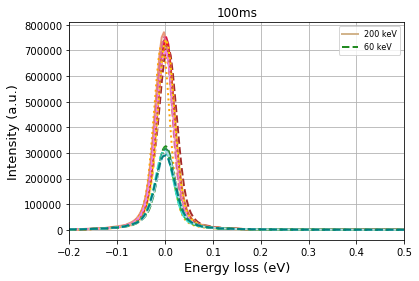

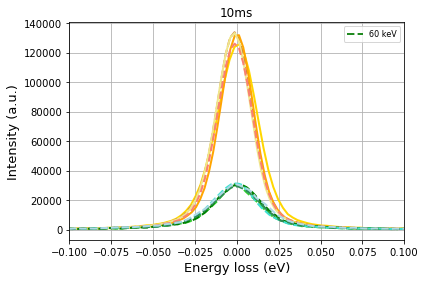

,x0,x1,x2,x3,x4,y0,y1,y2,y3,y4,time,energy
0,-0.746351,-0.709533,-0.675014,-0.694672,-0.673422,-482.2260,-403.7880,-424.410,-451.7850,-703.6880,10,200
1,-0.743452,-0.706799,-0.672443,-0.692015,-0.670867,648.7130,821.4990,952.905,674.4830,690.4970,10,200
2,-0.740554,-0.704064,-0.669871,-0.689358,-0.668311,-778.2360,-1185.7000,-725.496,-897.5780,-946.9150,10,200
3,-0.737655,-0.701330,-0.667300,-0.686702,-0.665756,81.2226,172.4970,671.286,16.7773,111.5060,10,200
4,-0.734757,-0.698596,-0.664729,-0.684045,-0.663200,155.9610,817.9910,545.909,529.7340,92.0555,10,200
...,...,...,...,...,...,...,...,...,...,...,...,...
2043,5.175357,4.876596,4.578429,4.732845,4.547600,-561.2010,-422.7600,-396.671,-684.2600,-860.4550,10,200
2044,5.178255,4.879330,4.581000,4.735502,4.550156,-771.2080,-187.8360,-338.211,-306.1240,-639.0300,10,200
2045,5.181154,4.882064,4.583571,4.738158,4.552711,-198.2660,42.9789,-337.384,-410.3230,-469.4970,10,200
2046,5.184052,4.884799,4.586143,4.740815,4.555267,-713.0260,-313.3830,-516.815,-197.8400,-935.8330,10,200


In [2]:
%run Data/Vacuum/EELS-ZLP-Mar.py

file10_200


In [3]:
file = file100_60
file_totaltot = pd.DataFrame()
fwhm_array = []

for i in range(0,5):
    x = file['x%(i)s'%{"i": i}]
    y = file['y%(i)s'%{"i": i}]
    file_total = pd.DataFrame()
    file_total['x'] = x
    file_total['y'] = y
    file_total['time'] = file['time']
    file_total['energy'] = file['energy']
    
    file_totaltot = pd.concat((file_totaltot, file_total), axis=0)
    


In [4]:
## Drop all data between FWHM and end

,x,y_norm,sigma,time,energy,rel_error,y
count,157.000000,157.000000,157.000000,157.000000,157.000000,90.000000,157.000000
mean,0.372449,0.156393,0.017729,0.501274,1.295541,0.140317,0.233348
std,0.463019,0.268120,0.027711,0.448786,0.702226,0.057695,0.229130
min,-0.094928,0.001000,0.000100,0.100000,0.600000,0.030345,0.100428
25%,-0.033898,0.001000,0.000100,0.100000,0.600000,0.103140,0.100653
50%,0.031884,0.020121,0.002629,0.100000,0.600000,0.133566,0.116785
75%,0.884211,0.155853,0.026517,1.000000,2.000000,0.162517,0.230380
max,1.000000,0.953779,0.108651,1.000000,2.000000,0.284583,0.900000


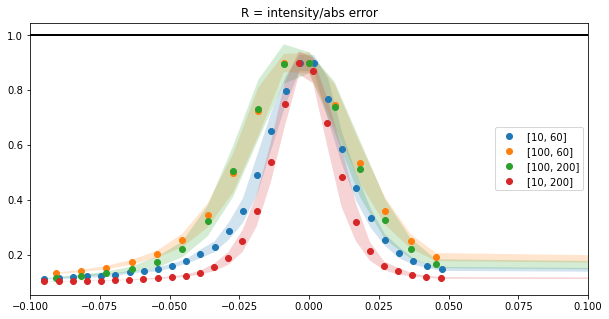

In [5]:
%run Functions.ipynb
meanfile = pd.DataFrame()
from copy import copy
mean = []
columns = ['x', 'y', 'time', 'energy']

file10_60 = pd.read_csv('Data/Vacuum/Datafiles/10_60_total.csv', skiprows = 1, names=columns)
file100_60 = pd.read_csv('Data/Vacuum/Datafiles/100_60_total.csv', skiprows = 1, names=columns)
file10_200 = pd.read_csv('Data/Vacuum/Datafiles/10_200_total.csv', skiprows = 1, names=columns)
file100_200= pd.read_csv('Data/Vacuum/Datafiles/100_200_total.csv', skiprows = 1, names=columns)

plt.figure(figsize=(10,5))
for i, file in enumerate([file10_60, file100_60, file100_200, file10_200]):
    E_min = -.1
    
    if file['time'].max() == 10:
        if file['energy'].max() == 200:
            E_max = min_x = .25
            nbins = 70
        if file['energy'].max() == 60:
            E_max = min_x = .2 
            nbins = 60
            
        max_x = 1
        
        N_pseudo = 120 - nbins
        
    if file['time'].max() == 100:
        E_max = .8
        min_x = .8
        max_x = 1
        nbins = 100
        N_pseudo = 120 - nbins
   
    window_file = file[(file['x'] > E_min) & (file['x'] < E_max)]
    
    ## Transform the data for scaling
    window_file['y_norm'] = np.divide(window_file['y'], window_file['y'].max())
    
    window_file['y_scaled'] = (window_file['y_norm'])*((8/9))+.1
    
        
    meanfile = pd.DataFrame()
    meanfile['x'] = np.linspace(E_min, E_max, nbins)
    meanfile['y_norm'] = binned_statistics(window_file['x'], window_file['y_norm'], nbins)[0]
    meanfile['sigma'] = binned_statistics(window_file['x'], window_file['y_norm'], nbins)[1]
    meanfile['time'] = file['time'].max()/100
    meanfile['energy'] = file['energy'].max()/100
    meanfile['rel_error'] = np.divide(meanfile['sigma'], meanfile['y_norm'])
    
    ### Scaler
    from sklearn.preprocessing import MinMaxScaler
    
    
    time = meanfile['time'].max()
    energy = meanfile['energy'].max()
    
    df_pseudo = pd.DataFrame({'x':np.linspace(min_x, max_x, N_pseudo),'y_norm': 0.001 * np.ones(N_pseudo), \
                        'sigma': 0.0001 * np.ones(N_pseudo), 'time': time, 'energy': energy})

    df_full = pd.concat([meanfile, df_pseudo])
    scaler = MinMaxScaler(feature_range=(.1, .9))
    to_scale = df_full['y_norm'].to_numpy().reshape(-1,1)
    scaler.fit(to_scale)
    
    df_full['y'] = scaler.transform(to_scale)
    
    
    ########### Cut one chunk of data #################################
    df_full_1  = df_full[(df_full['x'] > -.1) & (df_full['x'] < .05)]
    df_full_2  = df_full[(df_full['x'] > .8)]
    df_full = pd.concat((df_full_1, df_full_2), axis=0)
    df_full.describe()
    ##################################################################
    
    plt.plot(df_full['x'], df_full['y'], 'o', label=[file['time'].max(), file['energy'].max()])
    plt.axhline(y=1, linestyle='-', color='black')
    plt.legend()
    plt.fill_between(df_full['x'], df_full['y']+df_full['sigma'],df_full['y']-df_full['sigma'], alpha=.2)
    plt.xlim([-.1, .1])
    plt.title('R = intensity/abs error')
    
    mean.append(df_full)
total_mean = pd.concat(mean, axis=0, ignore_index=True)
total_mean.describe()

### Create architecture

In [6]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.sigmoid)
    #hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.15)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [7]:
tf.compat.v1.get_default_graph
from copy import copy
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
%run Functions.ipynb

x = tf.placeholder("float", [None, 3], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

df_full = total_mean
df_full = df_full.sort_values(by='x')
predictions = make_model(x,1)

df_full.describe()

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


,x,y_norm,sigma,time,energy,rel_error,y
count,157.000000,157.000000,157.000000,157.000000,157.000000,90.000000,157.000000
mean,0.372449,0.156393,0.017729,0.501274,1.295541,0.140317,0.233348
std,0.463019,0.268120,0.027711,0.448786,0.702226,0.057695,0.229130
min,-0.094928,0.001000,0.000100,0.100000,0.600000,0.030345,0.100428
25%,-0.033898,0.001000,0.000100,0.100000,0.600000,0.103140,0.100653
50%,0.031884,0.020121,0.002629,0.100000,0.600000,0.133566,0.116785
75%,0.884211,0.155853,0.026517,1.000000,2.000000,0.162517,0.230380
max,1.000000,0.953779,0.108651,1.000000,2.000000,0.284583,0.900000


In [8]:
df_train, df_test = train_test_split(df_full, test_size=0.2)

cols=[ 'x', 'time', 'energy', 'sigma']
train_inputs = df_train.drop(['y'], axis=1)[cols]
train_outputs = df_train['y']
test_inputs = df_test.drop(['y'], axis=1)[cols]
test_outputs = df_test['y']

train_x = train_inputs.drop('sigma', axis=1).to_numpy()
train_y = train_outputs.to_numpy()
train_sigma = train_inputs['sigma'].to_numpy()
test_x = test_inputs.drop('sigma', axis=1).to_numpy()
test_y = test_outputs.to_numpy()
test_sigma = test_inputs['sigma'].to_numpy()

df_test.describe()

train_sigma.shape


(125,)

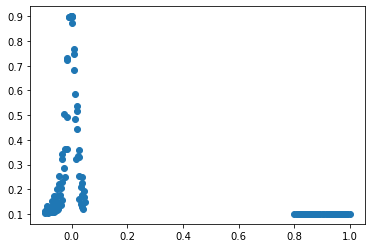

In [9]:
plt.plot(train_inputs['x'], train_outputs, 'o')

## Create MC replicas

In [10]:
### Create array of Nrep training samples
Nrep = 5000
N_train = len(train_y)
N_test = len(test_y)

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)



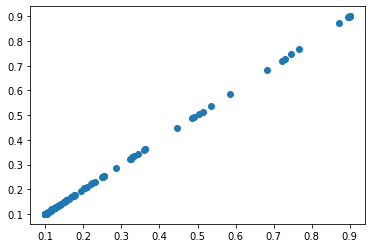

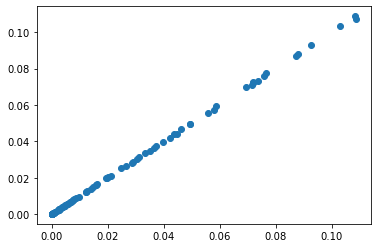

In [11]:
plt.plot(train_y, mean_reps, 'o')
plt.show()
plt.plot(train_sigma, std_reps, 'o')

In [12]:
## Beam energy interpolation

import random

part1 = 1000
N_pred = 10 * part1

interpol_energy1 = .2 #*100 keV
interpol_energy2 = .4 #*100 keV
interpol_energy3 = .6
interpol_energy4 = .8
interpol_energy5 = 1.2
interpol_energy6 = 1.8
interpol_energy7 = 2
interpol_energy8 = 2.2
interpol_energy9 = 2.5
interpol_energy10 = 3

interpol_time = .1
E_min = -.8
E_max = -.1

#Energy --> Energy range veranderen zodat het alleen interpolatie doet op E. 
predict_x = np.zeros(shape=(N_pred, 3))
predict_x[0*part1:1*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[1*part1:2*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[2*part1:3*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[3*part1:4*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[4*part1:5*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[5*part1:6*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[6*part1:7*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[7*part1:8*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[8*part1:9*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[9*part1:10*part1, 0] = np.linspace(E_min,E_max,part1)

#Time
predict_x[:,1] = interpol_time * np.ones(N_pred)

# E_beam
predict_x[0*part1:1*part1,2] = interpol_energy1 * np.ones(part1)
predict_x[1*part1:2*part1,2] = interpol_energy2 * np.ones(part1)
predict_x[2*part1:3*part1,2] = interpol_energy3 * np.ones(part1)
predict_x[3*part1:4*part1,2] = interpol_energy4 * np.ones(part1)
predict_x[4*part1:5*part1,2] = interpol_energy5 * np.ones(part1)
predict_x[5*part1:6*part1,2] = interpol_energy6 * np.ones(part1)
predict_x[6*part1:7*part1,2] = interpol_energy7 * np.ones(part1)
predict_x[7*part1:8*part1,2] = interpol_energy8 * np.ones(part1)
predict_x[8*part1:9*part1,2] = interpol_energy9 * np.ones(part1)
predict_x[9*part1:10*part1,2] = interpol_energy10 * np.ones(part1)

predict_x2 = copy(predict_x)
predict_x2[:,1] = 1 * np.ones(N_pred)
predict_x = np.vstack([predict_x, predict_x2])

In [13]:
predict_x.shape
N_pred = len(predict_x[:,0])


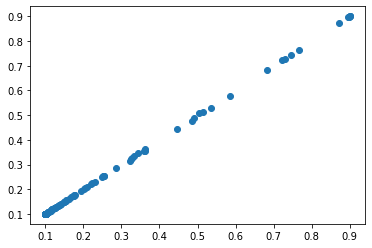

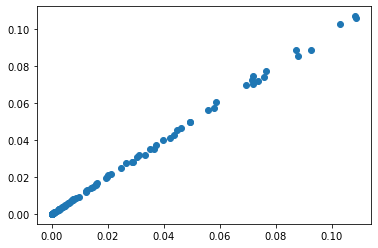

In [14]:
Nrep = 1000

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train,)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test,)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

train_sigma.shape
plt.plot(train_y, mean_reps, 'o')
plt.show()
plt.plot(train_sigma, std_reps, 'o')
plt.show()


In [15]:
import time
from datetime import datetime
now = datetime.now()
import tensorflow.compat.v1 as tf

def function_train(it):
    import tensorflow.compat.v1 as tf
    
    chi_array = []
    
    processor = 'processor' + str(it)
    cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
    custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
    eta = 4e-2

    #optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=eta, decay=0.9, momentum=0.0, epsilon=1e-10).minimize(cost)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(cost)

    saver = tf.compat.v1.train.Saver(max_to_keep=10000)
    print("%(p)s starts training on" %{'p': processor}, '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")
    
    Nrep = 500

    for i in range(0,500):
        train_y = train_y_reps[:, i + it].reshape(N_train,1)
        test_y = test_y_reps[:, i + it].reshape(N_test,1)
        
        train_y_og = train_outputs.to_numpy().reshape(N_train,1)
        test_y_og = test_outputs.to_numpy().reshape(N_test,1)
        
        ### Train and validate
        prev_test_cost = 100
        prev_epoch=0
        avg_cost = 0.0

        array_train = []
        array_test = []
        chi_train = []
        chi_test = []

        with tf.compat.v1.Session() as sess:
 
            sess.run(tf.global_variables_initializer())
            
            training_epochs = 30000
            max_rising_epochs = 50000 #The amount of epochs the minimzer is allowed to overfit before it stops
            display_step = 1000

            for epoch in range(training_epochs):

                _, c = sess.run([optimizer, cost], 
                                feed_dict={
                                    x: train_x,
                                    y: train_y,
                                    sigma: train_sigma.reshape(N_train,1)
                                })

                avg_cost = c

                test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma.reshape(N_test,1)})
                avg_chi = cost.eval({x: train_x, y: train_y_og, sigma: train_sigma.reshape(N_train,1)})
                test_chi = cost.eval({x: test_x, y: test_y_og, sigma: test_sigma.reshape(N_test,1)})


                if epoch % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
        
                    array_train.append(avg_cost)
                    array_test.append(test_cost)
                    chi_train.append(avg_chi)
                    chi_test.append(test_chi)
                    
                    saver.save(sess, 'Models/%(processor)s/my-model.ckpt' %{'processor': processor} , global_step=epoch , write_meta_graph=False) 

                    
                elif test_cost < prev_test_cost:
                    prev_test_cost = test_cost
                    prev_epoch = epoch

            best_iteration = np.argmin(array_test) 
            best_epoch = best_iteration * display_step
            best_model = 'Models/%(processor)s/my-model.ckpt-%(s)s' % {'processor': processor, 's': best_epoch}

            print("Optimization %(i)s Finished! Best model after epoch %(s)s" % {'i': i, 's': best_epoch})
            
            dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
            d_string = '29.08.2020'
            t_string = now.strftime("%H:%M:%S")
            print(d_string)
            
            saver.restore(sess, best_model)
            saver.save(sess, 'Models/Best_model/%(s)s/x1_processor%(it)s_%(i)s' % {'s': d_string, 'it': it, 'i': i})


            predictions_values = sess.run(predictions, 
                                feed_dict={
                                    x: train_x,
                                    y: train_y 
                                }) 

            
            extrapolation = sess.run(predictions,
                                feed_dict={
                                    x: predict_x
                                })
            

        sess.close()
        

        

        a = np.array(train_x[:,0]).reshape(N_train,)
        b = np.array(train_x[:,1]).reshape(N_train,)
        c = np.array(train_x[:,2]).reshape(N_train,)
        d = np.array(train_y).reshape(N_train,)
        e = np.array(predictions_values).reshape(N_train,)
        
        f = array_train
        g = array_test
       
        k = np.array(predict_x[:,0]).reshape(N_pred,)
        l = np.array(predict_x[:,1]).reshape(N_pred,)
        m = np.array(predict_x[:,2]).reshape(N_pred,)
        n = np.array(extrapolation).reshape(N_pred,)
                                     
        o = chi_train
        p = chi_test
        
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_xyp1p2_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(a,b,c,d,e)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_chi_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(f,g)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_extrapolation_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(k, l, m, n)),  delimiter=',', fmt='%f')
        np.savetxt('Data/Results/Vacuum/%(date)s/x1_chivalues_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i}, list(zip(o,p)),  delimiter=',', fmt='%f')
 

In [16]:
function_train(1)


processor1 starts training on 0125 and validating on 0032 samples
Epoch: 0001 | Training cost= 24608690.000000000 | Validation cost= 8215004.500000000
Epoch: 1001 | Training cost= 48.286640167 | Validation cost= 43.449874878
Epoch: 2001 | Training cost= 46.725845337 | Validation cost= 41.798278809
Epoch: 3001 | Training cost= 45.513370514 | Validation cost= 40.637779236
Epoch: 4001 | Training cost= 44.965518951 | Validation cost= 40.342689514
Epoch: 5001 | Training cost= 62.014686584 | Validation cost= 63.320198059
Epoch: 6001 | Training cost= 57.478061676 | Validation cost= 62.520904541
Epoch: 7001 | Training cost= 9392.964843750 | Validation cost= 18588.605468750
Epoch: 8001 | Training cost= 9308.550781250 | Validation cost= 5607.531250000
Epoch: 9001 | Training cost= 45.098030090 | Validation cost= 40.093307495
Epoch: 10001 | Training cost= 45.346454620 | Validation cost= 40.112541199
Epoch: 11001 | Training cost= 45.771575928 | Validation cost= 40.391036987
Epoch: 12001 | Training 

Epoch: 13001 | Training cost= 37.743518829 | Validation cost= 30.737880707
Epoch: 14001 | Training cost= 35.615406036 | Validation cost= 27.963836670
Epoch: 15001 | Training cost= 35.330093384 | Validation cost= 27.376773834
Epoch: 16001 | Training cost= 55.176170349 | Validation cost= 58.971824646
Epoch: 17001 | Training cost= 34.914535522 | Validation cost= 26.952953339
Epoch: 18001 | Training cost= 34.842056274 | Validation cost= 103.028640747
Epoch: 19001 | Training cost= 33.868110657 | Validation cost= 26.085416794
Epoch: 20001 | Training cost= 629.260559082 | Validation cost= 1297.826171875
Epoch: 21001 | Training cost= 1.757824302 | Validation cost= 2.252069950
Epoch: 22001 | Training cost= 1.251101255 | Validation cost= 11.481270790
Epoch: 23001 | Training cost= 0.797173560 | Validation cost= 1.224910975
Epoch: 24001 | Training cost= 0.861516714 | Validation cost= 1.507804394
Epoch: 25001 | Training cost= 0.754022062 | Validation cost= 1.173951864
Epoch: 26001 | Training cost= 

Epoch: 27001 | Training cost= 48.369293213 | Validation cost= 40.200256348
Epoch: 28001 | Training cost= 140.757415771 | Validation cost= 299.947998047
Epoch: 29001 | Training cost= 47.634105682 | Validation cost= 39.271930695
Optimization 6 Finished! Best model after epoch 25000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-25000
Epoch: 0001 | Training cost= 4549179.500000000 | Validation cost= 53194.281250000
Epoch: 1001 | Training cost= 45.403301239 | Validation cost= 42.492736816
Epoch: 2001 | Training cost= 45.161907196 | Validation cost= 42.497657776
Epoch: 3001 | Training cost= 44.957527161 | Validation cost= 42.630546570
Epoch: 4001 | Training cost= 57.276382446 | Validation cost= 63.676479340
Epoch: 5001 | Training cost= 45.140346527 | Validation cost= 41.912017822
Epoch: 6001 | Training cost= 45.762145996 | Validation cost= 41.839820862
Epoch: 7001 | Training cost= 45.974243164 | Validation cost= 41.861404419
Epoch: 8001 | Training cost=

Epoch: 9001 | Training cost= 50.224586487 | Validation cost= 43.176910400
Epoch: 10001 | Training cost= 50.208160400 | Validation cost= 43.447074890
Epoch: 11001 | Training cost= 50.145420074 | Validation cost= 44.039329529
Epoch: 12001 | Training cost= 48.435405731 | Validation cost= 42.068393707
Epoch: 13001 | Training cost= 45.119804382 | Validation cost= 40.675830841
Epoch: 14001 | Training cost= 55.971584320 | Validation cost= 40.757835388
Epoch: 15001 | Training cost= 37.958911896 | Validation cost= 35.656715393
Epoch: 16001 | Training cost= 37.552009583 | Validation cost= 35.011005402
Epoch: 17001 | Training cost= 105.252174377 | Validation cost= 165.816696167
Epoch: 18001 | Training cost= 37.718727112 | Validation cost= 98.860824585
Epoch: 19001 | Training cost= 36.474979401 | Validation cost= 33.841934204
Epoch: 20001 | Training cost= 30.719741821 | Validation cost= 30.260177612
Epoch: 21001 | Training cost= 18.920312881 | Validation cost= 22.237014771
Epoch: 22001 | Training 

Epoch: 23001 | Training cost= 1.807367682 | Validation cost= 11.639202118
Epoch: 24001 | Training cost= 1.249161720 | Validation cost= 2.838250399
Epoch: 25001 | Training cost= 1.042998791 | Validation cost= 2.704560757
Epoch: 26001 | Training cost= 0.906107306 | Validation cost= 2.358812332
Epoch: 27001 | Training cost= 1775.552734375 | Validation cost= 2131.429199219
Epoch: 28001 | Training cost= 0.957275331 | Validation cost= 2.502084732
Epoch: 29001 | Training cost= 5.148875713 | Validation cost= 2.601354122
Optimization 13 Finished! Best model after epoch 22000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-22000
Epoch: 0001 | Training cost= 43313824.000000000 | Validation cost= 23014118.000000000
Epoch: 1001 | Training cost= 47.825000763 | Validation cost= 37.849750519
Epoch: 2001 | Training cost= 47.037418365 | Validation cost= 37.401748657
Epoch: 3001 | Training cost= 46.432315826 | Validation cost= 37.083206177
Epoch: 4001 | Training cost=

Epoch: 5001 | Training cost= 66.906448364 | Validation cost= 55.416957855
Epoch: 6001 | Training cost= 44.837215424 | Validation cost= 40.516017914
Epoch: 7001 | Training cost= 44.313343048 | Validation cost= 40.318744659
Epoch: 8001 | Training cost= 43.848453522 | Validation cost= 40.600608826
Epoch: 9001 | Training cost= 50.310760498 | Validation cost= 39.423355103
Epoch: 10001 | Training cost= 43.090553284 | Validation cost= 39.140625000
Epoch: 11001 | Training cost= 42.229591370 | Validation cost= 39.393840790
Epoch: 12001 | Training cost= 41.557556152 | Validation cost= 39.012397766
Epoch: 13001 | Training cost= 40.218860626 | Validation cost= 37.904846191
Epoch: 14001 | Training cost= 36.907947540 | Validation cost= 34.206489563
Epoch: 15001 | Training cost= 36.587940216 | Validation cost= 33.465183258
Epoch: 16001 | Training cost= 36.335521698 | Validation cost= 33.125324249
Epoch: 17001 | Training cost= 35.783233643 | Validation cost= 32.490016937
Epoch: 18001 | Training cost= 

Epoch: 19001 | Training cost= 49.494159698 | Validation cost= 41.153419495
Epoch: 20001 | Training cost= 51.314922333 | Validation cost= 45.051017761
Epoch: 21001 | Training cost= 49.952415466 | Validation cost= 42.207752228
Epoch: 22001 | Training cost= 49.873062134 | Validation cost= 41.966377258
Epoch: 23001 | Training cost= 811.408752441 | Validation cost= 952.670410156
Epoch: 24001 | Training cost= 26.543954849 | Validation cost= 24.410243988
Epoch: 25001 | Training cost= 1.396045208 | Validation cost= 2.592587948
Epoch: 26001 | Training cost= 1.359088182 | Validation cost= 30.344139099
Epoch: 27001 | Training cost= 0.794284761 | Validation cost= 1.625491977
Epoch: 28001 | Training cost= 1069.190429688 | Validation cost= 513.633178711
Epoch: 29001 | Training cost= 0.709087551 | Validation cost= 1.768252850
Optimization 20 Finished! Best model after epoch 27000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-27000
Epoch: 0001 | Training cost= 25

Epoch: 1001 | Training cost= 47.316482544 | Validation cost= 36.226005554
Epoch: 2001 | Training cost= 53.187946320 | Validation cost= 50.735969543
Epoch: 3001 | Training cost= 66.961700439 | Validation cost= 67.842956543
Epoch: 4001 | Training cost= 47.122764587 | Validation cost= 36.427375793
Epoch: 5001 | Training cost= 46.880413055 | Validation cost= 35.664035797
Epoch: 6001 | Training cost= 47.333530426 | Validation cost= 36.019279480
Epoch: 7001 | Training cost= 186.121398926 | Validation cost= 67.533485413
Epoch: 8001 | Training cost= 47.813755035 | Validation cost= 36.547771454
Epoch: 9001 | Training cost= 47.523086548 | Validation cost= 36.067020416
Epoch: 10001 | Training cost= 47.571212769 | Validation cost= 36.294025421
Epoch: 11001 | Training cost= 46.293224335 | Validation cost= 35.084381104
Epoch: 12001 | Training cost= 45.311431885 | Validation cost= 35.076293945
Epoch: 13001 | Training cost= 42.546016693 | Validation cost= 33.678150177
Epoch: 14001 | Training cost= 39.

Epoch: 15001 | Training cost= 46.226299286 | Validation cost= 42.139545441
Epoch: 16001 | Training cost= 46.275455475 | Validation cost= 42.161277771
Epoch: 17001 | Training cost= 46.275100708 | Validation cost= 42.169445038
Epoch: 18001 | Training cost= 46.299293518 | Validation cost= 42.210014343
Epoch: 19001 | Training cost= 46.376014709 | Validation cost= 42.261043549
Epoch: 20001 | Training cost= 46.895561218 | Validation cost= 42.684803009
Epoch: 21001 | Training cost= 46.686336517 | Validation cost= 42.416900635
Epoch: 22001 | Training cost= 46.643665314 | Validation cost= 42.380676270
Epoch: 23001 | Training cost= 1758.580200195 | Validation cost= 3287.933593750
Epoch: 24001 | Training cost= 56.455711365 | Validation cost= 45.898555756
Epoch: 25001 | Training cost= 47.209930420 | Validation cost= 43.261157990
Epoch: 26001 | Training cost= 46.578361511 | Validation cost= 42.297466278
Epoch: 27001 | Training cost= 47.524593353 | Validation cost= 43.966243744
Epoch: 28001 | Traini

Epoch: 29001 | Training cost= 2.647865295 | Validation cost= 6.818183899
Optimization 30 Finished! Best model after epoch 26000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-26000
Epoch: 0001 | Training cost= 14289736.000000000 | Validation cost= 3431228.250000000
Epoch: 1001 | Training cost= 50.661560059 | Validation cost= 44.594337463
Epoch: 2001 | Training cost= 49.212642670 | Validation cost= 41.265060425
Epoch: 3001 | Training cost= 48.522178650 | Validation cost= 40.569881439
Epoch: 4001 | Training cost= 47.688457489 | Validation cost= 39.821987152
Epoch: 5001 | Training cost= 47.151992798 | Validation cost= 39.388099670
Epoch: 6001 | Training cost= 46.830497742 | Validation cost= 39.130760193
Epoch: 7001 | Training cost= 46.677101135 | Validation cost= 39.027626038
Epoch: 8001 | Training cost= 46.321109772 | Validation cost= 38.787303925
Epoch: 9001 | Training cost= 45.841026306 | Validation cost= 38.489307404
Epoch: 10001 | Training cost= 

Epoch: 11001 | Training cost= 44.818241119 | Validation cost= 39.227191925
Epoch: 12001 | Training cost= 44.600673676 | Validation cost= 39.036323547
Epoch: 13001 | Training cost= 42.672981262 | Validation cost= 38.146636963
Epoch: 14001 | Training cost= 41.171890259 | Validation cost= 38.044792175
Epoch: 15001 | Training cost= 37.897651672 | Validation cost= 35.228351593
Epoch: 16001 | Training cost= 35.334838867 | Validation cost= 31.979740143
Epoch: 17001 | Training cost= 35.030639648 | Validation cost= 31.514165878
Epoch: 18001 | Training cost= 34.766727448 | Validation cost= 31.290105820
Epoch: 19001 | Training cost= 35.202335358 | Validation cost= 33.255554199
Epoch: 20001 | Training cost= 34.133537292 | Validation cost= 30.971443176
Epoch: 21001 | Training cost= 39.115310669 | Validation cost= 42.319206238
Epoch: 22001 | Training cost= 13.628098488 | Validation cost= 16.310535431
Epoch: 23001 | Training cost= 2.164681673 | Validation cost= 2.261708021
Epoch: 24001 | Training cos

Epoch: 25001 | Training cost= 1.466400027 | Validation cost= 4.136890888
Epoch: 26001 | Training cost= 977.753234863 | Validation cost= 50.292701721
Epoch: 27001 | Training cost= 1.392137766 | Validation cost= 4.811874390
Epoch: 28001 | Training cost= 41.978027344 | Validation cost= 268.424804688
Epoch: 29001 | Training cost= 1.324433923 | Validation cost= 9.976904869
Optimization 37 Finished! Best model after epoch 25000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-25000
Epoch: 0001 | Training cost= 1086331.250000000 | Validation cost= 6125375.000000000
Epoch: 1001 | Training cost= 48.658359528 | Validation cost= 50.678733826
Epoch: 2001 | Training cost= 47.621627808 | Validation cost= 47.216648102
Epoch: 3001 | Training cost= 47.907493591 | Validation cost= 45.252273560
Epoch: 4001 | Training cost= 47.123939514 | Validation cost= 44.669845581
Epoch: 5001 | Training cost= 47.224967957 | Validation cost= 43.909904480
Epoch: 6001 | Training cost= 

Epoch: 7001 | Training cost= 84.595108032 | Validation cost= 53.442047119
Epoch: 8001 | Training cost= 45.450450897 | Validation cost= 35.064231873
Epoch: 9001 | Training cost= 45.486362457 | Validation cost= 37.524539948
Epoch: 10001 | Training cost= 59.691749573 | Validation cost= 43.376670837
Epoch: 11001 | Training cost= 43.972503662 | Validation cost= 34.598823547
Epoch: 12001 | Training cost= 38.720928192 | Validation cost= 33.163635254
Epoch: 13001 | Training cost= 36.244644165 | Validation cost= 30.474870682
Epoch: 14001 | Training cost= 35.994361877 | Validation cost= 29.851816177
Epoch: 15001 | Training cost= 35.802951813 | Validation cost= 29.553022385
Epoch: 16001 | Training cost= 36.433845520 | Validation cost= 31.586074829
Epoch: 17001 | Training cost= 35.339172363 | Validation cost= 29.437791824
Epoch: 18001 | Training cost= 35.003894806 | Validation cost= 29.116712570
Epoch: 19001 | Training cost= 34.940906525 | Validation cost= 31.433546066
Epoch: 20001 | Training cost

Epoch: 21001 | Training cost= 0.986867547 | Validation cost= 2.085172415
Epoch: 22001 | Training cost= 0.856095672 | Validation cost= 2.327413797
Epoch: 23001 | Training cost= 0.786862731 | Validation cost= 2.161615849
Epoch: 24001 | Training cost= 1.704925776 | Validation cost= 6.159904480
Epoch: 25001 | Training cost= 0.756967425 | Validation cost= 2.325761795
Epoch: 26001 | Training cost= 38.037509918 | Validation cost= 280.867309570
Epoch: 27001 | Training cost= 1.146128416 | Validation cost= 3.548091650
Epoch: 28001 | Training cost= 0.717237890 | Validation cost= 2.872787476
Epoch: 29001 | Training cost= 0.974422336 | Validation cost= 3.902957201
Optimization 44 Finished! Best model after epoch 21000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-21000
Epoch: 0001 | Training cost= 27251.322265625 | Validation cost= 7346137.000000000
Epoch: 1001 | Training cost= 47.156959534 | Validation cost= 46.808807373
Epoch: 2001 | Training cost= 45.857967

Epoch: 3001 | Training cost= 49.513484955 | Validation cost= 46.586441040
Epoch: 4001 | Training cost= 48.556224823 | Validation cost= 45.673358917
Epoch: 5001 | Training cost= 47.288707733 | Validation cost= 44.518386841
Epoch: 6001 | Training cost= 3568.185302734 | Validation cost= 7327.527343750
Epoch: 7001 | Training cost= 178.839614868 | Validation cost= 622.019287109
Epoch: 8001 | Training cost= 45.162792206 | Validation cost= 42.875244141
Epoch: 9001 | Training cost= 45.351741791 | Validation cost= 42.996421814
Epoch: 10001 | Training cost= 45.262599945 | Validation cost= 42.945980072
Epoch: 11001 | Training cost= 45.188266754 | Validation cost= 42.930660248
Epoch: 12001 | Training cost= 45.270252228 | Validation cost= 42.981109619
Epoch: 13001 | Training cost= 45.306602478 | Validation cost= 43.013572693
Epoch: 14001 | Training cost= 68.323677063 | Validation cost= 94.297531128
Epoch: 15001 | Training cost= 46.003810883 | Validation cost= 123.485160828
Epoch: 16001 | Training c

Epoch: 17001 | Training cost= 34.835254669 | Validation cost= 32.072223663
Epoch: 18001 | Training cost= 32.567951202 | Validation cost= 29.673954010
Epoch: 19001 | Training cost= 26.228380203 | Validation cost= 28.362083435
Epoch: 20001 | Training cost= 108.780128479 | Validation cost= 43.549770355
Epoch: 21001 | Training cost= 6.317793846 | Validation cost= 10.602504730
Epoch: 22001 | Training cost= 1.515822053 | Validation cost= 1.141351938
Epoch: 23001 | Training cost= 1.250619531 | Validation cost= 1.507923126
Epoch: 24001 | Training cost= 0.999400377 | Validation cost= 1.351875544
Epoch: 25001 | Training cost= 2.266907930 | Validation cost= 3.000308275
Epoch: 26001 | Training cost= 0.863066316 | Validation cost= 1.435462713
Epoch: 27001 | Training cost= 258.731262207 | Validation cost= 49.622272491
Epoch: 28001 | Training cost= 0.821714640 | Validation cost= 1.597922325
Epoch: 29001 | Training cost= 790.169311523 | Validation cost= 869.860473633
Optimization 51 Finished! Best mod

Epoch: 0001 | Training cost= 8549707.000000000 | Validation cost= 598162.000000000
Epoch: 1001 | Training cost= 44.307624817 | Validation cost= 38.557155609
Epoch: 2001 | Training cost= 43.630142212 | Validation cost= 38.241027832
Epoch: 3001 | Training cost= 43.169422150 | Validation cost= 38.282218933
Epoch: 4001 | Training cost= 57.379287720 | Validation cost= 349.216369629
Epoch: 5001 | Training cost= 43.212352753 | Validation cost= 37.597690582
Epoch: 6001 | Training cost= 43.492351532 | Validation cost= 37.367534637
Epoch: 7001 | Training cost= 43.844779968 | Validation cost= 37.256912231
Epoch: 8001 | Training cost= 54.584461212 | Validation cost= 37.380867004
Epoch: 9001 | Training cost= 44.942848206 | Validation cost= 43.629318237
Epoch: 10001 | Training cost= 44.154930115 | Validation cost= 37.091804504
Epoch: 11001 | Training cost= 42.325317383 | Validation cost= 36.238529205
Epoch: 12001 | Training cost= 39.986957550 | Validation cost= 36.431484222
Epoch: 13001 | Training c

Epoch: 14001 | Training cost= 36.899597168 | Validation cost= 34.906681061
Epoch: 15001 | Training cost= 35.397502899 | Validation cost= 32.351787567
Epoch: 16001 | Training cost= 35.184444427 | Validation cost= 31.836194992
Epoch: 17001 | Training cost= 34.993751526 | Validation cost= 31.538690567
Epoch: 18001 | Training cost= 57.245502472 | Validation cost= 74.449981689
Epoch: 19001 | Training cost= 34.731185913 | Validation cost= 31.364807129
Epoch: 20001 | Training cost= 34.507110596 | Validation cost= 31.265428543
Epoch: 21001 | Training cost= 50.068222046 | Validation cost= 33.964584351
Epoch: 22001 | Training cost= 60.740043640 | Validation cost= 125.832931519
Epoch: 23001 | Training cost= 1.495511889 | Validation cost= 3.328992844
Epoch: 24001 | Training cost= 3.390490532 | Validation cost= 6.550993443
Epoch: 25001 | Training cost= 1.092087746 | Validation cost= 2.511585712
Epoch: 26001 | Training cost= 1.030483723 | Validation cost= 2.367983341
Epoch: 27001 | Training cost= 3.

Epoch: 28001 | Training cost= 1.186084270 | Validation cost= 2.930918694
Epoch: 29001 | Training cost= 0.906679928 | Validation cost= 1.943261385
Optimization 61 Finished! Best model after epoch 26000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-26000
Epoch: 0001 | Training cost= 18453924.000000000 | Validation cost= 2822638.500000000
Epoch: 1001 | Training cost= 44.024932861 | Validation cost= 37.543663025
Epoch: 2001 | Training cost= 43.715801239 | Validation cost= 37.485397339
Epoch: 3001 | Training cost= 43.368190765 | Validation cost= 37.508323669
Epoch: 4001 | Training cost= 915.926025391 | Validation cost= 3754.252929688
Epoch: 5001 | Training cost= 3132.176025391 | Validation cost= 6965.813476562
Epoch: 6001 | Training cost= 101.559715271 | Validation cost= 165.983398438
Epoch: 7001 | Training cost= 44.208751678 | Validation cost= 37.481742859
Epoch: 8001 | Training cost= 44.233093262 | Validation cost= 37.490650177
Epoch: 9001 | Training

Epoch: 10001 | Training cost= 43.634780884 | Validation cost= 38.891948700
Epoch: 11001 | Training cost= 42.726963043 | Validation cost= 38.775390625
Epoch: 12001 | Training cost= 41.392837524 | Validation cost= 38.589508057
Epoch: 13001 | Training cost= 37.032550812 | Validation cost= 33.626621246
Epoch: 14001 | Training cost= 144.870971680 | Validation cost= 75.020629883
Epoch: 15001 | Training cost= 35.822254181 | Validation cost= 31.807285309
Epoch: 16001 | Training cost= 48.552909851 | Validation cost= 59.795215607
Epoch: 17001 | Training cost= 35.367141724 | Validation cost= 31.645427704
Epoch: 18001 | Training cost= 27.470426559 | Validation cost= 28.788089752
Epoch: 19001 | Training cost= 13.599837303 | Validation cost= 19.324722290
Epoch: 20001 | Training cost= 99.595718384 | Validation cost= 23.651596069
Epoch: 21001 | Training cost= 33.280036926 | Validation cost= 12.709207535
Epoch: 22001 | Training cost= 1.233920932 | Validation cost= 2.916504145
Epoch: 23001 | Training co

Epoch: 24001 | Training cost= 15.789585114 | Validation cost= 36.516265869
Epoch: 25001 | Training cost= 0.739573717 | Validation cost= 2.813324928
Epoch: 26001 | Training cost= 0.987485349 | Validation cost= 3.536386013
Epoch: 27001 | Training cost= 194.282974243 | Validation cost= 15.446654320
Epoch: 28001 | Training cost= 1.090882182 | Validation cost= 3.477329254
Epoch: 29001 | Training cost= 0.663374126 | Validation cost= 2.807209015
Optimization 68 Finished! Best model after epoch 29000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-29000
Epoch: 0001 | Training cost= 75241176.000000000 | Validation cost= 47321592.000000000
Epoch: 1001 | Training cost= 51.049171448 | Validation cost= 45.141895294
Epoch: 2001 | Training cost= 50.067668915 | Validation cost= 44.005241394
Epoch: 3001 | Training cost= 49.628814697 | Validation cost= 43.903099060
Epoch: 4001 | Training cost= 49.282283783 | Validation cost= 43.825614929
Epoch: 5001 | Training cost= 

Epoch: 6001 | Training cost= 47.246250153 | Validation cost= 36.194892883
Epoch: 7001 | Training cost= 47.334720612 | Validation cost= 36.282279968
Epoch: 8001 | Training cost= 2150.555419922 | Validation cost= 3701.877929688
Epoch: 9001 | Training cost= 47.733886719 | Validation cost= 36.646686554
Epoch: 10001 | Training cost= 47.836040497 | Validation cost= 36.790473938
Epoch: 11001 | Training cost= 47.709480286 | Validation cost= 36.658729553
Epoch: 12001 | Training cost= 47.315261841 | Validation cost= 36.767074585
Epoch: 13001 | Training cost= 45.103057861 | Validation cost= 34.576278687
Epoch: 14001 | Training cost= 36.404087067 | Validation cost= 28.874826431
Epoch: 15001 | Training cost= 35.945358276 | Validation cost= 28.118291855
Epoch: 16001 | Training cost= 146.367370605 | Validation cost= 48.135982513
Epoch: 17001 | Training cost= 35.332328796 | Validation cost= 27.901756287
Epoch: 18001 | Training cost= 34.369247437 | Validation cost= 26.844039917
Epoch: 19001 | Training 

Epoch: 20001 | Training cost= 32.230407715 | Validation cost= 28.343021393
Epoch: 21001 | Training cost= 151.644165039 | Validation cost= 164.967880249
Epoch: 22001 | Training cost= 144.568969727 | Validation cost= 32.676437378
Epoch: 23001 | Training cost= 1.042181492 | Validation cost= 1.358476281
Epoch: 24001 | Training cost= 1.209569812 | Validation cost= 3.058366299
Epoch: 25001 | Training cost= 32.185493469 | Validation cost= 19.563549042
Epoch: 26001 | Training cost= 0.729046106 | Validation cost= 1.426037908
Epoch: 27001 | Training cost= 2.912878036 | Validation cost= 3.686547279
Epoch: 28001 | Training cost= 0.793063641 | Validation cost= 1.807507753
Epoch: 29001 | Training cost= 0.807953715 | Validation cost= 1.838055849
Optimization 75 Finished! Best model after epoch 23000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-23000
Epoch: 0001 | Training cost= 2612906.250000000 | Validation cost= 218987.437500000
Epoch: 1001 | Training cost= 4

Epoch: 2001 | Training cost= 45.196399689 | Validation cost= 40.716785431
Epoch: 3001 | Training cost= 45.295684814 | Validation cost= 39.814056396
Epoch: 4001 | Training cost= 4553.524414062 | Validation cost= 10279.224609375
Epoch: 5001 | Training cost= 45.157672882 | Validation cost= 39.500770569
Epoch: 6001 | Training cost= 45.551853180 | Validation cost= 39.519691467
Epoch: 7001 | Training cost= 44.827816010 | Validation cost= 39.346794128
Epoch: 8001 | Training cost= 44.684654236 | Validation cost= 39.041404724
Epoch: 9001 | Training cost= 44.144554138 | Validation cost= 38.747367859
Epoch: 10001 | Training cost= 44.078792572 | Validation cost= 41.258445740
Epoch: 11001 | Training cost= 91.965339661 | Validation cost= 139.537658691
Epoch: 12001 | Training cost= 45.435607910 | Validation cost= 45.500453949
Epoch: 13001 | Training cost= 37.056629181 | Validation cost= 34.821102142
Epoch: 14001 | Training cost= 36.224487305 | Validation cost= 33.293746948
Epoch: 15001 | Training cos

Epoch: 16001 | Training cost= 37.591152191 | Validation cost= 33.416656494
Epoch: 17001 | Training cost= 37.386615753 | Validation cost= 33.108837128
Epoch: 18001 | Training cost= 46.157440186 | Validation cost= 51.153045654
Epoch: 19001 | Training cost= 38.343910217 | Validation cost= 36.143939972
Epoch: 20001 | Training cost= 37.168441772 | Validation cost= 32.785598755
Epoch: 21001 | Training cost= 35.717197418 | Validation cost= 31.749912262
Epoch: 22001 | Training cost= 1.535173297 | Validation cost= 2.350059986
Epoch: 23001 | Training cost= 0.818663716 | Validation cost= 1.385444641
Epoch: 24001 | Training cost= 4.168557644 | Validation cost= 1.316035986
Epoch: 25001 | Training cost= 0.720534921 | Validation cost= 1.284878254
Epoch: 26001 | Training cost= 172.824340820 | Validation cost= 9.857864380
Epoch: 27001 | Training cost= 0.695645690 | Validation cost= 1.417372942
Epoch: 28001 | Training cost= 224.487808228 | Validation cost= 508.178741455
Epoch: 29001 | Training cost= 0.6

Optimization 85 Finished! Best model after epoch 16000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-16000
Epoch: 0001 | Training cost= 42627980.000000000 | Validation cost= 18518494.000000000
Epoch: 1001 | Training cost= 58.305725098 | Validation cost= 48.945114136
Epoch: 2001 | Training cost= 55.145877838 | Validation cost= 46.437664032
Epoch: 3001 | Training cost= 53.139526367 | Validation cost= 44.341335297
Epoch: 4001 | Training cost= 50.619880676 | Validation cost= 41.909687042
Epoch: 5001 | Training cost= 48.122947693 | Validation cost= 39.885334015
Epoch: 6001 | Training cost= 46.511287689 | Validation cost= 39.002986908
Epoch: 7001 | Training cost= 45.572929382 | Validation cost= 38.017215729
Epoch: 8001 | Training cost= 1684.461547852 | Validation cost= 1350.921142578
Epoch: 9001 | Training cost= 43.979183197 | Validation cost= 36.646232605
Epoch: 10001 | Training cost= 43.214702606 | Validation cost= 36.631202698
Epoch: 11001 | Training

Epoch: 12001 | Training cost= 42.743583679 | Validation cost= 39.795074463
Epoch: 13001 | Training cost= 39.634704590 | Validation cost= 36.578433990
Epoch: 14001 | Training cost= 38.923015594 | Validation cost= 35.557281494
Epoch: 15001 | Training cost= 38.600944519 | Validation cost= 37.202175140
Epoch: 16001 | Training cost= 40.649929047 | Validation cost= 35.530120850
Epoch: 17001 | Training cost= 37.471748352 | Validation cost= 32.846237183
Epoch: 18001 | Training cost= 37.345432281 | Validation cost= 32.690242767
Epoch: 19001 | Training cost= 37.749328613 | Validation cost= 49.958560944
Epoch: 20001 | Training cost= 37.143638611 | Validation cost= 32.442390442
Epoch: 21001 | Training cost= 37.058311462 | Validation cost= 32.454807281
Epoch: 22001 | Training cost= 30.127107620 | Validation cost= 30.477176666
Epoch: 23001 | Training cost= 24.723218918 | Validation cost= 28.858993530
Epoch: 24001 | Training cost= 68.557609558 | Validation cost= 60.554412842
Epoch: 25001 | Training c

Epoch: 26001 | Training cost= 1.010647416 | Validation cost= 1.727548838
Epoch: 27001 | Training cost= 142.613311768 | Validation cost= 311.695617676
Epoch: 28001 | Training cost= 0.837941825 | Validation cost= 1.452086449
Epoch: 29001 | Training cost= 86.399971008 | Validation cost= 450.622161865
Optimization 92 Finished! Best model after epoch 25000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-25000
Epoch: 0001 | Training cost= 2077141.375000000 | Validation cost= 895319.750000000
Epoch: 1001 | Training cost= 44.036437988 | Validation cost= 38.334857941
Epoch: 2001 | Training cost= 42.455101013 | Validation cost= 38.493854523
Epoch: 3001 | Training cost= 825.886657715 | Validation cost= 304.439239502
Epoch: 4001 | Training cost= 42.229591370 | Validation cost= 38.077835083
Epoch: 5001 | Training cost= 42.382907867 | Validation cost= 37.757568359
Epoch: 6001 | Training cost= 42.071495056 | Validation cost= 37.808036804
Epoch: 7001 | Training cos

Epoch: 8001 | Training cost= 46.605522156 | Validation cost= 39.096679688
Epoch: 9001 | Training cost= 46.059310913 | Validation cost= 38.511756897
Epoch: 10001 | Training cost= 176.488479614 | Validation cost= 166.824081421
Epoch: 11001 | Training cost= 45.086799622 | Validation cost= 37.697257996
Epoch: 12001 | Training cost= 42.594188690 | Validation cost= 36.991760254
Epoch: 13001 | Training cost= 38.916873932 | Validation cost= 34.011920929
Epoch: 14001 | Training cost= 115.381454468 | Validation cost= 34.148773193
Epoch: 15001 | Training cost= 57.534690857 | Validation cost= 81.282539368
Epoch: 16001 | Training cost= 269.839538574 | Validation cost= 580.561584473
Epoch: 17001 | Training cost= 37.875015259 | Validation cost= 32.305007935
Epoch: 18001 | Training cost= 35.939018250 | Validation cost= 30.099405289
Epoch: 19001 | Training cost= 1191.703735352 | Validation cost= 588.793212891
Epoch: 20001 | Training cost= 35.090770721 | Validation cost= 29.412921906
Epoch: 21001 | Trai

Epoch: 22001 | Training cost= 32.351787567 | Validation cost= 36.284877777
Epoch: 23001 | Training cost= 61.586048126 | Validation cost= 24.383787155
Epoch: 24001 | Training cost= 10.734171867 | Validation cost= 8.595900536
Epoch: 25001 | Training cost= 3.592421055 | Validation cost= 8.740461349
Epoch: 26001 | Training cost= 2.255991459 | Validation cost= 3.982468128
Epoch: 27001 | Training cost= 1.725197196 | Validation cost= 3.572325706
Epoch: 28001 | Training cost= 1.401362658 | Validation cost= 3.315309525
Epoch: 29001 | Training cost= 1.831472039 | Validation cost= 4.277346611
Optimization 99 Finished! Best model after epoch 28000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-28000
Epoch: 0001 | Training cost= 2573474.000000000 | Validation cost= 2500180.000000000
Epoch: 1001 | Training cost= 52.201244354 | Validation cost= 48.578250885
Epoch: 2001 | Training cost= 47.731369019 | Validation cost= 43.706413269
Epoch: 3001 | Training cost= 46.0

Epoch: 4001 | Training cost= 44.236656189 | Validation cost= 36.101623535
Epoch: 5001 | Training cost= 44.306995392 | Validation cost= 36.079986572
Epoch: 6001 | Training cost= 44.118938446 | Validation cost= 36.030899048
Epoch: 7001 | Training cost= 43.918121338 | Validation cost= 35.936557770
Epoch: 8001 | Training cost= 43.955936432 | Validation cost= 35.947509766
Epoch: 9001 | Training cost= 43.251838684 | Validation cost= 35.481567383
Epoch: 10001 | Training cost= 42.579452515 | Validation cost= 35.712493896
Epoch: 11001 | Training cost= 64.088142395 | Validation cost= 84.035156250
Epoch: 12001 | Training cost= 40.741905212 | Validation cost= 33.670265198
Epoch: 13001 | Training cost= 39.023490906 | Validation cost= 32.522064209
Epoch: 14001 | Training cost= 35.633460999 | Validation cost= 28.986026764
Epoch: 15001 | Training cost= 34.896244049 | Validation cost= 27.604980469
Epoch: 16001 | Training cost= 35.308540344 | Validation cost= 27.735893250
Epoch: 17001 | Training cost= 3

Epoch: 18001 | Training cost= 34.427093506 | Validation cost= 33.198951721
Epoch: 19001 | Training cost= 33.137706757 | Validation cost= 31.761310577
Epoch: 20001 | Training cost= 87.265937805 | Validation cost= 129.619049072
Epoch: 21001 | Training cost= 0.955262661 | Validation cost= 2.897229195
Epoch: 22001 | Training cost= 1.039546251 | Validation cost= 1.653085113
Epoch: 23001 | Training cost= 0.796837866 | Validation cost= 1.388251543
Epoch: 24001 | Training cost= 3.858534813 | Validation cost= 9.371094704
Epoch: 25001 | Training cost= 0.735072196 | Validation cost= 1.402889967
Epoch: 26001 | Training cost= 360.887878418 | Validation cost= 888.977539062
Epoch: 27001 | Training cost= 0.741743624 | Validation cost= 1.727035999
Epoch: 28001 | Training cost= 0.791597366 | Validation cost= 1.950486779
Epoch: 29001 | Training cost= 0.701160073 | Validation cost= 1.858449817
Optimization 106 Finished! Best model after epoch 23000
29.08.2020
INFO:tensorflow:Restoring parameters from Mode

Epoch: 0001 | Training cost= 678341.687500000 | Validation cost= 3336542.500000000
Epoch: 1001 | Training cost= 44.797191620 | Validation cost= 41.659240723
Epoch: 2001 | Training cost= 44.622138977 | Validation cost= 41.586433411
Epoch: 3001 | Training cost= 45.513942719 | Validation cost= 41.889968872
Epoch: 4001 | Training cost= 46.049289703 | Validation cost= 42.201393127
Epoch: 5001 | Training cost= 46.294582367 | Validation cost= 42.452270508
Epoch: 6001 | Training cost= 46.262088776 | Validation cost= 42.553375244
Epoch: 7001 | Training cost= 46.418289185 | Validation cost= 42.539634705
Epoch: 8001 | Training cost= 257.562286377 | Validation cost= 82.214179993
Epoch: 9001 | Training cost= 45.226837158 | Validation cost= 45.622089386
Epoch: 10001 | Training cost= 43.842987061 | Validation cost= 40.292358398
Epoch: 11001 | Training cost= 42.621757507 | Validation cost= 39.436683655
Epoch: 12001 | Training cost= 149.550765991 | Validation cost= 102.026046753
Epoch: 13001 | Training

Epoch: 14001 | Training cost= 36.468147278 | Validation cost= 35.377899170
Epoch: 15001 | Training cost= 87.284439087 | Validation cost= 269.797363281
Epoch: 16001 | Training cost= 35.369674683 | Validation cost= 33.205162048
Epoch: 17001 | Training cost= 35.459602356 | Validation cost= 33.345054626
Epoch: 18001 | Training cost= 35.938304901 | Validation cost= 33.726093292
Epoch: 19001 | Training cost= 34.587421417 | Validation cost= 32.401092529
Epoch: 20001 | Training cost= 34.328338623 | Validation cost= 31.963306427
Epoch: 21001 | Training cost= 34.108413696 | Validation cost= 31.620418549
Epoch: 22001 | Training cost= 33.825077057 | Validation cost= 31.243118286
Epoch: 23001 | Training cost= 45.382213593 | Validation cost= 43.296173096
Epoch: 24001 | Training cost= 21.601236343 | Validation cost= 21.163764954
Epoch: 25001 | Training cost= 2.597974300 | Validation cost= 3.114068985
Epoch: 26001 | Training cost= 3.541126728 | Validation cost= 11.511898994
Epoch: 27001 | Training cos

Epoch: 28001 | Training cost= 0.964214087 | Validation cost= 1.782688141
Epoch: 29001 | Training cost= 2.299894571 | Validation cost= 5.247329712
Optimization 116 Finished! Best model after epoch 27000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-27000
Epoch: 0001 | Training cost= 100762272.000000000 | Validation cost= 75088192.000000000
Epoch: 1001 | Training cost= 49.403228760 | Validation cost= 44.379051208
Epoch: 2001 | Training cost= 49.392539978 | Validation cost= 44.368820190
Epoch: 3001 | Training cost= 49.373790741 | Validation cost= 44.350978851
Epoch: 4001 | Training cost= 49.343677521 | Validation cost= 44.322326660
Epoch: 5001 | Training cost= 49.297336578 | Validation cost= 44.278377533
Epoch: 6001 | Training cost= 49.229251862 | Validation cost= 44.214015961
Epoch: 7001 | Training cost= 49.134094238 | Validation cost= 44.125247955
Epoch: 8001 | Training cost= 49.007938385 | Validation cost= 44.009613037
Epoch: 9001 | Training cost=

Epoch: 10001 | Training cost= 47.117050171 | Validation cost= 37.131240845
Epoch: 11001 | Training cost= 47.064231873 | Validation cost= 37.220199585
Epoch: 12001 | Training cost= 47.172233582 | Validation cost= 37.308761597
Epoch: 13001 | Training cost= 47.235805511 | Validation cost= 37.363822937
Epoch: 14001 | Training cost= 47.307365417 | Validation cost= 37.416114807
Epoch: 15001 | Training cost= 47.199016571 | Validation cost= 37.394615173
Epoch: 16001 | Training cost= 177.880828857 | Validation cost= 401.898590088
Epoch: 17001 | Training cost= 48.392154694 | Validation cost= 37.817089081
Epoch: 18001 | Training cost= 47.745708466 | Validation cost= 37.821212769
Epoch: 19001 | Training cost= 47.720211029 | Validation cost= 37.790737152
Epoch: 20001 | Training cost= 47.480140686 | Validation cost= 37.537322998
Epoch: 21001 | Training cost= 47.517215729 | Validation cost= 37.564315796
Epoch: 22001 | Training cost= 47.539772034 | Validation cost= 37.580982208
Epoch: 23001 | Training

Epoch: 24001 | Training cost= 47.918956757 | Validation cost= 41.148941040
Epoch: 25001 | Training cost= 47.591335297 | Validation cost= 40.503486633
Epoch: 26001 | Training cost= 47.346530914 | Validation cost= 40.406352997
Epoch: 27001 | Training cost= 338.933197021 | Validation cost= 703.083129883
Epoch: 28001 | Training cost= 0.838607013 | Validation cost= 1.202121854
Epoch: 29001 | Training cost= 0.801680386 | Validation cost= 1.135731220
Optimization 123 Finished! Best model after epoch 29000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-29000
Epoch: 0001 | Training cost= 7908307.500000000 | Validation cost= 13519.923828125
Epoch: 1001 | Training cost= 44.202987671 | Validation cost= 43.749206543
Epoch: 2001 | Training cost= 44.108905792 | Validation cost= 43.895027161
Epoch: 3001 | Training cost= 43.980030060 | Validation cost= 43.951984406
Epoch: 4001 | Training cost= 44.258907318 | Validation cost= 43.285842896
Epoch: 5001 | Training cost

Epoch: 6001 | Training cost= 44.150089264 | Validation cost= 35.473682404
Epoch: 7001 | Training cost= 44.292640686 | Validation cost= 35.433708191
Epoch: 8001 | Training cost= 44.385257721 | Validation cost= 35.340538025
Epoch: 9001 | Training cost= 43.758819580 | Validation cost= 35.034694672
Epoch: 10001 | Training cost= 42.144802094 | Validation cost= 34.594821930
Epoch: 11001 | Training cost= 43.168155670 | Validation cost= 45.040672302
Epoch: 12001 | Training cost= 40.247562408 | Validation cost= 34.060497284
Epoch: 13001 | Training cost= 38.437259674 | Validation cost= 32.694267273
Epoch: 14001 | Training cost= 34.711681366 | Validation cost= 28.566722870
Epoch: 15001 | Training cost= 34.329101562 | Validation cost= 28.020214081
Epoch: 16001 | Training cost= 1036.183105469 | Validation cost= 2097.164794922
Epoch: 17001 | Training cost= 165.222381592 | Validation cost= 342.001007080
Epoch: 18001 | Training cost= 33.566352844 | Validation cost= 27.730165482
Epoch: 19001 | Training

Epoch: 19001 | Training cost= 36.816795349 | Validation cost= 31.919507980
Epoch: 20001 | Training cost= 36.595268250 | Validation cost= 31.639553070
Epoch: 21001 | Training cost= 36.408069611 | Validation cost= 31.490516663
Epoch: 22001 | Training cost= 683.805725098 | Validation cost= 394.193054199
Epoch: 23001 | Training cost= 31.312347412 | Validation cost= 29.718175888
Epoch: 24001 | Training cost= 41.756381989 | Validation cost= 40.055652618
Epoch: 25001 | Training cost= 20.010307312 | Validation cost= 21.129894257
Epoch: 26001 | Training cost= 19.476375580 | Validation cost= 19.391780853
Epoch: 27001 | Training cost= 11.702587128 | Validation cost= 6.921002388
Epoch: 28001 | Training cost= 100.623397827 | Validation cost= 106.866607666
Epoch: 29001 | Training cost= 12.924394608 | Validation cost= 27.987384796
Optimization 130 Finished! Best model after epoch 27000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-27000
Epoch: 0001 | Training co

Epoch: 1001 | Training cost= 46.601959229 | Validation cost= 44.727939606
Epoch: 2001 | Training cost= 46.346828461 | Validation cost= 43.684394836
Epoch: 3001 | Training cost= 46.190284729 | Validation cost= 42.850269318
Epoch: 4001 | Training cost= 46.164077759 | Validation cost= 41.964645386
Epoch: 5001 | Training cost= 46.533382416 | Validation cost= 41.246376038
Epoch: 6001 | Training cost= 47.055068970 | Validation cost= 41.145793915
Epoch: 7001 | Training cost= 47.209030151 | Validation cost= 41.071228027
Epoch: 8001 | Training cost= 47.152931213 | Validation cost= 40.968181610
Epoch: 9001 | Training cost= 46.820365906 | Validation cost= 40.761100769
Epoch: 10001 | Training cost= 46.287155151 | Validation cost= 40.461742401
Epoch: 11001 | Training cost= 45.277465820 | Validation cost= 39.952907562
Epoch: 12001 | Training cost= 44.033832550 | Validation cost= 39.161399841
Epoch: 13001 | Training cost= 43.252777100 | Validation cost= 38.401054382
Epoch: 14001 | Training cost= 64.7

Epoch: 15001 | Training cost= 47.655822754 | Validation cost= 38.730438232
Epoch: 16001 | Training cost= 48.404544830 | Validation cost= 41.891109467
Epoch: 17001 | Training cost= 47.615917206 | Validation cost= 38.711147308
Epoch: 18001 | Training cost= 47.476848602 | Validation cost= 38.605865479
Epoch: 19001 | Training cost= 44.490402222 | Validation cost= 38.732021332
Epoch: 20001 | Training cost= 2672.273437500 | Validation cost= 4796.967773438
Epoch: 21001 | Training cost= 34.517253876 | Validation cost= 28.187915802
Epoch: 22001 | Training cost= 38.671974182 | Validation cost= 32.833896637
Epoch: 23001 | Training cost= 21.685356140 | Validation cost= 20.804117203
Epoch: 24001 | Training cost= 1.535887480 | Validation cost= 1.238170266
Epoch: 25001 | Training cost= 561.487487793 | Validation cost= 9.539169312
Epoch: 26001 | Training cost= 1.030640483 | Validation cost= 1.089974642
Epoch: 27001 | Training cost= 1.368249297 | Validation cost= 2.276293516
Epoch: 28001 | Training cos

Epoch: 29001 | Training cost= 11.183352470 | Validation cost= 9.822612762
Optimization 140 Finished! Best model after epoch 27000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-27000
Epoch: 0001 | Training cost= 28077302.000000000 | Validation cost= 11592264.000000000
Epoch: 1001 | Training cost= 51.947978973 | Validation cost= 44.910972595
Epoch: 2001 | Training cost= 50.635368347 | Validation cost= 44.037918091
Epoch: 3001 | Training cost= 49.260063171 | Validation cost= 42.612022400
Epoch: 4001 | Training cost= 47.978000641 | Validation cost= 41.488109589
Epoch: 5001 | Training cost= 47.075111389 | Validation cost= 40.972061157
Epoch: 6001 | Training cost= 46.760890961 | Validation cost= 40.477691650
Epoch: 7001 | Training cost= 46.924114227 | Validation cost= 39.787101746
Epoch: 8001 | Training cost= 46.700710297 | Validation cost= 39.632659912
Epoch: 9001 | Training cost= 46.973403931 | Validation cost= 39.569602966
Epoch: 10001 | Training cos

Epoch: 11001 | Training cost= 43.346324921 | Validation cost= 37.460147858
Epoch: 12001 | Training cost= 39.334201813 | Validation cost= 34.764648438
Epoch: 13001 | Training cost= 36.889480591 | Validation cost= 31.963943481
Epoch: 14001 | Training cost= 36.597114563 | Validation cost= 31.399244308
Epoch: 15001 | Training cost= 36.373001099 | Validation cost= 30.991895676
Epoch: 16001 | Training cost= 102.430114746 | Validation cost= 79.914535522
Epoch: 17001 | Training cost= 35.921619415 | Validation cost= 30.795076370
Epoch: 18001 | Training cost= 16.526414871 | Validation cost= 26.154235840
Epoch: 19001 | Training cost= 10.322864532 | Validation cost= 21.629718781
Epoch: 20001 | Training cost= 143.892166138 | Validation cost= 52.929069519
Epoch: 21001 | Training cost= 10.146333694 | Validation cost= 21.308784485
Epoch: 22001 | Training cost= 433.435394287 | Validation cost= 784.244995117
Epoch: 23001 | Training cost= 10.242781639 | Validation cost= 21.699523926
Epoch: 24001 | Traini

Epoch: 25001 | Training cost= 0.595533907 | Validation cost= 2.078267097
Epoch: 26001 | Training cost= 24.499734879 | Validation cost= 15.339878082
Epoch: 27001 | Training cost= 0.585571945 | Validation cost= 2.086764812
Epoch: 28001 | Training cost= 0.552127600 | Validation cost= 2.002204895
Epoch: 29001 | Training cost= 0.606639385 | Validation cost= 2.077221394
Optimization 147 Finished! Best model after epoch 28000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-28000
Epoch: 0001 | Training cost= 24002912.000000000 | Validation cost= 8286487.000000000
Epoch: 1001 | Training cost= 47.609218597 | Validation cost= 40.974967957
Epoch: 2001 | Training cost= 46.999046326 | Validation cost= 40.516403198
Epoch: 3001 | Training cost= 46.301540375 | Validation cost= 39.934513092
Epoch: 4001 | Training cost= 45.702884674 | Validation cost= 39.588500977
Epoch: 5001 | Training cost= 76.864578247 | Validation cost= 47.505226135
Epoch: 6001 | Training cost= 45

Epoch: 7001 | Training cost= 46.883945465 | Validation cost= 36.035118103
Epoch: 8001 | Training cost= 47.067665100 | Validation cost= 36.180084229
Epoch: 9001 | Training cost= 47.139743805 | Validation cost= 36.249000549
Epoch: 10001 | Training cost= 47.387187958 | Validation cost= 36.460788727
Epoch: 11001 | Training cost= 47.501289368 | Validation cost= 36.566375732
Epoch: 12001 | Training cost= 47.639114380 | Validation cost= 36.694389343
Epoch: 13001 | Training cost= 47.742149353 | Validation cost= 36.793697357
Epoch: 14001 | Training cost= 50.589603424 | Validation cost= 38.737293243
Epoch: 15001 | Training cost= 48.121459961 | Validation cost= 37.265357971
Epoch: 16001 | Training cost= 48.173057556 | Validation cost= 37.268943787
Epoch: 17001 | Training cost= 48.198570251 | Validation cost= 37.243007660
Epoch: 18001 | Training cost= 48.139251709 | Validation cost= 37.154479980
Epoch: 19001 | Training cost= 48.053546906 | Validation cost= 37.081699371
Epoch: 20001 | Training cost

Epoch: 21001 | Training cost= 26.626298904 | Validation cost= 30.130884171
Epoch: 22001 | Training cost= 1.462385654 | Validation cost= 2.108058453
Epoch: 23001 | Training cost= 1.395312071 | Validation cost= 2.131873131
Epoch: 24001 | Training cost= 1.021070600 | Validation cost= 2.949594975
Epoch: 25001 | Training cost= 0.855844438 | Validation cost= 2.359733105
Epoch: 26001 | Training cost= 52.150302887 | Validation cost= 42.774551392
Epoch: 27001 | Training cost= 0.951268435 | Validation cost= 2.688127518
Epoch: 28001 | Training cost= 0.821805000 | Validation cost= 2.109648705
Epoch: 29001 | Training cost= 1.219232559 | Validation cost= 2.435480118
Optimization 154 Finished! Best model after epoch 22000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-22000
Epoch: 0001 | Training cost= 11904142.000000000 | Validation cost= 237333.531250000
Epoch: 1001 | Training cost= 49.908966064 | Validation cost= 40.675842285
Epoch: 2001 | Training cost= 46.57

Epoch: 3001 | Training cost= 47.875457764 | Validation cost= 40.967376709
Epoch: 4001 | Training cost= 47.278244019 | Validation cost= 40.696609497
Epoch: 5001 | Training cost= 46.654884338 | Validation cost= 40.595207214
Epoch: 6001 | Training cost= 46.160305023 | Validation cost= 40.799682617
Epoch: 7001 | Training cost= 46.099098206 | Validation cost= 40.833190918
Epoch: 8001 | Training cost= 46.163589478 | Validation cost= 40.674789429
Epoch: 9001 | Training cost= 46.417938232 | Validation cost= 40.299659729
Epoch: 10001 | Training cost= 46.614818573 | Validation cost= 40.100704193
Epoch: 11001 | Training cost= 46.433624268 | Validation cost= 40.142936707
Epoch: 12001 | Training cost= 46.376987457 | Validation cost= 40.060287476
Epoch: 13001 | Training cost= 46.223033905 | Validation cost= 39.934551239
Epoch: 14001 | Training cost= 45.968929291 | Validation cost= 39.871315002
Epoch: 15001 | Training cost= 46.065460205 | Validation cost= 39.552421570
Epoch: 16001 | Training cost= 46

Epoch: 17001 | Training cost= 36.169898987 | Validation cost= 32.519031525
Epoch: 18001 | Training cost= 36.171051025 | Validation cost= 32.752468109
Epoch: 19001 | Training cost= 35.680667877 | Validation cost= 32.209640503
Epoch: 20001 | Training cost= 35.216880798 | Validation cost= 31.767616272
Epoch: 21001 | Training cost= 34.393104553 | Validation cost= 31.095870972
Epoch: 22001 | Training cost= 31.873363495 | Validation cost= 29.328475952
Epoch: 23001 | Training cost= 15.831098557 | Validation cost= 9.695402145
Epoch: 24001 | Training cost= 0.877846479 | Validation cost= 0.944821239
Epoch: 25001 | Training cost= 3.339096785 | Validation cost= 7.112326622
Epoch: 26001 | Training cost= 13.962072372 | Validation cost= 1.272809625
Epoch: 27001 | Training cost= 0.770805836 | Validation cost= 1.154530644
Epoch: 28001 | Training cost= 0.759403586 | Validation cost= 1.258263350
Epoch: 29001 | Training cost= 19.819034576 | Validation cost= 7.465387344
Optimization 161 Finished! Best mode

Epoch: 0001 | Training cost= 78776.750000000 | Validation cost= 3477385.500000000
Epoch: 1001 | Training cost= 44.514423370 | Validation cost= 34.951087952
Epoch: 2001 | Training cost= 44.372722626 | Validation cost= 35.036743164
Epoch: 3001 | Training cost= 44.214149475 | Validation cost= 35.207714081
Epoch: 4001 | Training cost= 44.218753815 | Validation cost= 34.825225830
Epoch: 5001 | Training cost= 44.574413300 | Validation cost= 34.399688721
Epoch: 6001 | Training cost= 44.099952698 | Validation cost= 36.197189331
Epoch: 7001 | Training cost= 43.415397644 | Validation cost= 33.933731079
Epoch: 8001 | Training cost= 67.756896973 | Validation cost= 113.768768311
Epoch: 9001 | Training cost= 834.284118652 | Validation cost= 1617.388916016
Epoch: 10001 | Training cost= 51.373371124 | Validation cost= 38.849445343
Epoch: 11001 | Training cost= 37.375667572 | Validation cost= 31.911249161
Epoch: 12001 | Training cost= 34.542095184 | Validation cost= 27.996002197
Epoch: 13001 | Training

Epoch: 14001 | Training cost= 263.085723877 | Validation cost= 313.298248291
Epoch: 15001 | Training cost= 44.979728699 | Validation cost= 34.314971924
Epoch: 16001 | Training cost= 32.382915497 | Validation cost= 30.296813965
Epoch: 17001 | Training cost= 32.031784058 | Validation cost= 30.027383804
Epoch: 18001 | Training cost= 30.646795273 | Validation cost= 34.335903168
Epoch: 19001 | Training cost= 3.089853048 | Validation cost= 3.861128807
Epoch: 20001 | Training cost= 1.155311942 | Validation cost= 1.568561196
Epoch: 21001 | Training cost= 0.923995614 | Validation cost= 1.316764355
Epoch: 22001 | Training cost= 1.253578663 | Validation cost= 1.650732040
Epoch: 23001 | Training cost= 0.843043089 | Validation cost= 1.465746760
Epoch: 24001 | Training cost= 0.770541668 | Validation cost= 1.471905351
Epoch: 25001 | Training cost= 0.792350829 | Validation cost= 1.480536461
Epoch: 26001 | Training cost= 0.763772666 | Validation cost= 1.541295290
Epoch: 27001 | Training cost= 0.8077540

Epoch: 28001 | Training cost= 1.026737213 | Validation cost= 1.569693804
Epoch: 29001 | Training cost= 24.024841309 | Validation cost= 49.740127563
Optimization 171 Finished! Best model after epoch 26000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-26000
Epoch: 0001 | Training cost= 6822673.500000000 | Validation cost= 1623608.125000000
Epoch: 1001 | Training cost= 49.423152924 | Validation cost= 41.370292664
Epoch: 2001 | Training cost= 49.205337524 | Validation cost= 40.847713470
Epoch: 3001 | Training cost= 49.000751495 | Validation cost= 40.427345276
Epoch: 4001 | Training cost= 48.784946442 | Validation cost= 40.148765564
Epoch: 5001 | Training cost= 48.427696228 | Validation cost= 39.860511780
Epoch: 6001 | Training cost= 48.234355927 | Validation cost= 39.833168030
Epoch: 7001 | Training cost= 48.085895538 | Validation cost= 39.668716431
Epoch: 8001 | Training cost= 50.004711151 | Validation cost= 40.046669006
Epoch: 9001 | Training cost= 

Epoch: 10001 | Training cost= 45.798397064 | Validation cost= 42.647487640
Epoch: 11001 | Training cost= 46.043960571 | Validation cost= 42.613037109
Epoch: 12001 | Training cost= 46.380985260 | Validation cost= 42.770393372
Epoch: 13001 | Training cost= 46.687263489 | Validation cost= 42.857242584
Epoch: 14001 | Training cost= 46.792537689 | Validation cost= 42.914482117
Epoch: 15001 | Training cost= 46.692562103 | Validation cost= 42.786010742
Epoch: 16001 | Training cost= 46.936592102 | Validation cost= 42.926338196
Epoch: 17001 | Training cost= 46.917015076 | Validation cost= 42.876312256
Epoch: 18001 | Training cost= 47.167709351 | Validation cost= 43.065189362
Epoch: 19001 | Training cost= 47.224285126 | Validation cost= 43.078727722
Epoch: 20001 | Training cost= 47.420639038 | Validation cost= 43.240142822
Epoch: 21001 | Training cost= 47.718059540 | Validation cost= 43.535858154
Epoch: 22001 | Training cost= 47.549270630 | Validation cost= 43.354522705
Epoch: 23001 | Training c

Epoch: 24001 | Training cost= 0.824755549 | Validation cost= 1.011597276
Epoch: 25001 | Training cost= 0.813601315 | Validation cost= 1.062604666
Epoch: 26001 | Training cost= 1.463883400 | Validation cost= 2.494848728
Epoch: 27001 | Training cost= 27.311937332 | Validation cost= 26.919101715
Epoch: 28001 | Training cost= 0.885784328 | Validation cost= 1.381031275
Epoch: 29001 | Training cost= 2.708165884 | Validation cost= 5.127790451
Optimization 178 Finished! Best model after epoch 24000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-24000
Epoch: 0001 | Training cost= 9804564.000000000 | Validation cost= 704683.750000000
Epoch: 1001 | Training cost= 48.542743683 | Validation cost= 39.377899170
Epoch: 2001 | Training cost= 47.503887177 | Validation cost= 38.762397766
Epoch: 3001 | Training cost= 46.628223419 | Validation cost= 38.546363831
Epoch: 4001 | Training cost= 46.194633484 | Validation cost= 38.830356598
Epoch: 5001 | Training cost= 46.55

Epoch: 6001 | Training cost= 44.619697571 | Validation cost= 41.548789978
Epoch: 7001 | Training cost= 44.883010864 | Validation cost= 41.588806152
Epoch: 8001 | Training cost= 44.485088348 | Validation cost= 41.337806702
Epoch: 9001 | Training cost= 43.904506683 | Validation cost= 41.058467865
Epoch: 10001 | Training cost= 43.295341492 | Validation cost= 40.722595215
Epoch: 11001 | Training cost= 43.934398651 | Validation cost= 43.527599335
Epoch: 12001 | Training cost= 42.073291779 | Validation cost= 40.502349854
Epoch: 13001 | Training cost= 40.757354736 | Validation cost= 40.474491119
Epoch: 14001 | Training cost= 36.497165680 | Validation cost= 34.642765045
Epoch: 15001 | Training cost= 36.075168610 | Validation cost= 33.557403564
Epoch: 16001 | Training cost= 35.807250977 | Validation cost= 32.928981781
Epoch: 17001 | Training cost= 105.854492188 | Validation cost= 199.335205078
Epoch: 18001 | Training cost= 71.682395935 | Validation cost= 79.753555298
Epoch: 19001 | Training cos

Epoch: 20001 | Training cost= 33.327312469 | Validation cost= 29.482568741
Epoch: 21001 | Training cost= 32.313648224 | Validation cost= 28.601062775
Epoch: 22001 | Training cost= 199.451309204 | Validation cost= 213.307861328
Epoch: 23001 | Training cost= 1.007913113 | Validation cost= 1.980381250
Epoch: 24001 | Training cost= 0.849320114 | Validation cost= 2.325477839
Epoch: 25001 | Training cost= 0.826437116 | Validation cost= 2.310859919
Epoch: 26001 | Training cost= 1.942526698 | Validation cost= 2.932685614
Epoch: 27001 | Training cost= 0.802124441 | Validation cost= 2.146736860
Epoch: 28001 | Training cost= 138.524688721 | Validation cost= 19.249893188
Epoch: 29001 | Training cost= 0.823202729 | Validation cost= 2.488592386
Optimization 185 Finished! Best model after epoch 23000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-23000
Epoch: 0001 | Training cost= 17046636.000000000 | Validation cost= 2793068.250000000
Epoch: 1001 | Training cost

Epoch: 2001 | Training cost= 48.443408966 | Validation cost= 43.322238922
Epoch: 3001 | Training cost= 48.031024933 | Validation cost= 43.093170166
Epoch: 4001 | Training cost= 47.545082092 | Validation cost= 42.943252563
Epoch: 5001 | Training cost= 47.861015320 | Validation cost= 43.930027008
Epoch: 6001 | Training cost= 47.611862183 | Validation cost= 43.001010895
Epoch: 7001 | Training cost= 47.575805664 | Validation cost= 42.871170044
Epoch: 8001 | Training cost= 47.644050598 | Validation cost= 42.796611786
Epoch: 9001 | Training cost= 47.730205536 | Validation cost= 42.965827942
Epoch: 10001 | Training cost= 46.610797882 | Validation cost= 42.121444702
Epoch: 11001 | Training cost= 73.870719910 | Validation cost= 57.201992035
Epoch: 12001 | Training cost= 42.815811157 | Validation cost= 41.017288208
Epoch: 13001 | Training cost= 42.125652313 | Validation cost= 40.922157288
Epoch: 14001 | Training cost= 37.708003998 | Validation cost= 35.353462219
Epoch: 15001 | Training cost= 37.

Epoch: 16001 | Training cost= 34.134624481 | Validation cost= 34.832408905
Epoch: 17001 | Training cost= 33.146987915 | Validation cost= 32.348003387
Epoch: 18001 | Training cost= 35.425327301 | Validation cost= 37.903526306
Epoch: 19001 | Training cost= 184.376129150 | Validation cost= 380.980895996
Epoch: 20001 | Training cost= 853.699279785 | Validation cost= 292.549255371
Epoch: 21001 | Training cost= 1.241415977 | Validation cost= 2.173480034
Epoch: 22001 | Training cost= 5.250954151 | Validation cost= 10.772941589
Epoch: 23001 | Training cost= 2.337542295 | Validation cost= 2.422044277
Epoch: 24001 | Training cost= 0.794304609 | Validation cost= 1.221601248
Epoch: 25001 | Training cost= 0.767436743 | Validation cost= 1.230310202
Epoch: 26001 | Training cost= 0.760090113 | Validation cost= 1.251591206
Epoch: 27001 | Training cost= 1.470731974 | Validation cost= 3.215958118
Epoch: 28001 | Training cost= 0.696253061 | Validation cost= 1.230565906
Epoch: 29001 | Training cost= 0.6867

Optimization 195 Finished! Best model after epoch 28000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-28000
Epoch: 0001 | Training cost= 39496032.000000000 | Validation cost= 18572742.000000000
Epoch: 1001 | Training cost= 57.047313690 | Validation cost= 60.300968170
Epoch: 2001 | Training cost= 51.454128265 | Validation cost= 46.209129333
Epoch: 3001 | Training cost= 49.987949371 | Validation cost= 43.431983948
Epoch: 4001 | Training cost= 49.527561188 | Validation cost= 43.057540894
Epoch: 5001 | Training cost= 49.086650848 | Validation cost= 42.788093567
Epoch: 6001 | Training cost= 48.455234528 | Validation cost= 42.427474976
Epoch: 7001 | Training cost= 48.182914734 | Validation cost= 42.305923462
Epoch: 8001 | Training cost= 48.371528625 | Validation cost= 42.443210602
Epoch: 9001 | Training cost= 49.002403259 | Validation cost= 43.364677429
Epoch: 10001 | Training cost= 52.042484283 | Validation cost= 54.079483032
Epoch: 11001 | Training co

Epoch: 12001 | Training cost= 43.884624481 | Validation cost= 36.413146973
Epoch: 13001 | Training cost= 42.074581146 | Validation cost= 34.756568909
Epoch: 14001 | Training cost= 37.992702484 | Validation cost= 30.559728622
Epoch: 15001 | Training cost= 37.673114777 | Validation cost= 29.922206879
Epoch: 16001 | Training cost= 37.469261169 | Validation cost= 29.835433960
Epoch: 17001 | Training cost= 577.318542480 | Validation cost= 1222.273681641
Epoch: 18001 | Training cost= 168.438064575 | Validation cost= 89.575454712
Epoch: 19001 | Training cost= 24.055702209 | Validation cost= 22.922754288
Epoch: 20001 | Training cost= 27.415544510 | Validation cost= 69.550018311
Epoch: 21001 | Training cost= 1.454013228 | Validation cost= 1.955116868
Epoch: 22001 | Training cost= 1.004946470 | Validation cost= 1.545823812
Epoch: 23001 | Training cost= 0.898798764 | Validation cost= 1.352623463
Epoch: 24001 | Training cost= 5.851650238 | Validation cost= 2.679143429
Epoch: 25001 | Training cost=

Epoch: 26001 | Training cost= 0.832325101 | Validation cost= 3.172904968
Epoch: 27001 | Training cost= 0.824108899 | Validation cost= 3.004901886
Epoch: 28001 | Training cost= 0.852832019 | Validation cost= 3.288241386
Epoch: 29001 | Training cost= 0.846891701 | Validation cost= 2.774413109
Optimization 202 Finished! Best model after epoch 20000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-20000
Epoch: 0001 | Training cost= 7605468.500000000 | Validation cost= 1226453.125000000
Epoch: 1001 | Training cost= 50.161834717 | Validation cost= 39.361145020
Epoch: 2001 | Training cost= 48.733234406 | Validation cost= 37.901016235
Epoch: 3001 | Training cost= 47.088481903 | Validation cost= 36.277721405
Epoch: 4001 | Training cost= 45.591934204 | Validation cost= 35.122703552
Epoch: 5001 | Training cost= 50.037586212 | Validation cost= 37.301651001
Epoch: 6001 | Training cost= 45.125518799 | Validation cost= 34.820678711
Epoch: 7001 | Training cost= 45.1

Epoch: 8001 | Training cost= 42.280651093 | Validation cost= 37.546344757
Epoch: 9001 | Training cost= 41.682594299 | Validation cost= 37.335304260
Epoch: 10001 | Training cost= 40.914588928 | Validation cost= 37.170406342
Epoch: 11001 | Training cost= 40.312488556 | Validation cost= 36.884449005
Epoch: 12001 | Training cost= 39.201751709 | Validation cost= 36.840217590
Epoch: 13001 | Training cost= 35.277359009 | Validation cost= 32.541339874
Epoch: 14001 | Training cost= 34.239162445 | Validation cost= 30.396179199
Epoch: 15001 | Training cost= 34.059654236 | Validation cost= 29.923976898
Epoch: 16001 | Training cost= 35.774787903 | Validation cost= 33.776336670
Epoch: 17001 | Training cost= 33.836799622 | Validation cost= 29.655509949
Epoch: 18001 | Training cost= 33.530948639 | Validation cost= 29.394153595
Epoch: 19001 | Training cost= 33.218177795 | Validation cost= 29.062206268
Epoch: 20001 | Training cost= 44.398918152 | Validation cost= 32.931190491
Epoch: 21001 | Training cos

Epoch: 22001 | Training cost= 0.922874689 | Validation cost= 2.178528786
Epoch: 23001 | Training cost= 0.701366484 | Validation cost= 1.867326856
Epoch: 24001 | Training cost= 0.698865712 | Validation cost= 1.884846687
Epoch: 25001 | Training cost= 0.602640331 | Validation cost= 1.733583212
Epoch: 26001 | Training cost= 60.047351837 | Validation cost= 132.505920410
Epoch: 27001 | Training cost= 0.569095254 | Validation cost= 1.766901851
Epoch: 28001 | Training cost= 9.317843437 | Validation cost= 4.581602573
Epoch: 29001 | Training cost= 0.523564100 | Validation cost= 1.667514682
Optimization 209 Finished! Best model after epoch 29000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-29000
Epoch: 0001 | Training cost= 49803556.000000000 | Validation cost= 16361550.000000000
Epoch: 1001 | Training cost= 47.620674133 | Validation cost= 47.884178162
Epoch: 2001 | Training cost= 46.463314056 | Validation cost= 45.348907471
Epoch: 3001 | Training cost= 45.

Epoch: 4001 | Training cost= 44.690307617 | Validation cost= 36.158302307
Epoch: 5001 | Training cost= 45.076896667 | Validation cost= 36.086437225
Epoch: 6001 | Training cost= 45.040390015 | Validation cost= 36.034606934
Epoch: 7001 | Training cost= 45.240566254 | Validation cost= 36.088443756
Epoch: 8001 | Training cost= 45.791210175 | Validation cost= 36.693206787
Epoch: 9001 | Training cost= 45.695552826 | Validation cost= 36.402515411
Epoch: 10001 | Training cost= 45.613140106 | Validation cost= 36.338649750
Epoch: 11001 | Training cost= 45.022415161 | Validation cost= 35.832035065
Epoch: 12001 | Training cost= 42.658981323 | Validation cost= 34.888179779
Epoch: 13001 | Training cost= 62.140411377 | Validation cost= 171.446487427
Epoch: 14001 | Training cost= 77.217498779 | Validation cost= 36.340652466
Epoch: 15001 | Training cost= 35.658180237 | Validation cost= 29.710464478
Epoch: 16001 | Training cost= 35.283718109 | Validation cost= 29.059215546
Epoch: 17001 | Training cost= 

Epoch: 18001 | Training cost= 35.476196289 | Validation cost= 35.504486084
Epoch: 19001 | Training cost= 33.862937927 | Validation cost= 32.021659851
Epoch: 20001 | Training cost= 16.279121399 | Validation cost= 25.358654022
Epoch: 21001 | Training cost= 13.394951820 | Validation cost= 26.164331436
Epoch: 22001 | Training cost= 9.785358429 | Validation cost= 21.936767578
Epoch: 23001 | Training cost= 8.819186211 | Validation cost= 19.832984924
Epoch: 24001 | Training cost= 6.805571079 | Validation cost= 12.841819763
Epoch: 25001 | Training cost= 2.665287018 | Validation cost= 3.298954487
Epoch: 26001 | Training cost= 1.536747217 | Validation cost= 3.971208572
Epoch: 27001 | Training cost= 0.954770327 | Validation cost= 2.167264462
Epoch: 28001 | Training cost= 78.051651001 | Validation cost= 63.548061371
Epoch: 29001 | Training cost= 0.761879504 | Validation cost= 1.508754253
Optimization 216 Finished! Best model after epoch 29000
29.08.2020
INFO:tensorflow:Restoring parameters from Mo

Epoch: 0001 | Training cost= 21830250.000000000 | Validation cost= 5493106.000000000
Epoch: 1001 | Training cost= 49.014686584 | Validation cost= 43.710170746
Epoch: 2001 | Training cost= 48.603717804 | Validation cost= 43.312622070
Epoch: 3001 | Training cost= 48.018753052 | Validation cost= 42.711006165
Epoch: 4001 | Training cost= 47.263782501 | Validation cost= 42.042915344
Epoch: 5001 | Training cost= 46.433376312 | Validation cost= 41.552780151
Epoch: 6001 | Training cost= 46.350334167 | Validation cost= 41.621120453
Epoch: 7001 | Training cost= 45.711853027 | Validation cost= 41.451835632
Epoch: 8001 | Training cost= 45.077175140 | Validation cost= 41.236789703
Epoch: 9001 | Training cost= 44.056110382 | Validation cost= 40.746330261
Epoch: 10001 | Training cost= 43.268466949 | Validation cost= 40.248420715
Epoch: 11001 | Training cost= 42.328701019 | Validation cost= 39.278198242
Epoch: 12001 | Training cost= 40.012443542 | Validation cost= 37.552207947
Epoch: 13001 | Training 

Epoch: 14001 | Training cost= 56.243747711 | Validation cost= 46.309501648
Epoch: 15001 | Training cost= 37.059532166 | Validation cost= 30.902347565
Epoch: 16001 | Training cost= 41.263313293 | Validation cost= 39.405338287
Epoch: 17001 | Training cost= 164.252410889 | Validation cost= 78.532615662
Epoch: 18001 | Training cost= 35.523914337 | Validation cost= 28.337730408
Epoch: 19001 | Training cost= 86.822822571 | Validation cost= 133.709808350
Epoch: 20001 | Training cost= 34.999084473 | Validation cost= 27.991302490
Epoch: 21001 | Training cost= 34.368743896 | Validation cost= 27.614717484
Epoch: 22001 | Training cost= 9.806767464 | Validation cost= 19.632772446
Epoch: 23001 | Training cost= 8.981158257 | Validation cost= 18.842960358
Epoch: 24001 | Training cost= 8.980002403 | Validation cost= 18.925533295
Epoch: 25001 | Training cost= 8.827133179 | Validation cost= 18.400804520
Epoch: 26001 | Training cost= 8.818671227 | Validation cost= 18.437656403
Epoch: 27001 | Training cost

Epoch: 28001 | Training cost= 458.407165527 | Validation cost= 856.934753418
Epoch: 29001 | Training cost= 91.243186951 | Validation cost= 86.544471741
Optimization 226 Finished! Best model after epoch 16000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-16000
Epoch: 0001 | Training cost= 29875524.000000000 | Validation cost= 15702947.000000000
Epoch: 1001 | Training cost= 53.869216919 | Validation cost= 48.498508453
Epoch: 2001 | Training cost= 48.045398712 | Validation cost= 39.742553711
Epoch: 3001 | Training cost= 47.569847107 | Validation cost= 39.366943359
Epoch: 4001 | Training cost= 47.001838684 | Validation cost= 38.896591187
Epoch: 5001 | Training cost= 46.268894196 | Validation cost= 38.362815857
Epoch: 6001 | Training cost= 5933.952148438 | Validation cost= 1189.808105469
Epoch: 7001 | Training cost= 76.037689209 | Validation cost= 136.955444336
Epoch: 8001 | Training cost= 45.148777008 | Validation cost= 37.774944305
Epoch: 9001 | Trai

Epoch: 10001 | Training cost= 45.284149170 | Validation cost= 39.951625824
Epoch: 11001 | Training cost= 42.645732880 | Validation cost= 38.317314148
Epoch: 12001 | Training cost= 39.948036194 | Validation cost= 36.839515686
Epoch: 13001 | Training cost= 34.578125000 | Validation cost= 31.272262573
Epoch: 14001 | Training cost= 34.154235840 | Validation cost= 30.341945648
Epoch: 15001 | Training cost= 178.268127441 | Validation cost= 799.515441895
Epoch: 16001 | Training cost= 33.928516388 | Validation cost= 30.366949081
Epoch: 17001 | Training cost= 33.370483398 | Validation cost= 29.705659866
Epoch: 18001 | Training cost= 51.674320221 | Validation cost= 72.555236816
Epoch: 19001 | Training cost= 2.765490055 | Validation cost= 3.011061668
Epoch: 20001 | Training cost= 0.932448328 | Validation cost= 1.729223728
Epoch: 21001 | Training cost= 0.829652011 | Validation cost= 1.547295451
Epoch: 22001 | Training cost= 0.782581568 | Validation cost= 1.321325183
Epoch: 23001 | Training cost= 4

Epoch: 24001 | Training cost= 47.679882050 | Validation cost= 40.154197693
Epoch: 25001 | Training cost= 47.379234314 | Validation cost= 39.661254883
Epoch: 26001 | Training cost= 47.610683441 | Validation cost= 40.036323547
Epoch: 27001 | Training cost= 261.039154053 | Validation cost= 509.361694336
Epoch: 28001 | Training cost= 48.369670868 | Validation cost= 41.182304382
Epoch: 29001 | Training cost= 48.041305542 | Validation cost= 40.765129089
Optimization 233 Finished! Best model after epoch 4000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-4000
Epoch: 0001 | Training cost= 13033440.000000000 | Validation cost= 1863268.250000000
Epoch: 1001 | Training cost= 45.403148651 | Validation cost= 39.802654266
Epoch: 2001 | Training cost= 45.260704041 | Validation cost= 39.333183289
Epoch: 3001 | Training cost= 45.143989563 | Validation cost= 38.985389709
Epoch: 4001 | Training cost= 44.997581482 | Validation cost= 38.269897461
Epoch: 5001 | Training

Epoch: 6001 | Training cost= 46.527530670 | Validation cost= 35.937961578
Epoch: 7001 | Training cost= 46.992858887 | Validation cost= 36.496707916
Epoch: 8001 | Training cost= 3716.542968750 | Validation cost= 1624.480224609
Epoch: 9001 | Training cost= 47.364273071 | Validation cost= 36.501689911
Epoch: 10001 | Training cost= 48.006122589 | Validation cost= 37.004375458
Epoch: 11001 | Training cost= 894.008544922 | Validation cost= 1781.627685547
Epoch: 12001 | Training cost= 48.235687256 | Validation cost= 37.176944733
Epoch: 13001 | Training cost= 48.496055603 | Validation cost= 37.357109070
Epoch: 14001 | Training cost= 48.496040344 | Validation cost= 37.405807495
Epoch: 15001 | Training cost= 55.909412384 | Validation cost= 55.773506165
Epoch: 16001 | Training cost= 60.917835236 | Validation cost= 47.945652008
Epoch: 17001 | Training cost= 48.557304382 | Validation cost= 37.335285187
Epoch: 18001 | Training cost= 48.629592896 | Validation cost= 37.341323853
Epoch: 19001 | Trainin

Epoch: 20001 | Training cost= 1.034934759 | Validation cost= 3.128507614
Epoch: 21001 | Training cost= 1.312577963 | Validation cost= 5.211346149
Epoch: 22001 | Training cost= 1.120217562 | Validation cost= 5.361549854
Epoch: 23001 | Training cost= 1.199798942 | Validation cost= 9.968109131
Epoch: 24001 | Training cost= 1.121891975 | Validation cost= 9.232317924
Epoch: 25001 | Training cost= 17.451993942 | Validation cost= 3.131453991
Epoch: 26001 | Training cost= 0.708835721 | Validation cost= 3.030242682
Epoch: 27001 | Training cost= 686.816955566 | Validation cost= 368.049621582
Epoch: 28001 | Training cost= 0.689987063 | Validation cost= 2.935085297
Epoch: 29001 | Training cost= 31.690641403 | Validation cost= 80.657241821
Optimization 240 Finished! Best model after epoch 28000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-28000
Epoch: 0001 | Training cost= 3249960.250000000 | Validation cost= 1140589.375000000
Epoch: 1001 | Training cost= 44.

Epoch: 2001 | Training cost= 47.124217987 | Validation cost= 42.078361511
Epoch: 3001 | Training cost= 47.176620483 | Validation cost= 41.919624329
Epoch: 4001 | Training cost= 47.059562683 | Validation cost= 41.965255737
Epoch: 5001 | Training cost= 47.419208527 | Validation cost= 41.830814362
Epoch: 6001 | Training cost= 47.270725250 | Validation cost= 41.770156860
Epoch: 7001 | Training cost= 47.373405457 | Validation cost= 41.722251892
Epoch: 8001 | Training cost= 47.410308838 | Validation cost= 41.641120911
Epoch: 9001 | Training cost= 47.221340179 | Validation cost= 41.332626343
Epoch: 10001 | Training cost= 47.100257874 | Validation cost= 41.275131226
Epoch: 11001 | Training cost= 46.912403107 | Validation cost= 43.420856476
Epoch: 12001 | Training cost= 54.154712677 | Validation cost= 43.777179718
Epoch: 13001 | Training cost= 39.247459412 | Validation cost= 35.620479584
Epoch: 14001 | Training cost= 38.057521820 | Validation cost= 33.583393097
Epoch: 15001 | Training cost= 37.

Epoch: 16001 | Training cost= 37.715850830 | Validation cost= 31.964242935
Epoch: 17001 | Training cost= 36.287887573 | Validation cost= 30.330642700
Epoch: 18001 | Training cost= 36.049125671 | Validation cost= 30.295961380
Epoch: 19001 | Training cost= 36.222812653 | Validation cost= 89.629806519
Epoch: 20001 | Training cost= 38.191204071 | Validation cost= 43.906288147
Epoch: 21001 | Training cost= 7.317504883 | Validation cost= 13.883850098
Epoch: 22001 | Training cost= 0.903165400 | Validation cost= 1.648821473
Epoch: 23001 | Training cost= 1.183621526 | Validation cost= 74.106002808
Epoch: 24001 | Training cost= 0.977078021 | Validation cost= 1.857122540
Epoch: 25001 | Training cost= 0.802215695 | Validation cost= 1.660597563
Epoch: 26001 | Training cost= 171.246459961 | Validation cost= 153.264755249
Epoch: 27001 | Training cost= 0.849010348 | Validation cost= 2.297671080
Epoch: 28001 | Training cost= 1.018245459 | Validation cost= 2.384116173
Epoch: 29001 | Training cost= 1.068

Optimization 250 Finished! Best model after epoch 28000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-28000
Epoch: 0001 | Training cost= 924346.375000000 | Validation cost= 1030068.875000000
Epoch: 1001 | Training cost= 51.300384521 | Validation cost= 44.124542236
Epoch: 2001 | Training cost= 47.190429688 | Validation cost= 40.208301544
Epoch: 3001 | Training cost= 46.293712616 | Validation cost= 39.764297485
Epoch: 4001 | Training cost= 46.295925140 | Validation cost= 39.513622284
Epoch: 5001 | Training cost= 46.042503357 | Validation cost= 39.508434296
Epoch: 6001 | Training cost= 45.775100708 | Validation cost= 39.227401733
Epoch: 7001 | Training cost= 758.667175293 | Validation cost= 617.444396973
Epoch: 8001 | Training cost= 44.099781036 | Validation cost= 38.110797882
Epoch: 9001 | Training cost= 42.854961395 | Validation cost= 37.812126160
Epoch: 10001 | Training cost= 41.352085114 | Validation cost= 36.803161621
Epoch: 11001 | Training cos

Epoch: 12001 | Training cost= 45.374938965 | Validation cost= 36.967887878
Epoch: 13001 | Training cost= 41.728603363 | Validation cost= 35.029045105
Epoch: 14001 | Training cost= 37.562305450 | Validation cost= 29.943946838
Epoch: 15001 | Training cost= 37.173236847 | Validation cost= 28.906591415
Epoch: 16001 | Training cost= 188.916732788 | Validation cost= 827.842956543
Epoch: 17001 | Training cost= 39.190982819 | Validation cost= 33.090660095
Epoch: 18001 | Training cost= 35.858772278 | Validation cost= 28.107685089
Epoch: 19001 | Training cost= 25.483911514 | Validation cost= 25.277128220
Epoch: 20001 | Training cost= 1.503534555 | Validation cost= 3.639309883
Epoch: 21001 | Training cost= 929.978271484 | Validation cost= 1880.108276367
Epoch: 22001 | Training cost= 0.971731901 | Validation cost= 3.661413670
Epoch: 23001 | Training cost= 0.816537321 | Validation cost= 3.420622587
Epoch: 24001 | Training cost= 9.275801659 | Validation cost= 7.217730999
Epoch: 25001 | Training cost

Epoch: 26001 | Training cost= 50.609237671 | Validation cost= 41.352165222
Epoch: 27001 | Training cost= 48.050621033 | Validation cost= 35.974830627
Epoch: 28001 | Training cost= 47.092647552 | Validation cost= 34.712287903
Epoch: 29001 | Training cost= 58.482105255 | Validation cost= 83.675720215
Optimization 257 Finished! Best model after epoch 7000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-7000
Epoch: 0001 | Training cost= 42109000.000000000 | Validation cost= 23465330.000000000
Epoch: 1001 | Training cost= 50.646812439 | Validation cost= 40.036518097
Epoch: 2001 | Training cost= 49.465290070 | Validation cost= 38.735347748
Epoch: 3001 | Training cost= 48.356136322 | Validation cost= 37.513069153
Epoch: 4001 | Training cost= 47.657390594 | Validation cost= 36.756328583
Epoch: 5001 | Training cost= 47.345985413 | Validation cost= 36.454986572
Epoch: 6001 | Training cost= 47.137901306 | Validation cost= 36.301986694
Epoch: 7001 | Training co

Epoch: 8001 | Training cost= 48.603584290 | Validation cost= 38.786865234
Epoch: 9001 | Training cost= 59.695472717 | Validation cost= 125.788360596
Epoch: 10001 | Training cost= 48.226383209 | Validation cost= 38.607105255
Epoch: 11001 | Training cost= 48.095882416 | Validation cost= 38.531669617
Epoch: 12001 | Training cost= 47.887077332 | Validation cost= 38.358917236
Epoch: 13001 | Training cost= 47.970745087 | Validation cost= 48.668464661
Epoch: 14001 | Training cost= 47.769054413 | Validation cost= 38.261871338
Epoch: 15001 | Training cost= 47.653335571 | Validation cost= 38.149387360
Epoch: 16001 | Training cost= 47.502700806 | Validation cost= 38.033535004
Epoch: 17001 | Training cost= 308.412536621 | Validation cost= 70.865776062
Epoch: 18001 | Training cost= 47.546596527 | Validation cost= 38.074653625
Epoch: 19001 | Training cost= 47.268562317 | Validation cost= 37.847450256
Epoch: 20001 | Training cost= 47.230407715 | Validation cost= 37.831260681
Epoch: 21001 | Training c

Epoch: 22001 | Training cost= 28.237581253 | Validation cost= 5.394674301
Epoch: 23001 | Training cost= 0.754385889 | Validation cost= 1.716430664
Epoch: 24001 | Training cost= 0.796792209 | Validation cost= 1.854114652
Epoch: 25001 | Training cost= 4.450970650 | Validation cost= 3.511159897
Epoch: 26001 | Training cost= 0.723716080 | Validation cost= 1.743538618
Epoch: 27001 | Training cost= 0.715951204 | Validation cost= 1.785590410
Epoch: 28001 | Training cost= 0.709385931 | Validation cost= 1.831513524
Epoch: 29001 | Training cost= 0.703288019 | Validation cost= 1.886092901
Optimization 264 Finished! Best model after epoch 23000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-23000
Epoch: 0001 | Training cost= 60605408.000000000 | Validation cost= 40109656.000000000
Epoch: 1001 | Training cost= 49.138557434 | Validation cost= 40.651412964
Epoch: 2001 | Training cost= 49.081100464 | Validation cost= 40.528297424
Epoch: 3001 | Training cost= 48.98

Epoch: 4001 | Training cost= 47.080619812 | Validation cost= 37.318550110
Epoch: 5001 | Training cost= 46.957576752 | Validation cost= 37.265064240
Epoch: 6001 | Training cost= 47.692878723 | Validation cost= 37.609546661
Epoch: 7001 | Training cost= 51.542350769 | Validation cost= 71.826065063
Epoch: 8001 | Training cost= 47.397686005 | Validation cost= 37.377571106
Epoch: 9001 | Training cost= 53.286624908 | Validation cost= 50.068809509
Epoch: 10001 | Training cost= 46.608810425 | Validation cost= 36.743217468
Epoch: 11001 | Training cost= 89.590286255 | Validation cost= 38.577087402
Epoch: 12001 | Training cost= 44.906810760 | Validation cost= 44.008251190
Epoch: 13001 | Training cost= 40.730808258 | Validation cost= 33.308513641
Epoch: 14001 | Training cost= 37.779514313 | Validation cost= 29.179477692
Epoch: 15001 | Training cost= 37.448902130 | Validation cost= 28.600503922
Epoch: 16001 | Training cost= 42.321777344 | Validation cost= 39.265811920
Epoch: 17001 | Training cost= 6

Epoch: 18001 | Training cost= 35.077827454 | Validation cost= 33.314510345
Epoch: 19001 | Training cost= 33.942237854 | Validation cost= 32.583885193
Epoch: 20001 | Training cost= 70.451934814 | Validation cost= 101.438652039
Epoch: 21001 | Training cost= 1.621522546 | Validation cost= 1.621898651
Epoch: 22001 | Training cost= 2.148716927 | Validation cost= 5.461524010
Epoch: 23001 | Training cost= 1.175033689 | Validation cost= 1.585062504
Epoch: 24001 | Training cost= 2.315124035 | Validation cost= 8.544365883
Epoch: 25001 | Training cost= 1.135642648 | Validation cost= 1.482616782
Epoch: 26001 | Training cost= 1.885360241 | Validation cost= 6.347425938
Epoch: 27001 | Training cost= 14.608163834 | Validation cost= 26.116979599
Epoch: 28001 | Training cost= 1.047012091 | Validation cost= 1.562483788
Epoch: 29001 | Training cost= 1.045357227 | Validation cost= 1.667071819
Optimization 271 Finished! Best model after epoch 25000
29.08.2020
INFO:tensorflow:Restoring parameters from Models

Epoch: 0001 | Training cost= 111298.421875000 | Validation cost= 5166525.500000000
Epoch: 1001 | Training cost= 46.254276276 | Validation cost= 41.364601135
Epoch: 2001 | Training cost= 44.889263153 | Validation cost= 40.394493103
Epoch: 3001 | Training cost= 44.836418152 | Validation cost= 40.278144836
Epoch: 4001 | Training cost= 45.228454590 | Validation cost= 40.456138611
Epoch: 5001 | Training cost= 45.387329102 | Validation cost= 40.799846649
Epoch: 6001 | Training cost= 44.651439667 | Validation cost= 40.166896820
Epoch: 7001 | Training cost= 44.493354797 | Validation cost= 40.086086273
Epoch: 8001 | Training cost= 44.363754272 | Validation cost= 40.021476746
Epoch: 9001 | Training cost= 44.408409119 | Validation cost= 40.044235229
Epoch: 10001 | Training cost= 44.173923492 | Validation cost= 39.946014404
Epoch: 11001 | Training cost= 60.068675995 | Validation cost= 44.198219299
Epoch: 12001 | Training cost= 41.778015137 | Validation cost= 39.035621643
Epoch: 13001 | Training co

Epoch: 14001 | Training cost= 48.537902832 | Validation cost= 39.594497681
Epoch: 15001 | Training cost= 43.910015106 | Validation cost= 37.981559753
Epoch: 16001 | Training cost= 42.380638123 | Validation cost= 36.239311218
Epoch: 17001 | Training cost= 41.391811371 | Validation cost= 57.578468323
Epoch: 18001 | Training cost= 37.391185760 | Validation cost= 32.547412872
Epoch: 19001 | Training cost= 37.006992340 | Validation cost= 31.770996094
Epoch: 20001 | Training cost= 37.499340057 | Validation cost= 33.480411530
Epoch: 21001 | Training cost= 41.120479584 | Validation cost= 31.647342682
Epoch: 22001 | Training cost= 35.717224121 | Validation cost= 30.741775513
Epoch: 23001 | Training cost= 18.855762482 | Validation cost= 23.720397949
Epoch: 24001 | Training cost= 16.769750595 | Validation cost= 12.241844177
Epoch: 25001 | Training cost= 1.660740018 | Validation cost= 3.038631678
Epoch: 26001 | Training cost= 1.308840632 | Validation cost= 37.556125641
Epoch: 27001 | Training cost

Epoch: 28001 | Training cost= 14.573233604 | Validation cost= 24.628116608
Epoch: 29001 | Training cost= 35.214210510 | Validation cost= 79.526351929
Optimization 281 Finished! Best model after epoch 28000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-28000
Epoch: 0001 | Training cost= 68392920.000000000 | Validation cost= 43568752.000000000
Epoch: 1001 | Training cost= 51.120899200 | Validation cost= 41.843078613
Epoch: 2001 | Training cost= 51.065792084 | Validation cost= 41.747093201
Epoch: 3001 | Training cost= 50.981410980 | Validation cost= 41.607692719
Epoch: 4001 | Training cost= 50.868377686 | Validation cost= 41.437583923
Epoch: 5001 | Training cost= 50.728706360 | Validation cost= 41.258098602
Epoch: 6001 | Training cost= 50.556472778 | Validation cost= 41.079578400
Epoch: 7001 | Training cost= 50.289714813 | Validation cost= 40.902992249
Epoch: 8001 | Training cost= 50.136135101 | Validation cost= 40.783676147
Epoch: 9001 | Training co

Epoch: 10001 | Training cost= 46.942470551 | Validation cost= 39.141040802
Epoch: 11001 | Training cost= 46.148887634 | Validation cost= 38.622634888
Epoch: 12001 | Training cost= 43.293666840 | Validation cost= 37.671348572
Epoch: 13001 | Training cost= 37.589481354 | Validation cost= 32.818916321
Epoch: 14001 | Training cost= 59.443428040 | Validation cost= 60.459327698
Epoch: 15001 | Training cost= 36.246280670 | Validation cost= 30.547853470
Epoch: 16001 | Training cost= 36.034790039 | Validation cost= 30.336208344
Epoch: 17001 | Training cost= 35.765907288 | Validation cost= 30.068212509
Epoch: 18001 | Training cost= 35.214336395 | Validation cost= 29.779273987
Epoch: 19001 | Training cost= 10.098951340 | Validation cost= 20.816698074
Epoch: 20001 | Training cost= 9.594549179 | Validation cost= 20.532703400
Epoch: 21001 | Training cost= 117.056930542 | Validation cost= 294.367736816
Epoch: 22001 | Training cost= 9.367509842 | Validation cost= 20.283817291
Epoch: 23001 | Training c

Epoch: 24001 | Training cost= 45.770313263 | Validation cost= 39.993499756
Epoch: 25001 | Training cost= 46.542762756 | Validation cost= 40.873710632
Epoch: 26001 | Training cost= 46.674308777 | Validation cost= 41.003345490
Epoch: 27001 | Training cost= 48.028472900 | Validation cost= 42.012741089
Epoch: 28001 | Training cost= 44.752555847 | Validation cost= 39.002441406
Epoch: 29001 | Training cost= 45.141468048 | Validation cost= 39.298004150
Optimization 288 Finished! Best model after epoch 28000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-28000
Epoch: 0001 | Training cost= 131559.593750000 | Validation cost= 5164594.000000000
Epoch: 1001 | Training cost= 50.583675385 | Validation cost= 46.926654816
Epoch: 2001 | Training cost= 48.455524445 | Validation cost= 45.426467896
Epoch: 3001 | Training cost= 47.462192535 | Validation cost= 44.299495697
Epoch: 4001 | Training cost= 47.270820618 | Validation cost= 43.880054474
Epoch: 5001 | Training c

Epoch: 6001 | Training cost= 47.487033844 | Validation cost= 37.531677246
Epoch: 7001 | Training cost= 47.488365173 | Validation cost= 37.553062439
Epoch: 8001 | Training cost= 47.432895660 | Validation cost= 37.512176514
Epoch: 9001 | Training cost= 46.751029968 | Validation cost= 37.136474609
Epoch: 10001 | Training cost= 45.802841187 | Validation cost= 36.651813507
Epoch: 11001 | Training cost= 43.441860199 | Validation cost= 35.710453033
Epoch: 12001 | Training cost= 41.206245422 | Validation cost= 35.390796661
Epoch: 13001 | Training cost= 39.084465027 | Validation cost= 34.658863068
Epoch: 14001 | Training cost= 35.705013275 | Validation cost= 29.752248764
Epoch: 15001 | Training cost= 35.284385681 | Validation cost= 28.990829468
Epoch: 16001 | Training cost= 35.178512573 | Validation cost= 28.888692856
Epoch: 17001 | Training cost= 34.877265930 | Validation cost= 28.421257019
Epoch: 18001 | Training cost= 110.479309082 | Validation cost= 86.731750488
Epoch: 19001 | Training cost

Epoch: 20001 | Training cost= 37.163829803 | Validation cost= 32.856609344
Epoch: 21001 | Training cost= 20.870834351 | Validation cost= 26.641496658
Epoch: 22001 | Training cost= 0.944848537 | Validation cost= 1.905770540
Epoch: 23001 | Training cost= 4.006170273 | Validation cost= 2.805658579
Epoch: 24001 | Training cost= 0.766658008 | Validation cost= 2.227480650
Epoch: 25001 | Training cost= 0.685757160 | Validation cost= 2.224796772
Epoch: 26001 | Training cost= 0.916656196 | Validation cost= 2.258020163
Epoch: 27001 | Training cost= 50.492790222 | Validation cost= 244.861816406
Epoch: 28001 | Training cost= 0.692440271 | Validation cost= 2.199106693
Epoch: 29001 | Training cost= 22.558664322 | Validation cost= 13.897022247
Optimization 295 Finished! Best model after epoch 22000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-22000
Epoch: 0001 | Training cost= 2037224.500000000 | Validation cost= 904581.875000000
Epoch: 1001 | Training cost= 48

Epoch: 2001 | Training cost= 46.492900848 | Validation cost= 40.946125031
Epoch: 3001 | Training cost= 45.823204041 | Validation cost= 41.012832642
Epoch: 4001 | Training cost= 45.451309204 | Validation cost= 41.249702454
Epoch: 5001 | Training cost= 45.642654419 | Validation cost= 40.874359131
Epoch: 6001 | Training cost= 45.928062439 | Validation cost= 40.830303192
Epoch: 7001 | Training cost= 45.670745850 | Validation cost= 40.513706207
Epoch: 8001 | Training cost= 45.200393677 | Validation cost= 40.061244965
Epoch: 9001 | Training cost= 43.708438873 | Validation cost= 39.729545593
Epoch: 10001 | Training cost= 42.298274994 | Validation cost= 40.300678253
Epoch: 11001 | Training cost= 41.596908569 | Validation cost= 40.362789154
Epoch: 12001 | Training cost= 40.968875885 | Validation cost= 39.894447327
Epoch: 13001 | Training cost= 39.046752930 | Validation cost= 39.038631439
Epoch: 14001 | Training cost= 58.572868347 | Validation cost= 161.637832642
Epoch: 15001 | Training cost= 36

Epoch: 16001 | Training cost= 35.511276245 | Validation cost= 30.410831451
Epoch: 17001 | Training cost= 35.182060242 | Validation cost= 30.181043625
Epoch: 18001 | Training cost= 281.097961426 | Validation cost= 169.577758789
Epoch: 19001 | Training cost= 34.684257507 | Validation cost= 29.964900970
Epoch: 20001 | Training cost= 34.446975708 | Validation cost= 29.740310669
Epoch: 21001 | Training cost= 1834.869506836 | Validation cost= 2215.180664062
Epoch: 22001 | Training cost= 17.386058807 | Validation cost= 21.235412598
Epoch: 23001 | Training cost= 1.524488091 | Validation cost= 1.864635348
Epoch: 24001 | Training cost= 1.039193511 | Validation cost= 1.913682938
Epoch: 25001 | Training cost= 3.004284620 | Validation cost= 5.986715317
Epoch: 26001 | Training cost= 0.949816287 | Validation cost= 1.376889706
Epoch: 27001 | Training cost= 11.218580246 | Validation cost= 23.555967331
Epoch: 28001 | Training cost= 0.875586033 | Validation cost= 1.122824550
Epoch: 29001 | Training cost=

Optimization 305 Finished! Best model after epoch 22000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-22000
Epoch: 0001 | Training cost= 322545.593750000 | Validation cost= 5859872.000000000
Epoch: 1001 | Training cost= 47.898803711 | Validation cost= 37.730266571
Epoch: 2001 | Training cost= 45.440845490 | Validation cost= 35.847072601
Epoch: 3001 | Training cost= 45.064903259 | Validation cost= 36.085659027
Epoch: 4001 | Training cost= 44.958446503 | Validation cost= 35.816326141
Epoch: 5001 | Training cost= 45.138786316 | Validation cost= 35.763000488
Epoch: 6001 | Training cost= 45.291469574 | Validation cost= 35.751976013
Epoch: 7001 | Training cost= 45.443805695 | Validation cost= 35.788768768
Epoch: 8001 | Training cost= 45.509319305 | Validation cost= 35.803123474
Epoch: 9001 | Training cost= 45.438766479 | Validation cost= 35.682273865
Epoch: 10001 | Training cost= 45.205165863 | Validation cost= 35.481132507
Epoch: 11001 | Training cost=

Epoch: 12001 | Training cost= 41.048599243 | Validation cost= 39.898612976
Epoch: 13001 | Training cost= 40.061981201 | Validation cost= 39.440727234
Epoch: 14001 | Training cost= 994.906982422 | Validation cost= 1868.911376953
Epoch: 15001 | Training cost= 34.857688904 | Validation cost= 33.650230408
Epoch: 16001 | Training cost= 34.763767242 | Validation cost= 33.142684937
Epoch: 17001 | Training cost= 34.467014313 | Validation cost= 32.784828186
Epoch: 18001 | Training cost= 34.166366577 | Validation cost= 32.627765656
Epoch: 19001 | Training cost= 34.725795746 | Validation cost= 34.957099915
Epoch: 20001 | Training cost= 24.747919083 | Validation cost= 25.689987183
Epoch: 21001 | Training cost= 1.090777636 | Validation cost= 1.977448702
Epoch: 22001 | Training cost= 1.612498164 | Validation cost= 2.860448360
Epoch: 23001 | Training cost= 883.683532715 | Validation cost= 1613.443847656
Epoch: 24001 | Training cost= 0.968940556 | Validation cost= 1.657569647
Epoch: 25001 | Training c

Epoch: 26001 | Training cost= 57.902107239 | Validation cost= 220.340942383
Epoch: 27001 | Training cost= 1.834455967 | Validation cost= 2.330645561
Epoch: 28001 | Training cost= 4.814496517 | Validation cost= 25.096111298
Epoch: 29001 | Training cost= 1.346884489 | Validation cost= 3.892943859
Optimization 312 Finished! Best model after epoch 27000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-27000
Epoch: 0001 | Training cost= 1372893.750000000 | Validation cost= 1741862.000000000
Epoch: 1001 | Training cost= 46.094371796 | Validation cost= 39.120040894
Epoch: 2001 | Training cost= 45.179195404 | Validation cost= 38.869506836
Epoch: 3001 | Training cost= 45.919738770 | Validation cost= 38.918617249
Epoch: 4001 | Training cost= 46.184486389 | Validation cost= 39.251564026
Epoch: 5001 | Training cost= 45.661075592 | Validation cost= 38.766845703
Epoch: 6001 | Training cost= 45.436416626 | Validation cost= 38.656696320
Epoch: 7001 | Training cost= 

Epoch: 8001 | Training cost= 45.206745148 | Validation cost= 37.702842712
Epoch: 9001 | Training cost= 45.300304413 | Validation cost= 37.767906189
Epoch: 10001 | Training cost= 45.419296265 | Validation cost= 37.871101379
Epoch: 11001 | Training cost= 82.795768738 | Validation cost= 48.174667358
Epoch: 12001 | Training cost= 43.665019989 | Validation cost= 36.681365967
Epoch: 13001 | Training cost= 43.194667816 | Validation cost= 38.944427490
Epoch: 14001 | Training cost= 42.111522675 | Validation cost= 38.242755890
Epoch: 15001 | Training cost= 38.346595764 | Validation cost= 33.225822449
Epoch: 16001 | Training cost= 36.117614746 | Validation cost= 30.835334778
Epoch: 17001 | Training cost= 35.750217438 | Validation cost= 30.038326263
Epoch: 18001 | Training cost= 35.473724365 | Validation cost= 29.590816498
Epoch: 19001 | Training cost= 35.235408783 | Validation cost= 29.358045578
Epoch: 20001 | Training cost= 35.377887726 | Validation cost= 32.595306396
Epoch: 21001 | Training cos

Epoch: 22001 | Training cost= 44.739181519 | Validation cost= 37.838317871
Epoch: 23001 | Training cost= 58.756576538 | Validation cost= 59.719078064
Epoch: 24001 | Training cost= 42.860900879 | Validation cost= 36.200302124
Epoch: 25001 | Training cost= 43.748500824 | Validation cost= 37.003128052
Epoch: 26001 | Training cost= 41.594657898 | Validation cost= 35.440952301
Epoch: 27001 | Training cost= 42.191444397 | Validation cost= 35.770412445
Epoch: 28001 | Training cost= 48.066421509 | Validation cost= 38.290252686
Epoch: 29001 | Training cost= 41.605567932 | Validation cost= 35.523292542
Optimization 319 Finished! Best model after epoch 26000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-26000
Epoch: 0001 | Training cost= 5331641.500000000 | Validation cost= 1475926.500000000
Epoch: 1001 | Training cost= 60.175304413 | Validation cost= 53.341415405
Epoch: 2001 | Training cost= 49.813674927 | Validation cost= 41.536300659
Epoch: 3001 | Trainin

Epoch: 4001 | Training cost= 44.933589935 | Validation cost= 37.104019165
Epoch: 5001 | Training cost= 935.819152832 | Validation cost= 2296.172851562
Epoch: 6001 | Training cost= 44.691806793 | Validation cost= 36.904403687
Epoch: 7001 | Training cost= 44.407497406 | Validation cost= 36.804283142
Epoch: 8001 | Training cost= 44.121913910 | Validation cost= 36.713729858
Epoch: 9001 | Training cost= 113.284950256 | Validation cost= 189.543579102
Epoch: 10001 | Training cost= 159.548019409 | Validation cost= 299.354125977
Epoch: 11001 | Training cost= 43.919815063 | Validation cost= 36.166397095
Epoch: 12001 | Training cost= 42.177600861 | Validation cost= 35.619018555
Epoch: 13001 | Training cost= 40.797710419 | Validation cost= 35.497482300
Epoch: 14001 | Training cost= 36.525112152 | Validation cost= 31.301458359
Epoch: 15001 | Training cost= 38.097724915 | Validation cost= 32.748512268
Epoch: 16001 | Training cost= 35.240768433 | Validation cost= 29.620086670
Epoch: 17001 | Training 

Epoch: 18001 | Training cost= 125.050651550 | Validation cost= 74.525894165
Epoch: 19001 | Training cost= 46.660243988 | Validation cost= 41.747272491
Epoch: 20001 | Training cost= 46.556385040 | Validation cost= 41.596076965
Epoch: 21001 | Training cost= 46.489803314 | Validation cost= 41.526832581
Epoch: 22001 | Training cost= 46.405284882 | Validation cost= 41.453460693
Epoch: 23001 | Training cost= 55.661708832 | Validation cost= 77.864204407
Epoch: 24001 | Training cost= 46.794071198 | Validation cost= 41.759021759
Epoch: 25001 | Training cost= 45.092987061 | Validation cost= 40.559932709
Epoch: 26001 | Training cost= 43.135654449 | Validation cost= 39.173606873
Epoch: 27001 | Training cost= 41.073551178 | Validation cost= 38.225528717
Epoch: 28001 | Training cost= 40.268180847 | Validation cost= 38.723197937
Epoch: 29001 | Training cost= 48.944309235 | Validation cost= 57.162551880
Optimization 326 Finished! Best model after epoch 27000
29.08.2020
INFO:tensorflow:Restoring parame

Epoch: 0001 | Training cost= 54059312.000000000 | Validation cost= 28440384.000000000
Epoch: 1001 | Training cost= 55.517421722 | Validation cost= 59.860187531
Epoch: 2001 | Training cost= 53.574455261 | Validation cost= 55.968376160
Epoch: 3001 | Training cost= 51.243068695 | Validation cost= 51.237167358
Epoch: 4001 | Training cost= 49.009532928 | Validation cost= 46.701965332
Epoch: 5001 | Training cost= 47.494930267 | Validation cost= 43.783470154
Epoch: 6001 | Training cost= 46.957954407 | Validation cost= 42.999988556
Epoch: 7001 | Training cost= 46.575691223 | Validation cost= 42.689018250
Epoch: 8001 | Training cost= 46.029254913 | Validation cost= 42.302688599
Epoch: 9001 | Training cost= 45.519809723 | Validation cost= 41.966201782
Epoch: 10001 | Training cost= 45.046737671 | Validation cost= 41.639770508
Epoch: 11001 | Training cost= 44.357063293 | Validation cost= 41.204612732
Epoch: 12001 | Training cost= 575.306152344 | Validation cost= 1354.171752930
Epoch: 13001 | Train

Epoch: 14001 | Training cost= 38.850509644 | Validation cost= 40.158588409
Epoch: 15001 | Training cost= 41.507560730 | Validation cost= 82.467361450
Epoch: 16001 | Training cost= 34.010990143 | Validation cost= 34.095115662
Epoch: 17001 | Training cost= 33.734333038 | Validation cost= 33.585006714
Epoch: 18001 | Training cost= 36.979686737 | Validation cost= 34.862823486
Epoch: 19001 | Training cost= 33.098007202 | Validation cost= 33.477302551
Epoch: 20001 | Training cost= 31.824745178 | Validation cost= 32.209213257
Epoch: 21001 | Training cost= 34.600410461 | Validation cost= 33.426479340
Epoch: 22001 | Training cost= 1.970784307 | Validation cost= 2.637529373
Epoch: 23001 | Training cost= 1.511175513 | Validation cost= 2.508908749
Epoch: 24001 | Training cost= 1.374625564 | Validation cost= 2.503888607
Epoch: 25001 | Training cost= 89.905334473 | Validation cost= 48.739498138
Epoch: 26001 | Training cost= 9.948028564 | Validation cost= 17.829914093
Epoch: 27001 | Training cost= 1.

Epoch: 28001 | Training cost= 0.839880824 | Validation cost= 1.823903441
Epoch: 29001 | Training cost= 0.837100148 | Validation cost= 1.861183286
Optimization 336 Finished! Best model after epoch 23000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-23000
Epoch: 0001 | Training cost= 15186598.000000000 | Validation cost= 3242330.000000000
Epoch: 1001 | Training cost= 46.268398285 | Validation cost= 39.320487976
Epoch: 2001 | Training cost= 45.855365753 | Validation cost= 39.283927917
Epoch: 3001 | Training cost= 45.581264496 | Validation cost= 39.412136078
Epoch: 4001 | Training cost= 45.336437225 | Validation cost= 39.688388824
Epoch: 5001 | Training cost= 45.346305847 | Validation cost= 39.536571503
Epoch: 6001 | Training cost= 45.311618805 | Validation cost= 39.411903381
Epoch: 7001 | Training cost= 75.815216064 | Validation cost= 39.602348328
Epoch: 8001 | Training cost= 50.274452209 | Validation cost= 1958.373046875
Epoch: 9001 | Training cost=

Epoch: 10001 | Training cost= 47.687259674 | Validation cost= 43.881015778
Epoch: 11001 | Training cost= 47.242633820 | Validation cost= 43.607521057
Epoch: 12001 | Training cost= 46.674472809 | Validation cost= 43.524566650
Epoch: 13001 | Training cost= 45.792846680 | Validation cost= 42.778015137
Epoch: 14001 | Training cost= 44.238349915 | Validation cost= 42.498153687
Epoch: 15001 | Training cost= 40.281059265 | Validation cost= 39.393440247
Epoch: 16001 | Training cost= 38.468635559 | Validation cost= 36.591369629
Epoch: 17001 | Training cost= 38.098400116 | Validation cost= 35.754306793
Epoch: 18001 | Training cost= 37.836952209 | Validation cost= 35.184520721
Epoch: 19001 | Training cost= 37.608398438 | Validation cost= 34.871994019
Epoch: 20001 | Training cost= 37.204223633 | Validation cost= 34.445007324
Epoch: 21001 | Training cost= 36.689323425 | Validation cost= 33.871097565
Epoch: 22001 | Training cost= 39.037986755 | Validation cost= 31.625164032
Epoch: 23001 | Training c

Epoch: 24001 | Training cost= 0.790034711 | Validation cost= 1.805773258
Epoch: 25001 | Training cost= 248.601135254 | Validation cost= 4.270268917
Epoch: 26001 | Training cost= 0.867281437 | Validation cost= 2.051881313
Epoch: 27001 | Training cost= 0.775894403 | Validation cost= 1.664128065
Epoch: 28001 | Training cost= 237.185684204 | Validation cost= 350.415100098
Epoch: 29001 | Training cost= 0.772601843 | Validation cost= 1.658478498
Optimization 343 Finished! Best model after epoch 29000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-29000
Epoch: 0001 | Training cost= 13096763.000000000 | Validation cost= 752346.875000000
Epoch: 1001 | Training cost= 69.373580933 | Validation cost= 69.224395752
Epoch: 2001 | Training cost= 56.264530182 | Validation cost= 52.668029785
Epoch: 3001 | Training cost= 47.720184326 | Validation cost= 42.763999939
Epoch: 4001 | Training cost= 44.455905914 | Validation cost= 40.178688049
Epoch: 5001 | Training cost= 

Epoch: 6001 | Training cost= 46.082683563 | Validation cost= 41.413280487
Epoch: 7001 | Training cost= 49.856746674 | Validation cost= 47.795345306
Epoch: 8001 | Training cost= 16268.501953125 | Validation cost= 11441.753906250
Epoch: 9001 | Training cost= 46.475475311 | Validation cost= 40.762531281
Epoch: 10001 | Training cost= 46.907691956 | Validation cost= 40.562313080
Epoch: 11001 | Training cost= 47.219032288 | Validation cost= 40.358917236
Epoch: 12001 | Training cost= 47.247161865 | Validation cost= 40.237609863
Epoch: 13001 | Training cost= 70.856300354 | Validation cost= 42.500701904
Epoch: 14001 | Training cost= 1062.594482422 | Validation cost= 1159.527343750
Epoch: 15001 | Training cost= 46.944053650 | Validation cost= 49.892227173
Epoch: 16001 | Training cost= 41.147083282 | Validation cost= 37.697814941
Epoch: 17001 | Training cost= 170.644241333 | Validation cost= 128.826599121
Epoch: 18001 | Training cost= 38.268356323 | Validation cost= 34.075057983
Epoch: 19001 | Tr

Epoch: 20001 | Training cost= 36.101203918 | Validation cost= 41.632011414
Epoch: 21001 | Training cost= 20.371526718 | Validation cost= 28.235115051
Epoch: 22001 | Training cost= 1.980089903 | Validation cost= 2.419480324
Epoch: 23001 | Training cost= 1.393939137 | Validation cost= 2.098609447
Epoch: 24001 | Training cost= 0.990464151 | Validation cost= 1.413118839
Epoch: 25001 | Training cost= 0.882901430 | Validation cost= 1.388453007
Epoch: 26001 | Training cost= 0.753260314 | Validation cost= 1.026567221
Epoch: 27001 | Training cost= 0.936098218 | Validation cost= 1.376533389
Epoch: 28001 | Training cost= 0.682134807 | Validation cost= 1.086469412
Epoch: 29001 | Training cost= 39.941349030 | Validation cost= 95.462066650
Optimization 350 Finished! Best model after epoch 26000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-26000
Epoch: 0001 | Training cost= 6231100.500000000 | Validation cost= 14215.444335938
Epoch: 1001 | Training cost= 46.630

Epoch: 2001 | Training cost= 48.917171478 | Validation cost= 44.045440674
Epoch: 3001 | Training cost= 48.575233459 | Validation cost= 43.489803314
Epoch: 4001 | Training cost= 48.136909485 | Validation cost= 43.039070129
Epoch: 5001 | Training cost= 47.579048157 | Validation cost= 42.499679565
Epoch: 6001 | Training cost= 46.999153137 | Validation cost= 42.007419586
Epoch: 7001 | Training cost= 46.835998535 | Validation cost= 41.890274048
Epoch: 8001 | Training cost= 1269.694213867 | Validation cost= 632.385681152
Epoch: 9001 | Training cost= 47.321807861 | Validation cost= 42.219131470
Epoch: 10001 | Training cost= 47.599346161 | Validation cost= 42.463668823
Epoch: 11001 | Training cost= 47.871437073 | Validation cost= 42.720634460
Epoch: 12001 | Training cost= 48.007843018 | Validation cost= 42.857330322
Epoch: 13001 | Training cost= 48.102142334 | Validation cost= 42.950122833
Epoch: 14001 | Training cost= 48.212730408 | Validation cost= 43.057624817
Epoch: 15001 | Training cost= 

Epoch: 16001 | Training cost= 37.091674805 | Validation cost= 34.961723328
Epoch: 17001 | Training cost= 36.566860199 | Validation cost= 33.904586792
Epoch: 18001 | Training cost= 36.328220367 | Validation cost= 33.369422913
Epoch: 19001 | Training cost= 36.306106567 | Validation cost= 33.383514404
Epoch: 20001 | Training cost= 61.303947449 | Validation cost= 242.850646973
Epoch: 21001 | Training cost= 204.339752197 | Validation cost= 628.845703125
Epoch: 22001 | Training cost= 40.989524841 | Validation cost= 42.378799438
Epoch: 23001 | Training cost= 34.456989288 | Validation cost= 31.283441544
Epoch: 24001 | Training cost= 27.390104294 | Validation cost= 29.556356430
Epoch: 25001 | Training cost= 36.114307404 | Validation cost= 59.170261383
Epoch: 26001 | Training cost= 24.331289291 | Validation cost= 26.664245605
Epoch: 27001 | Training cost= 21.685867310 | Validation cost= 25.645677567
Epoch: 28001 | Training cost= 20.711488724 | Validation cost= 24.611108780
Epoch: 29001 | Trainin

Optimization 360 Finished! Best model after epoch 28000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-28000
Epoch: 0001 | Training cost= 6777908.500000000 | Validation cost= 266305.781250000
Epoch: 1001 | Training cost= 49.082408905 | Validation cost= 42.689891815
Epoch: 2001 | Training cost= 48.088634491 | Validation cost= 41.693199158
Epoch: 3001 | Training cost= 46.817710876 | Validation cost= 40.506889343
Epoch: 4001 | Training cost= 45.613670349 | Validation cost= 39.687812805
Epoch: 5001 | Training cost= 45.351459503 | Validation cost= 39.534622192
Epoch: 6001 | Training cost= 45.539978027 | Validation cost= 39.481548309
Epoch: 7001 | Training cost= 45.455722809 | Validation cost= 39.358737946
Epoch: 8001 | Training cost= 100.292640686 | Validation cost= 730.595581055
Epoch: 9001 | Training cost= 43.807029724 | Validation cost= 38.281433105
Epoch: 10001 | Training cost= 42.714912415 | Validation cost= 38.010189056
Epoch: 11001 | Training cos

Epoch: 12001 | Training cost= 175.580200195 | Validation cost= 61.918369293
Epoch: 13001 | Training cost= 52.457859039 | Validation cost= 83.893722534
Epoch: 14001 | Training cost= 38.835437775 | Validation cost= 37.258190155
Epoch: 15001 | Training cost= 35.559627533 | Validation cost= 33.819515228
Epoch: 16001 | Training cost= 35.258029938 | Validation cost= 33.162357330
Epoch: 17001 | Training cost= 38.221572876 | Validation cost= 125.869247437
Epoch: 18001 | Training cost= 34.830738068 | Validation cost= 32.817592621
Epoch: 19001 | Training cost= 34.073059082 | Validation cost= 31.698867798
Epoch: 20001 | Training cost= 29.354139328 | Validation cost= 33.953769684
Epoch: 21001 | Training cost= 50.885837555 | Validation cost= 47.771766663
Epoch: 22001 | Training cost= 47.940738678 | Validation cost= 43.614234924
Epoch: 23001 | Training cost= 47.812976837 | Validation cost= 43.608665466
Epoch: 24001 | Training cost= 47.818492889 | Validation cost= 43.453277588
Epoch: 25001 | Training

Epoch: 26001 | Training cost= 0.697531521 | Validation cost= 1.873147249
Epoch: 27001 | Training cost= 0.944700539 | Validation cost= 4.955014706
Epoch: 28001 | Training cost= 0.656618536 | Validation cost= 1.722069383
Epoch: 29001 | Training cost= 1.482366681 | Validation cost= 2.394974709
Optimization 367 Finished! Best model after epoch 28000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-28000
Epoch: 0001 | Training cost= 62397956.000000000 | Validation cost= 32934916.000000000
Epoch: 1001 | Training cost= 45.790351868 | Validation cost= 37.955863953
Epoch: 2001 | Training cost= 45.452007294 | Validation cost= 37.453754425
Epoch: 3001 | Training cost= 45.098415375 | Validation cost= 37.467163086
Epoch: 4001 | Training cost= 44.755874634 | Validation cost= 37.675495148
Epoch: 5001 | Training cost= 44.512226105 | Validation cost= 38.086921692
Epoch: 6001 | Training cost= 44.900794983 | Validation cost= 37.241626740
Epoch: 7001 | Training cost= 27

Epoch: 8001 | Training cost= 46.116798401 | Validation cost= 38.691043854
Epoch: 9001 | Training cost= 46.128921509 | Validation cost= 38.296691895
Epoch: 10001 | Training cost= 46.419395447 | Validation cost= 38.445968628
Epoch: 11001 | Training cost= 46.644374847 | Validation cost= 38.574794769
Epoch: 12001 | Training cost= 275.474700928 | Validation cost= 39.567909241
Epoch: 13001 | Training cost= 50.890171051 | Validation cost= 40.753860474
Epoch: 14001 | Training cost= 88.900802612 | Validation cost= 40.384483337
Epoch: 15001 | Training cost= 49.330913544 | Validation cost= 39.786388397
Epoch: 16001 | Training cost= 47.809619904 | Validation cost= 39.661949158
Epoch: 17001 | Training cost= 47.855255127 | Validation cost= 39.807853699
Epoch: 18001 | Training cost= 47.792198181 | Validation cost= 39.614147186
Epoch: 19001 | Training cost= 47.773761749 | Validation cost= 39.552513123
Epoch: 20001 | Training cost= 47.463165283 | Validation cost= 39.053215027
Epoch: 21001 | Training co

Epoch: 22001 | Training cost= 948.143066406 | Validation cost= 1367.905639648
Epoch: 23001 | Training cost= 46.605808258 | Validation cost= 38.221420288
Epoch: 24001 | Training cost= 47.323795319 | Validation cost= 38.766117096
Epoch: 25001 | Training cost= 47.677410126 | Validation cost= 39.134216309
Epoch: 26001 | Training cost= 46.146640778 | Validation cost= 38.069290161
Epoch: 27001 | Training cost= 46.887702942 | Validation cost= 38.488117218
Epoch: 28001 | Training cost= 46.900257111 | Validation cost= 38.423805237
Epoch: 29001 | Training cost= 47.467960358 | Validation cost= 38.933494568
Optimization 374 Finished! Best model after epoch 26000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-26000
Epoch: 0001 | Training cost= 28267030.000000000 | Validation cost= 8285401.500000000
Epoch: 1001 | Training cost= 48.763126373 | Validation cost= 41.454895020
Epoch: 2001 | Training cost= 48.016796112 | Validation cost= 40.791793823
Epoch: 3001 | Tra

Epoch: 4001 | Training cost= 43.692829132 | Validation cost= 38.885467529
Epoch: 5001 | Training cost= 43.762172699 | Validation cost= 38.161388397
Epoch: 6001 | Training cost= 44.145191193 | Validation cost= 38.105758667
Epoch: 7001 | Training cost= 44.730205536 | Validation cost= 41.932914734
Epoch: 8001 | Training cost= 43.603904724 | Validation cost= 37.583435059
Epoch: 9001 | Training cost= 43.221065521 | Validation cost= 37.358383179
Epoch: 10001 | Training cost= 42.449165344 | Validation cost= 36.947677612
Epoch: 11001 | Training cost= 57.877815247 | Validation cost= 79.205421448
Epoch: 12001 | Training cost= 95.769424438 | Validation cost= 159.092895508
Epoch: 13001 | Training cost= 40.246814728 | Validation cost= 126.505798340
Epoch: 14001 | Training cost= 35.561294556 | Validation cost= 32.192092896
Epoch: 15001 | Training cost= 35.021068573 | Validation cost= 31.272895813
Epoch: 16001 | Training cost= 34.780204773 | Validation cost= 30.800743103
Epoch: 17001 | Training cost=

Epoch: 19001 | Training cost= 0.808473527 | Validation cost= 3.305112839
Epoch: 20001 | Training cost= 0.763149679 | Validation cost= 3.263736248
Epoch: 21001 | Training cost= 3.774968147 | Validation cost= 8.106433868
Epoch: 22001 | Training cost= 19.594886780 | Validation cost= 12.769269943
Epoch: 23001 | Training cost= 0.813675582 | Validation cost= 3.700804472
Epoch: 24001 | Training cost= 63.725845337 | Validation cost= 74.126907349
Epoch: 25001 | Training cost= 210.048950195 | Validation cost= 385.187438965
Epoch: 26001 | Training cost= 0.686706662 | Validation cost= 3.477112770
Epoch: 27001 | Training cost= 0.703572392 | Validation cost= 3.466378689
Epoch: 28001 | Training cost= 1.410959482 | Validation cost= 4.000163555
Epoch: 29001 | Training cost= 0.671738565 | Validation cost= 3.453198910
Optimization 381 Finished! Best model after epoch 17000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-17000
Epoch: 0001 | Training cost= 19679176.0000

Epoch: 1001 | Training cost= 57.242950439 | Validation cost= 46.428375244
Epoch: 2001 | Training cost= 51.805671692 | Validation cost= 41.145904541
Epoch: 3001 | Training cost= 48.364727020 | Validation cost= 38.359073639
Epoch: 4001 | Training cost= 47.000419617 | Validation cost= 37.948692322
Epoch: 5001 | Training cost= 47.093090057 | Validation cost= 38.149139404
Epoch: 6001 | Training cost= 47.099891663 | Validation cost= 38.022964478
Epoch: 7001 | Training cost= 81.342384338 | Validation cost= 87.471908569
Epoch: 8001 | Training cost= 46.941070557 | Validation cost= 37.834190369
Epoch: 9001 | Training cost= 47.285987854 | Validation cost= 38.022941589
Epoch: 10001 | Training cost= 47.135532379 | Validation cost= 37.576038361
Epoch: 11001 | Training cost= 46.416427612 | Validation cost= 37.128253937
Epoch: 12001 | Training cost= 45.305858612 | Validation cost= 36.519603729
Epoch: 13001 | Training cost= 43.327850342 | Validation cost= 36.302158356
Epoch: 14001 | Training cost= 41.4

Epoch: 15001 | Training cost= 37.660137177 | Validation cost= 36.201492310
Epoch: 16001 | Training cost= 34.785274506 | Validation cost= 32.881912231
Epoch: 17001 | Training cost= 34.528079987 | Validation cost= 32.381782532
Epoch: 18001 | Training cost= 34.305301666 | Validation cost= 32.008403778
Epoch: 19001 | Training cost= 33.927268982 | Validation cost= 31.859842300
Epoch: 20001 | Training cost= 65.651885986 | Validation cost= 106.922470093
Epoch: 21001 | Training cost= 32.122867584 | Validation cost= 30.539657593
Epoch: 22001 | Training cost= 17.512035370 | Validation cost= 24.311075211
Epoch: 23001 | Training cost= 1.162145853 | Validation cost= 1.573688984
Epoch: 24001 | Training cost= 1.023131490 | Validation cost= 1.847251654
Epoch: 25001 | Training cost= 0.906706929 | Validation cost= 1.657864809
Epoch: 26001 | Training cost= 15.573173523 | Validation cost= 32.814434052
Epoch: 27001 | Training cost= 0.908037424 | Validation cost= 1.980659008
Epoch: 28001 | Training cost= 0.

Epoch: 29001 | Training cost= 0.811462462 | Validation cost= 1.966083646
Optimization 391 Finished! Best model after epoch 25000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-25000
Epoch: 0001 | Training cost= 1766724.500000000 | Validation cost= 317255.468750000
Epoch: 1001 | Training cost= 49.872558594 | Validation cost= 42.111389160
Epoch: 2001 | Training cost= 49.580978394 | Validation cost= 41.443080902
Epoch: 3001 | Training cost= 49.107975006 | Validation cost= 40.361972809
Epoch: 4001 | Training cost= 48.607887268 | Validation cost= 39.229507446
Epoch: 5001 | Training cost= 48.405654907 | Validation cost= 38.977714539
Epoch: 6001 | Training cost= 48.185073853 | Validation cost= 38.799102783
Epoch: 7001 | Training cost= 48.808605194 | Validation cost= 41.554450989
Epoch: 8001 | Training cost= 78.581512451 | Validation cost= 162.321716309
Epoch: 9001 | Training cost= 42.170738220 | Validation cost= 37.430587769
Epoch: 10001 | Training cost= 

Epoch: 12001 | Training cost= 42.030715942 | Validation cost= 32.885078430
Epoch: 13001 | Training cost= 41.257164001 | Validation cost= 32.493099213
Epoch: 14001 | Training cost= 51.887718201 | Validation cost= 36.826469421
Epoch: 15001 | Training cost= 38.002460480 | Validation cost= 30.336221695
Epoch: 16001 | Training cost= 134.695007324 | Validation cost= 30.695289612
Epoch: 17001 | Training cost= 36.436477661 | Validation cost= 27.302865982
Epoch: 18001 | Training cost= 35.880977631 | Validation cost= 26.744554520
Epoch: 19001 | Training cost= 35.487129211 | Validation cost= 26.352943420
Epoch: 20001 | Training cost= 35.188602448 | Validation cost= 26.022556305
Epoch: 21001 | Training cost= 34.894756317 | Validation cost= 25.689813614
Epoch: 22001 | Training cost= 34.774684906 | Validation cost= 25.639297485
Epoch: 23001 | Training cost= 31.046537399 | Validation cost= 24.425844193
Epoch: 24001 | Training cost= 2.998334408 | Validation cost= 4.733290672
Epoch: 25001 | Training co

Epoch: 26001 | Training cost= 72.784957886 | Validation cost= 77.933364868
Epoch: 27001 | Training cost= 4.633458614 | Validation cost= 4.650541306
Epoch: 28001 | Training cost= 3.836191177 | Validation cost= 8.397662163
Epoch: 29001 | Training cost= 53.948822021 | Validation cost= 614.956359863
Optimization 398 Finished! Best model after epoch 27000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-27000
Epoch: 0001 | Training cost= 2166.760498047 | Validation cost= 10610308.000000000
Epoch: 1001 | Training cost= 50.215641022 | Validation cost= 45.861930847
Epoch: 2001 | Training cost= 46.462135315 | Validation cost= 42.383682251
Epoch: 3001 | Training cost= 1497.844482422 | Validation cost= 23356.464843750
Epoch: 4001 | Training cost= 44.656848907 | Validation cost= 40.995529175
Epoch: 5001 | Training cost= 44.763854980 | Validation cost= 41.005847931
Epoch: 6001 | Training cost= 45.003349304 | Validation cost= 41.113536835
Epoch: 7001 | Training co

Epoch: 8001 | Training cost= 44.534030914 | Validation cost= 37.788818359
Epoch: 9001 | Training cost= 44.095005035 | Validation cost= 37.540649414
Epoch: 10001 | Training cost= 43.403701782 | Validation cost= 37.088966370
Epoch: 11001 | Training cost= 42.705169678 | Validation cost= 36.517898560
Epoch: 12001 | Training cost= 41.828628540 | Validation cost= 35.962909698
Epoch: 13001 | Training cost= 40.848121643 | Validation cost= 35.557998657
Epoch: 14001 | Training cost= 2156.422851562 | Validation cost= 1555.742187500
Epoch: 15001 | Training cost= 36.437522888 | Validation cost= 47.229713440
Epoch: 16001 | Training cost= 35.498134613 | Validation cost= 30.999235153
Epoch: 17001 | Training cost= 35.339511871 | Validation cost= 30.604759216
Epoch: 18001 | Training cost= 36.757015228 | Validation cost= 32.420059204
Epoch: 19001 | Training cost= 35.030738831 | Validation cost= 30.867126465
Epoch: 20001 | Training cost= 34.785171509 | Validation cost= 29.874998093
Epoch: 21001 | Training

Epoch: 22001 | Training cost= 9.297793388 | Validation cost= 11.344120026
Epoch: 23001 | Training cost= 1.445732474 | Validation cost= 2.325393200
Epoch: 24001 | Training cost= 1.095615268 | Validation cost= 2.448280811
Epoch: 25001 | Training cost= 0.895178020 | Validation cost= 2.007606983
Epoch: 26001 | Training cost= 4.080344200 | Validation cost= 51.710361481
Epoch: 27001 | Training cost= 0.832185447 | Validation cost= 2.054071903
Epoch: 28001 | Training cost= 0.803381503 | Validation cost= 2.064508200
Epoch: 29001 | Training cost= 2.784267902 | Validation cost= 7.355868340
Optimization 405 Finished! Best model after epoch 25000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-25000
Epoch: 0001 | Training cost= 226540.171875000 | Validation cost= 2473453.500000000
Epoch: 1001 | Training cost= 48.556015015 | Validation cost= 42.245388031
Epoch: 2001 | Training cost= 46.150993347 | Validation cost= 40.250858307
Epoch: 3001 | Training cost= 45.8421

Epoch: 5001 | Training cost= 46.765998840 | Validation cost= 38.463722229
Epoch: 6001 | Training cost= 46.982681274 | Validation cost= 38.615703583
Epoch: 7001 | Training cost= 14117.353515625 | Validation cost= 18571.417968750
Epoch: 8001 | Training cost= 58.496791840 | Validation cost= 42.834907532
Epoch: 9001 | Training cost= 363.098999023 | Validation cost= 421.325988770
Epoch: 10001 | Training cost= 47.308643341 | Validation cost= 38.840908051
Epoch: 11001 | Training cost= 53.505981445 | Validation cost= 54.087898254
Epoch: 12001 | Training cost= 47.678871155 | Validation cost= 39.124210358
Epoch: 13001 | Training cost= 47.794288635 | Validation cost= 39.220668793
Epoch: 14001 | Training cost= 47.847068787 | Validation cost= 39.271114349
Epoch: 15001 | Training cost= 47.744316101 | Validation cost= 39.127330780
Epoch: 16001 | Training cost= 47.635219574 | Validation cost= 39.044380188
Epoch: 17001 | Training cost= 251.768692017 | Validation cost= 154.749694824
Epoch: 18001 | Train

Epoch: 19001 | Training cost= 33.279937744 | Validation cost= 31.475318909
Epoch: 20001 | Training cost= 5.175464153 | Validation cost= 17.009052277
Epoch: 21001 | Training cost= 11.906899452 | Validation cost= 24.488058090
Epoch: 22001 | Training cost= 0.805531263 | Validation cost= 2.474025726
Epoch: 23001 | Training cost= 0.758955121 | Validation cost= 2.734981537
Epoch: 24001 | Training cost= 62.523704529 | Validation cost= 166.795516968
Epoch: 25001 | Training cost= 0.763180912 | Validation cost= 2.965358973
Epoch: 26001 | Training cost= 0.727593899 | Validation cost= 3.027925968
Epoch: 27001 | Training cost= 0.706567347 | Validation cost= 3.028069973
Epoch: 28001 | Training cost= 14.308659554 | Validation cost= 26.072124481
Epoch: 29001 | Training cost= 0.751434922 | Validation cost= 3.926741123
Optimization 412 Finished! Best model after epoch 22000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-22000
Epoch: 0001 | Training cost= 19753340.00

Epoch: 1001 | Training cost= 52.636875153 | Validation cost= 44.702709198
Epoch: 2001 | Training cost= 50.002426147 | Validation cost= 42.258766174
Epoch: 3001 | Training cost= 47.709899902 | Validation cost= 40.304275513
Epoch: 4001 | Training cost= 46.860321045 | Validation cost= 39.666442871
Epoch: 5001 | Training cost= 46.525836945 | Validation cost= 39.401706696
Epoch: 6001 | Training cost= 46.771541595 | Validation cost= 39.331565857
Epoch: 7001 | Training cost= 46.218051910 | Validation cost= 38.805786133
Epoch: 8001 | Training cost= 46.289585114 | Validation cost= 38.760257721
Epoch: 9001 | Training cost= 46.631877899 | Validation cost= 39.316246033
Epoch: 10001 | Training cost= 60.911422729 | Validation cost= 41.882198334
Epoch: 11001 | Training cost= 43.192981720 | Validation cost= 38.245330811
Epoch: 12001 | Training cost= 40.765457153 | Validation cost= 37.945499420
Epoch: 13001 | Training cost= 110.125450134 | Validation cost= 108.396728516
Epoch: 14001 | Training cost= 36

Epoch: 15001 | Training cost= 38.547920227 | Validation cost= 73.591545105
Epoch: 16001 | Training cost= 35.909832001 | Validation cost= 30.079368591
Epoch: 17001 | Training cost= 35.563163757 | Validation cost= 29.656307220
Epoch: 18001 | Training cost= 41.283512115 | Validation cost= 33.222400665
Epoch: 19001 | Training cost= 30.227706909 | Validation cost= 26.777114868
Epoch: 20001 | Training cost= 5.866930485 | Validation cost= 8.356029510
Epoch: 21001 | Training cost= 1337.524902344 | Validation cost= 2042.868408203
Epoch: 22001 | Training cost= 1.378989339 | Validation cost= 1.817549229
Epoch: 23001 | Training cost= 0.923082411 | Validation cost= 1.388852119
Epoch: 24001 | Training cost= 2.054842472 | Validation cost= 2.745809793
Epoch: 25001 | Training cost= 0.908661664 | Validation cost= 1.338718176
Epoch: 26001 | Training cost= 0.892302930 | Validation cost= 1.240233541
Epoch: 27001 | Training cost= 0.963900983 | Validation cost= 1.360146999
Epoch: 28001 | Training cost= 0.888

Epoch: 29001 | Training cost= 0.602832496 | Validation cost= 2.365768433
Optimization 422 Finished! Best model after epoch 22000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-22000
Epoch: 0001 | Training cost= 58116636.000000000 | Validation cost= 35963600.000000000
Epoch: 1001 | Training cost= 48.999771118 | Validation cost= 38.551425934
Epoch: 2001 | Training cost= 48.994976044 | Validation cost= 38.537818909
Epoch: 3001 | Training cost= 48.986427307 | Validation cost= 38.514411926
Epoch: 4001 | Training cost= 48.972148895 | Validation cost= 38.475460052
Epoch: 5001 | Training cost= 48.950305939 | Validation cost= 38.413291931
Epoch: 6001 | Training cost= 48.917114258 | Validation cost= 38.318840027
Epoch: 7001 | Training cost= 48.869876862 | Validation cost= 38.180919647
Epoch: 8001 | Training cost= 52.207096100 | Validation cost= 49.850322723
Epoch: 9001 | Training cost= 48.727527618 | Validation cost= 37.739288330
Epoch: 10001 | Training cost

Epoch: 11001 | Training cost= 45.830615997 | Validation cost= 37.741447449
Epoch: 12001 | Training cost= 45.191085815 | Validation cost= 37.514915466
Epoch: 13001 | Training cost= 48.913780212 | Validation cost= 38.327148438
Epoch: 14001 | Training cost= 37.772457123 | Validation cost= 33.504467010
Epoch: 15001 | Training cost= 35.804420471 | Validation cost= 30.608592987
Epoch: 16001 | Training cost= 1681.765502930 | Validation cost= 2537.085937500
Epoch: 17001 | Training cost= 35.562629700 | Validation cost= 29.967697144
Epoch: 18001 | Training cost= 35.260768890 | Validation cost= 29.575962067
Epoch: 19001 | Training cost= 34.964523315 | Validation cost= 29.419193268
Epoch: 20001 | Training cost= 47.008090973 | Validation cost= 30.058258057
Epoch: 21001 | Training cost= 32.749969482 | Validation cost= 27.362140656
Epoch: 22001 | Training cost= 23.357498169 | Validation cost= 28.159667969
Epoch: 23001 | Training cost= 891.282409668 | Validation cost= 909.765869141
Epoch: 24001 | Trai

Epoch: 25001 | Training cost= 0.834718585 | Validation cost= 1.993181109
Epoch: 26001 | Training cost= 1.824621916 | Validation cost= 2.805425882
Epoch: 27001 | Training cost= 0.773177624 | Validation cost= 2.250017643
Epoch: 28001 | Training cost= 3.604760647 | Validation cost= 7.070331097
Epoch: 29001 | Training cost= 0.765215516 | Validation cost= 2.258886337
Optimization 429 Finished! Best model after epoch 25000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-25000
Epoch: 0001 | Training cost= 11335179.000000000 | Validation cost= 15917.042968750
Epoch: 1001 | Training cost= 47.501239777 | Validation cost= 39.276069641
Epoch: 2001 | Training cost= 45.579887390 | Validation cost= 37.682407379
Epoch: 3001 | Training cost= 44.899017334 | Validation cost= 37.336112976
Epoch: 4001 | Training cost= 45.225585938 | Validation cost= 36.968711853
Epoch: 5001 | Training cost= 4131.673828125 | Validation cost= 10645.855468750
Epoch: 6001 | Training cost= 4

Epoch: 7001 | Training cost= 45.492923737 | Validation cost= 38.294967651
Epoch: 8001 | Training cost= 45.545696259 | Validation cost= 38.234901428
Epoch: 9001 | Training cost= 75.106109619 | Validation cost= 112.368873596
Epoch: 10001 | Training cost= 45.617290497 | Validation cost= 38.312469482
Epoch: 11001 | Training cost= 45.232151031 | Validation cost= 38.103691101
Epoch: 12001 | Training cost= 43.870948792 | Validation cost= 37.468406677
Epoch: 13001 | Training cost= 39.190513611 | Validation cost= 34.810504913
Epoch: 14001 | Training cost= 37.421119690 | Validation cost= 31.250339508
Epoch: 15001 | Training cost= 36.589546204 | Validation cost= 30.491979599
Epoch: 16001 | Training cost= 36.371627808 | Validation cost= 30.212715149
Epoch: 17001 | Training cost= 40.521648407 | Validation cost= 33.568881989
Epoch: 18001 | Training cost= 35.708999634 | Validation cost= 29.631202698
Epoch: 19001 | Training cost= 35.241596222 | Validation cost= 29.308021545
Epoch: 20001 | Training cos

Epoch: 21001 | Training cost= 10.259448051 | Validation cost= 18.471683502
Epoch: 22001 | Training cost= 10.770205498 | Validation cost= 19.246185303
Epoch: 23001 | Training cost= 10.085851669 | Validation cost= 18.233976364
Epoch: 24001 | Training cost= 10.030122757 | Validation cost= 18.022891998
Epoch: 25001 | Training cost= 9.950028419 | Validation cost= 17.847484589
Epoch: 26001 | Training cost= 9.443323135 | Validation cost= 17.164230347
Epoch: 27001 | Training cost= 14.802098274 | Validation cost= 24.006763458
Epoch: 28001 | Training cost= 7.283421993 | Validation cost= 12.373974800
Epoch: 29001 | Training cost= 1.231120944 | Validation cost= 2.064922810
Optimization 436 Finished! Best model after epoch 29000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-29000
Epoch: 0001 | Training cost= 9990413.000000000 | Validation cost= 1839408.750000000
Epoch: 1001 | Training cost= 47.616569519 | Validation cost= 37.565734863
Epoch: 2001 | Training co

Epoch: 3001 | Training cost= 45.280021667 | Validation cost= 37.197158813
Epoch: 4001 | Training cost= 45.550441742 | Validation cost= 36.377922058
Epoch: 5001 | Training cost= 45.467063904 | Validation cost= 36.290325165
Epoch: 6001 | Training cost= 45.348274231 | Validation cost= 36.419868469
Epoch: 7001 | Training cost= 45.697731018 | Validation cost= 35.587486267
Epoch: 8001 | Training cost= 45.743026733 | Validation cost= 35.436340332
Epoch: 9001 | Training cost= 45.329380035 | Validation cost= 35.259273529
Epoch: 10001 | Training cost= 44.075138092 | Validation cost= 35.179138184
Epoch: 11001 | Training cost= 42.924873352 | Validation cost= 35.214126587
Epoch: 12001 | Training cost= 41.919605255 | Validation cost= 35.453300476
Epoch: 13001 | Training cost= 40.576240540 | Validation cost= 34.656944275
Epoch: 14001 | Training cost= 36.412918091 | Validation cost= 30.916492462
Epoch: 15001 | Training cost= 36.528259277 | Validation cost= 30.236019135
Epoch: 16001 | Training cost= 35

Epoch: 17001 | Training cost= 35.611904144 | Validation cost= 29.455335617
Epoch: 18001 | Training cost= 936.306640625 | Validation cost= 909.542968750
Epoch: 19001 | Training cost= 35.182426453 | Validation cost= 29.732275009
Epoch: 20001 | Training cost= 26.435228348 | Validation cost= 26.627191544
Epoch: 21001 | Training cost= 8.021562576 | Validation cost= 11.729001999
Epoch: 22001 | Training cost= 1.212986469 | Validation cost= 1.816283226
Epoch: 23001 | Training cost= 4.417938709 | Validation cost= 2.477941036
Epoch: 24001 | Training cost= 0.712458789 | Validation cost= 1.278477669
Epoch: 25001 | Training cost= 0.824021399 | Validation cost= 1.645339727
Epoch: 26001 | Training cost= 4.711927891 | Validation cost= 3.596169472
Epoch: 27001 | Training cost= 0.557901859 | Validation cost= 1.162184238
Epoch: 28001 | Training cost= 0.561780214 | Validation cost= 1.161131740
Epoch: 29001 | Training cost= 0.596911132 | Validation cost= 1.211642265
Optimization 443 Finished! Best model af

Epoch: 0001 | Training cost= 5782251.000000000 | Validation cost= 512330.968750000
Epoch: 1001 | Training cost= 45.691215515 | Validation cost= 42.394157410
Epoch: 2001 | Training cost= 44.915050507 | Validation cost= 41.916919708
Epoch: 3001 | Training cost= 45.152069092 | Validation cost= 41.952217102
Epoch: 4001 | Training cost= 44.921657562 | Validation cost= 41.660919189
Epoch: 5001 | Training cost= 45.348262787 | Validation cost= 41.953681946
Epoch: 6001 | Training cost= 45.345680237 | Validation cost= 42.262023926
Epoch: 7001 | Training cost= 2957.506591797 | Validation cost= 123.314163208
Epoch: 8001 | Training cost= 44.474731445 | Validation cost= 41.688877106
Epoch: 9001 | Training cost= 44.098033905 | Validation cost= 41.363853455
Epoch: 10001 | Training cost= 43.527404785 | Validation cost= 40.889202118
Epoch: 11001 | Training cost= 42.617977142 | Validation cost= 40.274600983
Epoch: 12001 | Training cost= 41.242092133 | Validation cost= 40.071235657
Epoch: 13001 | Training

Epoch: 14001 | Training cost= 39.114356995 | Validation cost= 49.294692993
Epoch: 15001 | Training cost= 35.502727509 | Validation cost= 32.910999298
Epoch: 16001 | Training cost= 38.274471283 | Validation cost= 33.330463409
Epoch: 17001 | Training cost= 34.782318115 | Validation cost= 31.503772736
Epoch: 18001 | Training cost= 35.273262024 | Validation cost= 33.002376556
Epoch: 19001 | Training cost= 34.275569916 | Validation cost= 30.982297897
Epoch: 20001 | Training cost= 119.617607117 | Validation cost= 226.479248047
Epoch: 21001 | Training cost= 20.152124405 | Validation cost= 21.736701965
Epoch: 22001 | Training cost= 7.043362141 | Validation cost= 10.625097275
Epoch: 23001 | Training cost= 1.573742867 | Validation cost= 2.179574728
Epoch: 24001 | Training cost= 1.118619919 | Validation cost= 1.874379873
Epoch: 25001 | Training cost= 0.899507225 | Validation cost= 1.800137043
Epoch: 26001 | Training cost= 1.327245355 | Validation cost= 2.301984549
Epoch: 27001 | Training cost= 4.

Epoch: 28001 | Training cost= 0.933866858 | Validation cost= 1.347799897
Epoch: 29001 | Training cost= 0.915228665 | Validation cost= 1.330698252
Optimization 453 Finished! Best model after epoch 29000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-29000
Epoch: 0001 | Training cost= 841703.750000000 | Validation cost= 3712916.000000000
Epoch: 1001 | Training cost= 51.486728668 | Validation cost= 41.529907227
Epoch: 2001 | Training cost= 48.443775177 | Validation cost= 38.703594208
Epoch: 3001 | Training cost= 49.300830841 | Validation cost= 39.171859741
Epoch: 4001 | Training cost= 50.510951996 | Validation cost= 41.470222473
Epoch: 5001 | Training cost= 48.467926025 | Validation cost= 39.233676910
Epoch: 6001 | Training cost= 47.494373322 | Validation cost= 38.102272034
Epoch: 7001 | Training cost= 47.211448669 | Validation cost= 38.105819702
Epoch: 8001 | Training cost= 73.129486084 | Validation cost= 45.073379517
Epoch: 9001 | Training cost= 92.

Epoch: 10001 | Training cost= 45.523750305 | Validation cost= 40.672809601
Epoch: 11001 | Training cost= 44.731456757 | Validation cost= 40.335182190
Epoch: 12001 | Training cost= 44.340526581 | Validation cost= 39.981704712
Epoch: 13001 | Training cost= 42.690589905 | Validation cost= 40.045463562
Epoch: 14001 | Training cost= 40.890033722 | Validation cost= 39.162014008
Epoch: 15001 | Training cost= 37.666931152 | Validation cost= 35.167324066
Epoch: 16001 | Training cost= 37.464702606 | Validation cost= 34.690204620
Epoch: 17001 | Training cost= 37.214439392 | Validation cost= 34.131710052
Epoch: 18001 | Training cost= 37.037330627 | Validation cost= 33.823905945
Epoch: 19001 | Training cost= 39.009750366 | Validation cost= 34.288368225
Epoch: 20001 | Training cost= 36.503997803 | Validation cost= 33.485877991
Epoch: 21001 | Training cost= 57.935222626 | Validation cost= 118.652160645
Epoch: 22001 | Training cost= 2.318115473 | Validation cost= 2.116899490
Epoch: 23001 | Training co

Epoch: 24001 | Training cost= 1.047328591 | Validation cost= 2.672410965
Epoch: 25001 | Training cost= 0.816542864 | Validation cost= 2.316931725
Epoch: 26001 | Training cost= 624.240966797 | Validation cost= 318.906494141
Epoch: 27001 | Training cost= 0.951303422 | Validation cost= 3.300345898
Epoch: 28001 | Training cost= 1.041141868 | Validation cost= 2.731506109
Epoch: 29001 | Training cost= 0.756977499 | Validation cost= 2.758682489
Optimization 460 Finished! Best model after epoch 25000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-25000
Epoch: 0001 | Training cost= 29078052.000000000 | Validation cost= 10250840.000000000
Epoch: 1001 | Training cost= 48.780471802 | Validation cost= 40.569831848
Epoch: 2001 | Training cost= 47.996974945 | Validation cost= 39.924316406
Epoch: 3001 | Training cost= 47.009830475 | Validation cost= 39.311714172
Epoch: 4001 | Training cost= 46.054576874 | Validation cost= 39.053627014
Epoch: 5001 | Training cost= 

Epoch: 6001 | Training cost= 44.607707977 | Validation cost= 39.897430420
Epoch: 7001 | Training cost= 96.310615540 | Validation cost= 237.387496948
Epoch: 8001 | Training cost= 43.645195007 | Validation cost= 39.269668579
Epoch: 9001 | Training cost= 41.708957672 | Validation cost= 38.539169312
Epoch: 10001 | Training cost= 40.689674377 | Validation cost= 38.214210510
Epoch: 11001 | Training cost= 66.788482666 | Validation cost= 210.101943970
Epoch: 12001 | Training cost= 35.008399963 | Validation cost= 32.119281769
Epoch: 13001 | Training cost= 34.670326233 | Validation cost= 31.437501907
Epoch: 14001 | Training cost= 34.438201904 | Validation cost= 31.175872803
Epoch: 15001 | Training cost= 34.202041626 | Validation cost= 30.873584747
Epoch: 16001 | Training cost= 33.977031708 | Validation cost= 30.536132812
Epoch: 17001 | Training cost= 35.031276703 | Validation cost= 31.808895111
Epoch: 18001 | Training cost= 32.874481201 | Validation cost= 29.802248001
Epoch: 19001 | Training cos

Epoch: 20001 | Training cost= 32.875171661 | Validation cost= 33.254936218
Epoch: 21001 | Training cost= 2.501724720 | Validation cost= 2.510482073
Epoch: 22001 | Training cost= 1.792214274 | Validation cost= 2.194882154
Epoch: 23001 | Training cost= 1.208270669 | Validation cost= 1.590052843
Epoch: 24001 | Training cost= 1.159704328 | Validation cost= 1.595946074
Epoch: 25001 | Training cost= 105.621070862 | Validation cost= 222.822891235
Epoch: 26001 | Training cost= 1.097786665 | Validation cost= 1.588418961
Epoch: 27001 | Training cost= 1.267978072 | Validation cost= 1.914147139
Epoch: 28001 | Training cost= 22.610021591 | Validation cost= 139.072601318
Epoch: 29001 | Training cost= 0.980283499 | Validation cost= 1.477515459
Optimization 467 Finished! Best model after epoch 29000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-29000
Epoch: 0001 | Training cost= 2219151.000000000 | Validation cost= 1458369.500000000
Epoch: 1001 | Training cost= 4

Epoch: 2001 | Training cost= 45.972610474 | Validation cost= 36.371372223
Epoch: 3001 | Training cost= 45.400566101 | Validation cost= 36.646587372
Epoch: 4001 | Training cost= 45.494361877 | Validation cost= 36.472770691
Epoch: 5001 | Training cost= 45.377132416 | Validation cost= 36.500247955
Epoch: 6001 | Training cost= 45.512870789 | Validation cost= 36.248931885
Epoch: 7001 | Training cost= 45.332420349 | Validation cost= 36.119602203
Epoch: 8001 | Training cost= 45.415382385 | Validation cost= 35.780021667
Epoch: 9001 | Training cost= 45.150569916 | Validation cost= 35.693649292
Epoch: 10001 | Training cost= 41.210235596 | Validation cost= 35.169807434
Epoch: 11001 | Training cost= 36.821750641 | Validation cost= 30.663677216
Epoch: 12001 | Training cost= 36.273803711 | Validation cost= 29.522117615
Epoch: 13001 | Training cost= 36.142601013 | Validation cost= 29.170963287
Epoch: 14001 | Training cost= 35.916927338 | Validation cost= 28.841876984
Epoch: 15001 | Training cost= 42.

Epoch: 16001 | Training cost= 47.894390106 | Validation cost= 36.273712158
Epoch: 17001 | Training cost= 48.095661163 | Validation cost= 36.680934906
Epoch: 18001 | Training cost= 94.510322571 | Validation cost= 46.746040344
Epoch: 19001 | Training cost= 48.735427856 | Validation cost= 36.359603882
Epoch: 20001 | Training cost= 48.610069275 | Validation cost= 36.543579102
Epoch: 21001 | Training cost= 48.639968872 | Validation cost= 36.543418884
Epoch: 22001 | Training cost= 48.632713318 | Validation cost= 36.568763733
Epoch: 23001 | Training cost= 7013.019531250 | Validation cost= 6028.443359375
Epoch: 24001 | Training cost= 49.449287415 | Validation cost= 38.168426514
Epoch: 25001 | Training cost= 49.327022552 | Validation cost= 37.235549927
Epoch: 26001 | Training cost= 49.153911591 | Validation cost= 37.096977234
Epoch: 27001 | Training cost= 48.723537445 | Validation cost= 36.575611115
Epoch: 28001 | Training cost= 4533.907226562 | Validation cost= 8372.242187500
Epoch: 29001 | Tr

Optimization 477 Finished! Best model after epoch 28000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-28000
Epoch: 0001 | Training cost= 29925970.000000000 | Validation cost= 13648374.000000000
Epoch: 1001 | Training cost= 50.975868225 | Validation cost= 53.468559265
Epoch: 2001 | Training cost= 48.415744781 | Validation cost= 48.495128632
Epoch: 3001 | Training cost= 47.480167389 | Validation cost= 46.756492615
Epoch: 4001 | Training cost= 47.295608521 | Validation cost= 46.497550964
Epoch: 5001 | Training cost= 47.148746490 | Validation cost= 46.371253967
Epoch: 6001 | Training cost= 46.884254456 | Validation cost= 46.143745422
Epoch: 7001 | Training cost= 46.568077087 | Validation cost= 45.867328644
Epoch: 8001 | Training cost= 46.428634644 | Validation cost= 45.729385376
Epoch: 9001 | Training cost= 46.284244537 | Validation cost= 45.594245911
Epoch: 10001 | Training cost= 46.082866669 | Validation cost= 45.421787262
Epoch: 11001 | Training co

Epoch: 12001 | Training cost= 50.699092865 | Validation cost= 36.667617798
Epoch: 13001 | Training cost= 47.209812164 | Validation cost= 36.241226196
Epoch: 14001 | Training cost= 46.917320251 | Validation cost= 36.002891541
Epoch: 15001 | Training cost= 46.807392120 | Validation cost= 35.956478119
Epoch: 16001 | Training cost= 382.158691406 | Validation cost= 732.184326172
Epoch: 17001 | Training cost= 54.282085419 | Validation cost= 37.350643158
Epoch: 18001 | Training cost= 47.795864105 | Validation cost= 37.711513519
Epoch: 19001 | Training cost= 47.141647339 | Validation cost= 36.275024414
Epoch: 20001 | Training cost= 47.870162964 | Validation cost= 37.792568207
Epoch: 21001 | Training cost= 47.529731750 | Validation cost= 37.298614502
Epoch: 22001 | Training cost= 48.126296997 | Validation cost= 38.209743500
Epoch: 23001 | Training cost= 47.780994415 | Validation cost= 37.049224854
Epoch: 24001 | Training cost= 47.918533325 | Validation cost= 37.589340210
Epoch: 25001 | Training

Epoch: 26001 | Training cost= 0.923107922 | Validation cost= 2.630382061
Epoch: 27001 | Training cost= 653.684082031 | Validation cost= 475.677581787
Epoch: 28001 | Training cost= 0.875676632 | Validation cost= 2.692344666
Epoch: 29001 | Training cost= 1.186686754 | Validation cost= 3.117872953
Optimization 484 Finished! Best model after epoch 22000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-22000
Epoch: 0001 | Training cost= 3671968.500000000 | Validation cost= 17556.466796875
Epoch: 1001 | Training cost= 51.001853943 | Validation cost= 41.772491455
Epoch: 2001 | Training cost= 47.873905182 | Validation cost= 39.288635254
Epoch: 3001 | Training cost= 46.299522400 | Validation cost= 38.855335236
Epoch: 4001 | Training cost= 46.039154053 | Validation cost= 38.955883026
Epoch: 5001 | Training cost= 45.938987732 | Validation cost= 38.780029297
Epoch: 6001 | Training cost= 46.068435669 | Validation cost= 38.530857086
Epoch: 7001 | Training cost= 46

Epoch: 8001 | Training cost= 45.513687134 | Validation cost= 41.802520752
Epoch: 9001 | Training cost= 45.174789429 | Validation cost= 41.981094360
Epoch: 10001 | Training cost= 44.666267395 | Validation cost= 40.760074615
Epoch: 11001 | Training cost= 44.192153931 | Validation cost= 40.552627563
Epoch: 12001 | Training cost= 43.402839661 | Validation cost= 40.157001495
Epoch: 13001 | Training cost= 41.398738861 | Validation cost= 39.759151459
Epoch: 14001 | Training cost= 39.384403229 | Validation cost= 40.981063843
Epoch: 15001 | Training cost= 36.721313477 | Validation cost= 38.819950104
Epoch: 16001 | Training cost= 107.531463623 | Validation cost= 106.941467285
Epoch: 17001 | Training cost= 34.187767029 | Validation cost= 34.310825348
Epoch: 18001 | Training cost= 1078.778076172 | Validation cost= 448.548461914
Epoch: 19001 | Training cost= 33.815826416 | Validation cost= 33.805335999
Epoch: 20001 | Training cost= 33.380435944 | Validation cost= 33.230579376
Epoch: 21001 | Trainin

Epoch: 22001 | Training cost= 68.784751892 | Validation cost= 106.949188232
Epoch: 23001 | Training cost= 0.624014437 | Validation cost= 1.098875999
Epoch: 24001 | Training cost= 0.603205502 | Validation cost= 0.997837663
Epoch: 25001 | Training cost= 1.246382356 | Validation cost= 2.525606155
Epoch: 26001 | Training cost= 0.579592288 | Validation cost= 1.065186381
Epoch: 27001 | Training cost= 0.570424259 | Validation cost= 1.104911327
Epoch: 28001 | Training cost= 0.855686545 | Validation cost= 1.702511907
Epoch: 29001 | Training cost= 0.564862430 | Validation cost= 1.060657144
Optimization 491 Finished! Best model after epoch 24000
29.08.2020
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-24000
Epoch: 0001 | Training cost= 10190024.000000000 | Validation cost= 1375025.250000000
Epoch: 1001 | Training cost= 50.328441620 | Validation cost= 43.840484619
Epoch: 2001 | Training cost= 48.777549744 | Validation cost= 42.261695862
Epoch: 3001 | Training cost= 46.9

Epoch: 4001 | Training cost= 45.787765503 | Validation cost= 42.764774323
Epoch: 5001 | Training cost= 45.643619537 | Validation cost= 42.472248077
Epoch: 6001 | Training cost= 45.510787964 | Validation cost= 42.372268677
Epoch: 7001 | Training cost= 45.325401306 | Validation cost= 42.268032074
Epoch: 8001 | Training cost= 45.559822083 | Validation cost= 42.055492401
Epoch: 9001 | Training cost= 45.691608429 | Validation cost= 42.138950348
Epoch: 10001 | Training cost= 131.783935547 | Validation cost= 44.975028992
Epoch: 11001 | Training cost= 46.147781372 | Validation cost= 42.496883392
Epoch: 12001 | Training cost= 46.265129089 | Validation cost= 42.473182678
Epoch: 13001 | Training cost= 46.463703156 | Validation cost= 42.611587524
Epoch: 14001 | Training cost= 503.057586670 | Validation cost= 1162.841308594
Epoch: 15001 | Training cost= 46.413105011 | Validation cost= 42.547351837
Epoch: 16001 | Training cost= 45.095256805 | Validation cost= 41.369235992
Epoch: 17001 | Training cos

Epoch: 18001 | Training cost= 46.146057129 | Validation cost= 38.791503906
Epoch: 19001 | Training cost= 45.994197845 | Validation cost= 38.564785004
Epoch: 20001 | Training cost= 46.374164581 | Validation cost= 39.050220490
Epoch: 21001 | Training cost= 46.561336517 | Validation cost= 39.322280884
Epoch: 22001 | Training cost= 46.391365051 | Validation cost= 38.987987518
Epoch: 23001 | Training cost= 46.999904633 | Validation cost= 40.104843140
Epoch: 24001 | Training cost= 47.090858459 | Validation cost= 40.002525330
Epoch: 25001 | Training cost= 47.393424988 | Validation cost= 40.935714722
Epoch: 26001 | Training cost= 48.696155548 | Validation cost= 45.217254639
Epoch: 27001 | Training cost= 46.474391937 | Validation cost= 38.977283478
Epoch: 28001 | Training cost= 47.600887299 | Validation cost= 41.150924683
Epoch: 29001 | Training cost= 47.069812775 | Validation cost= 39.996891022
Optimization 498 Finished! Best model after epoch 7000
29.08.2020
INFO:tensorflow:Restoring paramete

## File with 120keV predictions

predict = []
time = [.1, 1]

for i, energy in enumerate([.6, 1.2, 2]):
    for j in range(2):
        E_min = -.1
        E_max = .1
        nbins = 100
        meanfile = pd.DataFrame()
        meanfile['x'] = np.linspace(E_min, E_max, nbins)
        meanfile['time'] = time[j]
        meanfile['energy'] = energy
    
        predict.append(meanfile)

    
predict_x = pd.concat(predict, axis=0, ignore_index=True)
predict_x.describe()



## File with e_loss extrapolation

In [18]:
predict = []
time = [.1, 1]

for i, energy in enumerate([.6, 2]):
    for j in range(2):
        E_min = -.1
        E_max = 1
        nbins = 1000
        meanfile = pd.DataFrame()
        meanfile['x'] = np.linspace(E_min, E_max, nbins)
        meanfile['time'] = time[j]
        meanfile['energy'] = energy
    
        predict.append(meanfile)

    
predict_x = pd.concat(predict, axis=0, ignore_index=True)
predict_x.describe()


,x,time,energy
count,4000.0000,4000.000000,4000.000000
mean,0.4500,0.550000,1.300000
std,0.3179,0.450056,0.700088
min,-0.1000,0.100000,0.600000
25%,0.1750,0.100000,0.600000
50%,0.4500,0.550000,1.300000
75%,0.7250,1.000000,2.000000
max,1.0000,1.000000,2.000000


## File with beam energy extrapolation

predict = []
time = [.1, 1]
for i, energy in enumerate(np.linspace(0, 350, 36)):
    
    for j in range(2):
        E_min = -.1
        E_max = .1
        nbins = 1000
        meanfile = pd.DataFrame()
        meanfile['x'] = np.linspace(E_min, E_max, nbins)
        meanfile['time'] = time[j]
        meanfile['energy'] = energy/100
    
        predict.append(meanfile)

    
predict_x = pd.concat(predict, axis=0, ignore_index=True)
predict_x.describe()


## File with time extrapolation

predict = []
energy = [.6, 2]

for i, time in enumerate(np.linspace(0, 200, 21)):
    
    for j in range(2):
        E_min = -.1
        E_max = 1
        nbins = 1000
        meanfile = pd.DataFrame()
        meanfile['x'] = np.linspace(E_min, E_max, nbins)
        meanfile['time'] = time/100
        meanfile['energy'] = energy[j]
    
        predict.append(meanfile)

    
predict_x = pd.concat(predict, axis=0, ignore_index=True)
predict_x.describe()


In [19]:
prediction_file = pd.DataFrame()
prediction_file['x'] = predict_x['x']
prediction_file['time'] = predict_x['time']
prediction_file['energy'] = predict_x['energy']
good_files = np.loadtxt('Data/good_files_cut_big')



In [20]:
d_string = '29.08.2020'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(0,1):

        if good_files[i] == 1:
            best_model = 'Models/Best_model/%(s)s/x1_processor%(it)s_%(i)s'% {'s': d_string, 'it': j, 'i': i}
            saver = tf.compat.v1.train.Saver(max_to_keep=1000)
            saver.restore(sess, best_model)

            extrapolation = sess.run(predictions,
                                    feed_dict={
                                    x: predict_x
                                    })

            prediction_file['prediction_%(j)s_%(i)s' % {"j": j, "i": i}] = extrapolation
            

INFO:tensorflow:Restoring parameters from Models/Best_model/29.08.2020/x1_processor1_0


## Energy extrapolation plot

In [21]:
prediction_file.to_csv('Data/Energy_extrapolation_cut_big')

In [50]:
energy_file = pd.read_csv('Data/interpolation_120keV_full')
import matplotlib

energy_file.head()

energy_file_rescaled = energy_file.copy()
scaler = MinMaxScaler(feature_range=(0, 1))
to_scale = energy_file.iloc[:, 4:]
scaler.fit(to_scale)
    
arrays_rescaled = scaler.transform(to_scale)

energy_file_rescaled.iloc[:, 4:] = arrays_rescaled

energy_file_rescaled.describe()

,Unnamed: 0,x,time,energy,prediction_1_0,prediction_1_1,prediction_1_2,prediction_1_4,prediction_1_5,prediction_1_6,...,prediction_1_486,prediction_1_487,prediction_1_488,prediction_1_489,prediction_1_491,prediction_1_493,prediction_1_494,prediction_1_495,prediction_1_496,prediction_1_498
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,299.500000,-2.081668e-19,0.550000,1.266667,0.209926,0.196385,0.206096,0.184348,0.206827,0.201884,...,0.189077,0.218582,0.965569,0.117117,0.233251,0.158380,0.202818,0.933583,0.202444,0.210631
std,173.349358,5.836395e-02,0.450375,0.573967,0.287240,0.274005,0.282484,0.257109,0.275615,0.270896,...,0.270533,0.290963,0.122037,0.188954,0.311202,0.273310,0.279646,0.189130,0.280197,0.283718
min,0.000000,-1.000000e-01,0.100000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,149.750000,-5.000000e-02,0.100000,0.600000,0.019515,0.019065,0.023473,0.020363,0.021777,0.019905,...,0.020095,0.021613,0.993426,0.009493,0.022293,0.005733,0.018116,0.995432,0.019860,0.020644
50%,299.500000,-6.938894e-18,0.550000,1.200000,0.054974,0.050834,0.059726,0.050180,0.063818,0.059033,...,0.052593,0.066789,0.997633,0.023885,0.066082,0.022960,0.055358,0.999878,0.056145,0.058971
75%,449.250000,5.000000e-02,1.000000,2.000000,0.295148,0.267735,0.272696,0.235143,0.289036,0.284885,...,0.229591,0.298860,0.998641,0.137216,0.330596,0.139153,0.276117,0.999981,0.258709,0.297814
max,599.000000,1.000000e-01,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


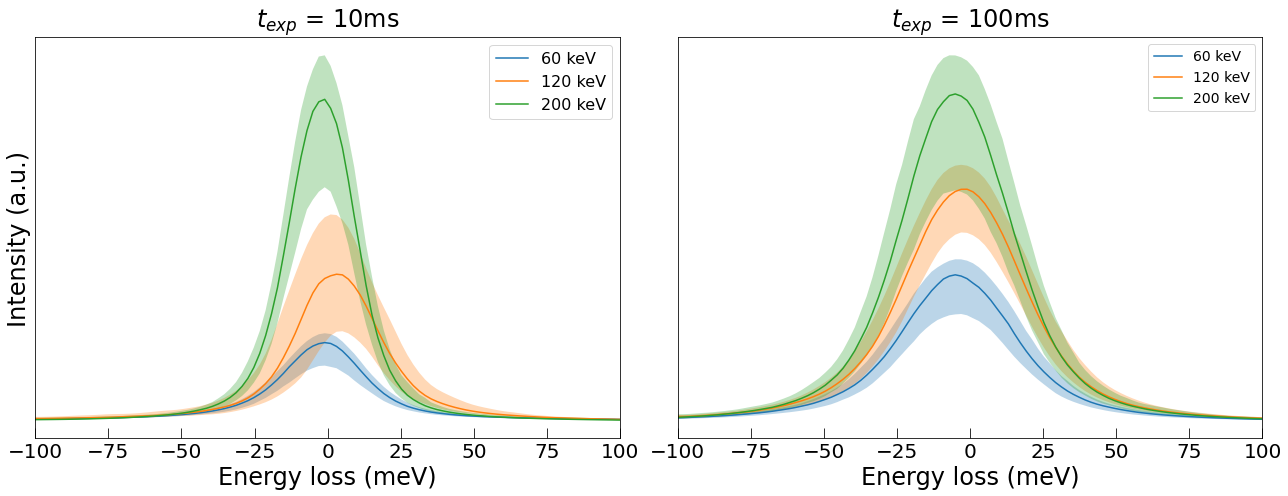

In [66]:
groups_full = energy_file_rescaled.groupby(['time', 'energy'])

ncols, nrows = 2,1

gs = matplotlib.gridspec.GridSpec(nrows,ncols)
plt.figure(figsize=(ncols*9,nrows*7))

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


interpolation_file = pd.DataFrame()

for name, group in groups_full:
    mean_prediction = group.iloc[:, 4:].median(axis=1).to_numpy()
    up_prediction = group.iloc[:, 4:].quantile(.84, axis=1).to_numpy()
    down_prediction = group.iloc[:, 4:].quantile(.16, axis=1).to_numpy()
    
    if group['energy'].max() == 1.2:
        up_prediction = group.iloc[:, 4:].quantile(.7, axis=1).to_numpy()
        down_prediction = group.iloc[:, 4:].quantile(.3, axis=1).to_numpy()
        mean_prediction = smooth(mean_prediction, 6)
        down_prediction = smooth(down_prediction, 6)
        up_prediction = smooth(up_prediction, 6)      
    
    if group['time'].max() == .1:
        if group['energy'].max() == .6:
            normalization = 29211
        if group['energy'].max() == 2:
            normalization = 126021
        if group['energy'].max() == 1.2:
            normalization = 77616
    

        ax = ax1
        ax.set_title('$t_{exp}$ = 10ms', fontsize = 24)
        ax.set_ylabel('Intensity (a.u.)', fontsize = 24)  
        ax.set_xlabel('Energy loss (meV)', fontsize = 24) 
        ax.set_yticks([])
        ax.tick_params(which='major',direction='in',length=10, labelsize=20)
        ax.tick_params(which='minor',length=10, labelsize=20)
        ax.set_xlim([-100, 100])
        ax.plot(group.x*1000, normalization*mean_prediction, label=(str(int(name[1]*100)))+' keV')
        ax.fill_between(group.x*1000, normalization*up_prediction, \
                        normalization*down_prediction, alpha=.3) 
        ax.legend(loc='upper right', fontsize=16)
    if group['time'].max() == 1:
        if group['energy'].max() == .6:
            normalization = 315762
        if group['energy'].max() == 2:
            normalization =  713038   
        if group['energy'].max() == 1.2:
            normalization = 514400
        ax = ax2
        ax.set_title('$t_{exp}$ = 100ms', fontsize = 24)
        ax.set_xlabel('Energy loss (meV)', fontsize = 24) 
        ax.set_yticks([])
        ax.tick_params(which='major',direction='in',length=10, labelsize=20)
        ax.tick_params(which='minor',length=10, labelsize=20)
        ax.set_xlim([-100, 100])
        ax.plot(group.x*1000, normalization*(mean_prediction), label=(str(int(name[1]*100)))+' keV')
        ax.fill_between(group.x*1000, normalization*up_prediction, \
                        normalization*down_prediction, alpha=.3) 

ax.legend(fontsize = 14, loc = 'upper right')

plt.tight_layout()

#plt.savefig('Data/Prediction_120keV.pdf')

In [22]:
energy_file = pd.read_csv('Data/Energy_extrapolation_cut_big')
energy_file.describe()

,Unnamed: 0,x,time,energy,prediction_1_0
count,4000.000000,4000.0000,4000.000000,4000.000000,4000.000000
mean,1999.500000,0.4500,0.550000,1.300000,0.175555
std,1154.844867,0.3179,0.450056,0.700088,0.181565
min,0.000000,-0.1000,0.100000,0.600000,0.100480
25%,999.750000,0.1750,0.100000,0.600000,0.100631
50%,1999.500000,0.4500,0.550000,1.300000,0.100933
75%,2999.250000,0.7250,1.000000,2.000000,0.125547
max,3999.000000,1.0000,1.000000,2.000000,0.922906


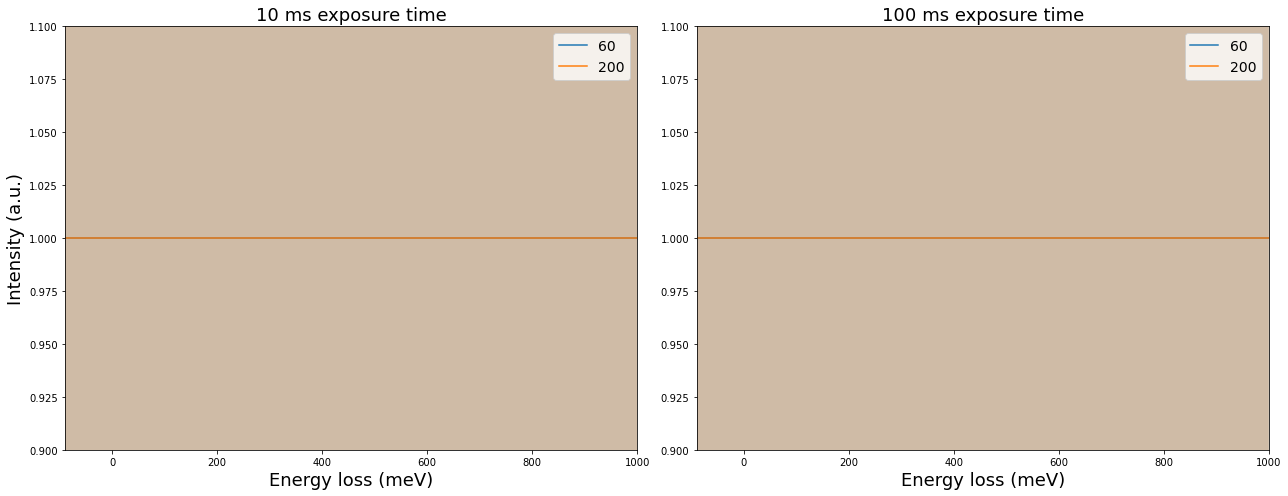

In [21]:
groups = energy_file.groupby(['time', 'energy'])
import matplotlib

ncols, nrows = 2,1
gs = matplotlib.gridspec.GridSpec(nrows,ncols)

plt.figure(figsize=(ncols*9,nrows*7))

for name, group in groups:
    mean_prediction = group.iloc[:, 4:].mean(axis=1).to_numpy()
    std_prediction = group.iloc[:, 4:].std(axis=1).to_numpy()
    
    if group['time'].max() == .1:
        i = 0
        ax = plt.subplot(gs[i])
        ax.set_title('10 ms exposure time', fontsize = 18)
        ax.set_ylabel('Intensity (a.u.)', fontsize = 18)
        #ax.set_ylim([0, 1])
        ax.plot(group.x*1000, np.divide(mean_prediction, mean_prediction), label=int(name[1] * 100))
        
        ax.fill_between(group.x*1000, np.divide(mean_prediction + std_prediction, mean_prediction), \
                        np.divide(mean_prediction - std_prediction, mean_prediction), alpha=.3)
                        
    if group['time'].max() == 1:
        i = 1
        ax = plt.subplot(gs[i])
        #ax.set_ylim([0, 1.2])
        ax.set_title('100 ms exposure time', fontsize = 18)
        ax.plot(group.x*1000, np.divide(mean_prediction, mean_prediction), label=int(name[1] * 100))
        ax.fill_between(group.x*1000, np.divide(mean_prediction + std_prediction, mean_prediction), \
                        np.divide(mean_prediction - std_prediction, mean_prediction), alpha=.3)
    plt.xlim([-90, +1000])
    plt.ylim([0.9, 1.1])
    
    plt.xlabel('Energy loss (meV)', fontsize = 18)
   
    #ax.set_yticklabels(fontsize=1)
    #ax.tick_params(which='major',direction='in',length=10, labelsize=16)
    #ax.tick_params(which='minor',length=10, labelsize=14)

    plt.legend(fontsize = 14)
plt.tight_layout()
#plt.savefig('Data/120keV_full.pdf')

## E_beam extrapolation plot

In [21]:
ebeam_file = pd.read_csv('Data/Prediction_vacuum_Ebeam_350')

In [27]:
groups_time = ebeam_file.groupby(['time'])

for name, group in groups_time:
    groups_energy = group.groupby(['energy'])
    fwhm_means = []
    fwhm_stds = []
    max_means = []
    max_stds = []
    fwhm_ups = []
    fwhm_downs = []
    
    for name_energy, group_energy in groups_energy:
        fwhm_array = []
        max_array = []
        
        
        for i in range(4,400):
            prediction = pd.DataFrame({"x": group_energy.x, "pred": group_energy.iloc[:,i]})
            max_x = prediction['x'][prediction['pred'] == prediction['pred'].max()].min()
            fwhm_min = prediction['x'][(prediction['x'] < 0) & (prediction['pred'].max() > .25) & \
                                   (prediction['pred'] > prediction['pred'].max()/2)].min()
            fwhm_max = prediction['x'][(prediction['x'] > 0) & (prediction['pred'].max() > .25) & \
                                   (prediction['pred'] < prediction['pred'].max()/2)].min()
            fwhm = (fwhm_max - fwhm_min)
            fwhm_array.append(fwhm)
            
        # Remove nan values  
        fwhm_array = [x for x in fwhm_array if str(x) != 'nan']
        
        
        fwhm_mean = np.median(fwhm_array)
        fwhm_std = np.std(fwhm_array)
        fwhm_up = np.quantile(fwhm_array, 0.84)
        fwhm_down = np.quantile(fwhm_array, 0.16)
        fwhm_means.append(fwhm_mean)
        fwhm_stds.append(fwhm_std)
        fwhm_ups.append(fwhm_up)
        fwhm_downs.append(fwhm_down)
       
        fwhm_high = fwhm_ups
        fwhm_low = fwhm_downs
      
        np.savetxt('Data/Results/fwhmvalues350_mean_%(s)s' % {"s": name}, fwhm_means)
        np.savetxt('Data/Results/fwhmvalues350_std_%(s)s' % {"s": name}, fwhm_stds)
        np.savetxt('Data/Results/fwhmvalues350_up_%(s)s' % {"s": name}, fwhm_ups)
        np.savetxt('Data/Results/fwhmvalues350_down_%(s)s' % {"s": name}, fwhm_downs)

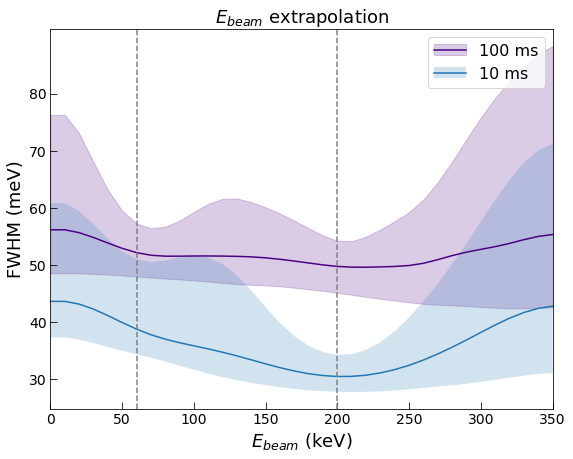

In [30]:
from matplotlib import rc
import matplotlib

fwhmvalues_mean_100 = np.loadtxt('Data/Results/fwhmvalues350_mean_1.0')
fwhmvalues_mean_10 = np.loadtxt('Data/Results/fwhmvalues350_mean_0.1')
up100 = np.loadtxt('Data/Results/fwhmvalues350_up_1.0')
up10 = np.loadtxt('Data/Results/fwhmvalues350_up_0.1')
low100 = np.loadtxt('Data/Results/fwhmvalues350_down_1.0')
low10 = np.loadtxt('Data/Results/fwhmvalues350_down_0.1')


hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})

nrows, ncols = 1,1

gs = matplotlib.gridspec.GridSpec(nrows,ncols)
wl = 8

color2 = 'indigo'
plt.figure(figsize=(ncols*9,nrows*7))
ax = plt.subplot(gs[0])
ax.plot(np.linspace(0,350,36), smooth(fwhmvalues_mean_100 * 1000, wl), color = color2, label = '100 ms')
ax.fill_between(np.linspace(0,350,36), smooth(up100 * 1000, wl), smooth(low100 * 1000, wl), color = color2, alpha=.2, label = '100 ms')
ax.plot(np.linspace(0,350,36), smooth(fwhmvalues_mean_10 * 1000, wl*2), label = '10 ms')
ax.fill_between(np.linspace(0,350,36), smooth(up10 * 1000, wl*2), smooth(low10 * 1000, wl),  alpha=.2, label = '10 ms')
ax.axvline(x=60, linestyle='--', color='gray')
ax.axvline(x=200, linestyle='--', color='gray')
ax.tick_params(which='major',direction='in',length=7, labelsize=14)
ax.tick_params(which='minor',length=8, labelsize=14)
ax.set_yticks([30, 40, 50, 60, 70, 80])
ax.set_ylabel('FWHM (meV)', fontsize = 18)
ax.set_xlim([0, 350])
ax.set_xlabel('$E_{beam}$ (keV)', fontsize = 18)
lables, handles = ax.get_legend_handles_labels() 
ax.legend([(lables[0], lables[2]), (lables[1], lables[3])], [(handles[0]), handles[1]], loc='upper right', fontsize=16)
ax.set_title('$E_{beam}$ extrapolation', fontsize=18)
plt.savefig('Ebeam_extrapolation_350.pdf')


## Time extrapolation plot

In [20]:
time_file = pd.read_csv('Data/Prediction_vacuum_time')

In [21]:
groups_energy = time_file.groupby(['energy'])

for name, group in groups_energy:
    groups_time = group.groupby(['time'])
    fwhm_means = []
    fwhm_stds = []
    max_means = []
    max_stds = []
    fwhm_ups = []
    fwhm_downs = []
    
    for name_time, group_time in groups_time:
        fwhm_array = []
        max_array = []
        

        for i in range(4,400):
            prediction = pd.DataFrame({"x": group_time.x, "pred": group_time.iloc[:,i]})
            max_x = prediction['x'][prediction['pred'] == prediction['pred'].max()].min()
            fwhm_min = prediction['x'][(prediction['x'] < 0) & (prediction['pred'].max() > .25) & \
                                   (prediction['pred'] > prediction['pred'].max()/2)].min()
            fwhm_max = prediction['x'][(prediction['x'] > 0) & (prediction['pred'].max() > .25) & \
                                   (prediction['pred'] < prediction['pred'].max()/2)].min()
            fwhm = (fwhm_max - fwhm_min)

            fwhm_array.append(fwhm)
            
        # Remove nan values  
        fwhm_array = [x for x in fwhm_array if str(x) != 'nan']
        
        
        fwhm_mean = np.median(fwhm_array)
        fwhm_std = np.std(fwhm_array)
        fwhm_up = np.quantile(fwhm_array, 0.84)
        fwhm_down = np.quantile(fwhm_array, 0.16)
        fwhm_means.append(fwhm_mean)
        fwhm_stds.append(fwhm_std)
        fwhm_ups.append(fwhm_up)
        fwhm_downs.append(fwhm_down)
      
        np.savetxt('Data/Results/fwhmvalues_time_mean_%(s)s' % {"s": name}, fwhm_means)
        np.savetxt('Data/Results/fwhmvalues_time_std_%(s)s' % {"s": name}, fwhm_stds)
        np.savetxt('Data/Results/fwhmvalues_time_up_%(s)s' % {"s": name}, fwhm_ups)
        np.savetxt('Data/Results/fwhmvalues_time_down_%(s)s' % {"s": name}, fwhm_downs)

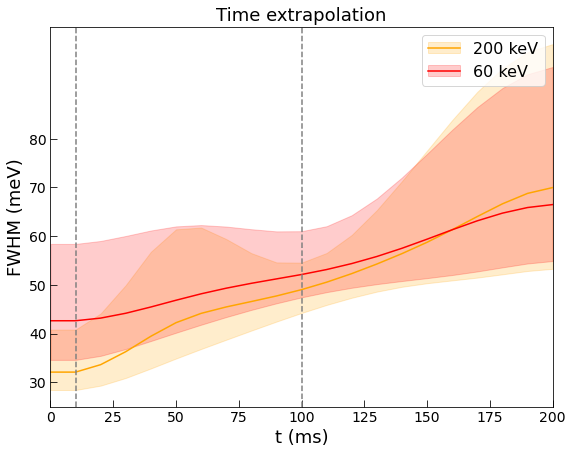

In [24]:
from matplotlib import rc
import matplotlib

fwhmvalues_mean_200 = np.loadtxt('Data/Results/fwhmvalues_time_mean_2.0')
fwhmvalues_mean_60 = np.loadtxt('Data/Results/fwhmvalues_time_mean_0.6')
up200 = np.loadtxt('Data/Results/fwhmvalues_time_up_2.0')
up60 = np.loadtxt('Data/Results/fwhmvalues_time_up_0.6')
low200 = np.loadtxt('Data/Results/fwhmvalues_time_down_2.0')
low60 = np.loadtxt('Data/Results/fwhmvalues_time_down_0.6')
fwhmvalues_std_200 = np.loadtxt('Data/Results/fwhmvalues_time_std_2.0')
fwhmvalues_std_60 = np.loadtxt('Data/Results/fwhmvalues_time_std_0.6')

hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})

nrows, ncols = 1,1

gs = matplotlib.gridspec.GridSpec(nrows,ncols)
wl = 8
color1 = 'red'
color2 = 'orange'
plt.figure(figsize=(ncols*9,nrows*7))
ax = plt.subplot(gs[0])
ax.plot(np.linspace(0,200,21), smooth(fwhmvalues_mean_200 * 1000, wl), color = color2, label = '200 keV')
ax.fill_between(np.linspace(0,200,21), smooth(up200 * 1000, wl), smooth(low200 * 1000, wl), color = color2, alpha=.2, label = '200 keV')
ax.plot(np.linspace(0,200,21), smooth(fwhmvalues_mean_60 * 1000, wl*2), color=color1, label = '60 keV')
ax.fill_between(np.linspace(0,200,21), smooth(up60 * 1000, wl*2), smooth(low60 * 1000, wl), color=color1, alpha=.2, label = '60 keV')
ax.axvline(x=10, linestyle='--', color='gray')
ax.axvline(x=100, linestyle='--', color='gray')
ax.tick_params(which='major',direction='in',length=7, labelsize=14)
ax.tick_params(which='minor',length=8, labelsize=14)
ax.set_yticks([30, 40, 50, 60, 70, 80])
ax.set_ylabel('FWHM (meV)', fontsize = 18)
ax.set_xlim([0, 200])
ax.set_xlabel('t (ms)', fontsize = 18)
lables, handles = ax.get_legend_handles_labels() 
ax.legend([(lables[0], lables[2]), (lables[1], lables[3])], [(handles[0]), handles[1]], loc='upper right', fontsize=16)
ax.set_title('Time extrapolation', fontsize=18)
plt.savefig('Time_extrapolation_350.pdf')


## Residuals

## Write everything to report file

In [157]:
import sys
import base64

energy = 200
time = 10
nbins = 60
training_epochs = 100000

reportname = r'Reports/%(date)s_%(energy)skeV_%(time)sms_e%(epoch)s_Nrep=%(i)s.html' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
sys.stdout = open(reportname,'w')


from prettytable import PrettyTable
list1 = ['Energy:','Exposure time:','Nbins:', 'Replicas:', 'Training epochs:']
list2 = [energy, time, nbins, Nrep, training_epochs]

for x in range(0,5):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 



In [ ]:
plot1 = r'Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot2 = r'Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot3 = r'Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot4 = r'Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)